# **EXP4 Dissociated and Classic Bulks Deconvolution by Adding More Cells**

Data downloaded from GEO Omnibus: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper can be accessed here: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels


**Summary:**
Evaluating the effect of (hypothesized) missing cell-types in the residual of real bulks deconvolved with a missing cell-type reference.

We are using single-cell and bulk matched samples from 8 patients. Each sample has a dissociated sample with ribosomal RNA depletion (-rRNA), non-dissociated sample with ribosomal RNA depletion (-rRNA), and dissociated sample with polyA tail capture (polyA). We are attempting to find evidence in the residual of a missing cell type (adipocyte) only in dissociated samples.

**Hypothesis:**
Dissociation process depletes the single-cell and bulk samples from adipocytes. Thus, only non-dissociated bulks show evidence of adipocytes in the residual. This will be evident by adipocyte-related gene expression in the residual of dissociates bulks compared to non-dissociated bulks.

**Deconv. Method:**
NNLS

**Factorization Methods:**
PCA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

import seaborn as sns
from scipy import stats
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"
use_all_genes = False

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [3]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
bulks  = bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            7        0      0           6           0           1   
2467            1        0      0          12           0           0   
2380            0        0      0           3           0           0   
2293            0        0      0           2           0           0   
2283            8        0      0           5           0           3   
2428            0        0      0           5           0           1   
2251            2        0      0           6           0           2   
2267            0        0      0           5           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          28           0           6           1  ...           0   
2467          77           0          10           0  ...           0   
2380          51           0           7           0  ...           0   
2293          27           0          12           0  ...           0   
2283          59           0           0           0  ...           0   
2428          26           0          10           0  ...           0   
2251          47           0           6           0  ...           0   
2267          81           1           3           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          16           0           0           6           2           4   
2467          81           0           0           0           2           0   
2380           1           0           6           1           0           0   
2293          54           0           0           0           1           0   
2283           3           0           0           0           0           0   
2428           8           0           0           0           0           0   
2251           0           0           2          13           0           0   
2267           7           0           1           3           0           0   

      AC007325.4  AC007325.2   condition  
2497          47          36  rrna_chunk  
2467          18          13  rrna_chunk  
2380          10          23  rrna_chunk  
2293           8           0  rrna_chunk  
2283          18          34  rrna_chunk  
2428          46          24  rrna_chunk  
2251          16           7  rrna_chunk  
2267           2           3  rrna_chunk  

[8 rows x 36602 columns]

Dissociated Bulks:

In [4]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
#the bulks come in this index:
diss_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
diss_bulks  = diss_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
diss_bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            3        0      0           2           0           0   
2467            1        0      0           5           0           0   
2380            4        0      0           2           0           0   
2293            2        0      0           4           0           0   
2283            1        0      0           1           0           0   
2428            3        2      0           1           0           0   
2251            8        0      0           1           0           1   
2267            1        0      0           1           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          15           0           1           0  ...           0   
2467          63           1           6           0  ...           0   
2380          37           0           2           0  ...           0   
2293          31           0           3           0  ...           0   
2283          33           0           2           0  ...           0   
2428           7           0           5           0  ...           0   
2251          38           0           0           0  ...           0   
2267          26           0           5           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          19           0           1           1           3           4   
2467          27           0           0           0           0           0   
2380           2           0           0           0           0           0   
2293           6           0           0           6           0           0   
2283           6           0           0           1           0           0   
2428          17           0           0           2           0           0   
2251           4           0           0           4           0           0   
2267          19           0           2          11           0           1   

      AC007325.4  AC007325.2  condition  
2497          39          28  rrna_diss  
2467           8           6  rrna_diss  
2380          10          21  rrna_diss  
2293           6           2  rrna_diss  
2283          20          16  rrna_diss  
2428          57          30  rrna_diss  
2251          10           9  rrna_diss  
2267          15           3  rrna_diss  

[8 rows x 36602 columns]

Dissociated polyA:

In [5]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
disspolya_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
disspolya_bulks  = disspolya_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
disspolya_bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497           17        2      0          10           0           2   
2467            2        1      0           7           0           3   
2380            5        1      0           6           0           0   
2293            4        0      0          13           0           4   
2283            7        0      0          11           0           9   
2428            0        0      0           1           0           0   
2251            2        0      0           6           0           1   
2267            0        0      0           5           0           1   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          66           0          15           1  ...           1   
2467         134           0           8           0  ...           4   
2380         159           0          16           0  ...           0   
2293          92           0           5           0  ...           0   
2283         114           0          12           0  ...           0   
2428          14           0          10           0  ...           0   
2251          93           0           9           1  ...           0   
2267          69           0          12           0  ...           1   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          35           0           0           9           9           7   
2467          58           0           1           2           0           0   
2380           2           0           2           6           0           0   
2293          16           0           0           1           0           0   
2283           9           0           0           1           0           0   
2428          35           0           0           6           0           0   
2251           6           0           2          16           0           0   
2267          33           0           4          30           0           0   

      AC007325.4  AC007325.2   condition  
2497          56          78  polyA_diss  
2467          15          11  polyA_diss  
2380          27          32  polyA_diss  
2293           4           6  polyA_diss  
2283          10          17  polyA_diss  
2428          51          27  polyA_diss  
2251          10          12  polyA_diss  
2267           6           3  polyA_diss  

[8 rows x 36602 columns]

And all single-cells:

In [6]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [7]:
#attaching adatas (single-cells) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [8]:
#Our ground truth in this case is single cell! But'll we'll merge them to get more cells.
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = vp.get_prop(adatas[num])
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))
    print(" ")    

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

Making genes the same in all single-cell datas, and merging.

In [9]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
merged_adata = sc.concat(adatas_list, join='inner')
merged_adata.var['gene_ids'] = merged_adata.var_names
merged_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

## Adding Adipocyte and Medothelial Cells to Reference

In [10]:
#paths:
res_name_adip = f"MCT_adp_EXP3"
pseudo_name_adip = "MCT_adp_EXP3"
files_path_adip= "/../data/EXP3/"
path_results_adip = "/../results/EXP3/"
data_path_adip = "/../data/EXP3/cibersort/"
cibersort_files_adip = "/../data/EXP3/cibersort_results/realisticprop_nonoise_0missing/\
CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_phenoclasses.CIBERSORTx_\
MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt"

In [11]:
#font for plots
font = {'fontname':'Arial'}

#parameters into paths
actual_path_adip = os.getcwd()
path_adip = f"{actual_path_adip}{files_path_adip}"
aug_data_path_adip = f"{actual_path_adip}{files_path_adip}"
cibersort_path_adip = f"{actual_path_adip}{cibersort_files_adip}"
path_results_adip = f"{actual_path_adip}{path_results_adip}"
data_path_adip = f"{actual_path_adip}{data_path_adip}"

#and as anndata object single nucleus 
adata_path_adip = os.path.join(path_adip, f"MCT_adp_EXP3_snadata_notlog.h5ad")
adata_path_adip = Path(adata_path_adip)
sn_adata = sc.read_h5ad(adata_path_adip)
cells_to_keep = ["No cells here"]
sn_adata = sn_adata[sn_adata.obs.cell_types.isin(cells_to_keep)]

In [12]:
genes_adatas = np.intersect1d(merged_adata.var["gene_ids"].values, sn_adata.var["gene_ids"].values)
merged_adata = merged_adata[:, genes_adatas]
sn_adata = sn_adata[:, genes_adatas]
merged_adata = sc.concat([sn_adata, merged_adata])
merged_adata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


And final formatting on the bulks:

In [13]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), 
index = range(1,17), columns = bulks.columns)

In [14]:
#making sure index matches:
sample_ids = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks.index = sample_ids
diss_bulks.index = sample_ids
disspolya_bulks.index = sample_ids
combo.index = sample_ids * 2
bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            7        0      0           6           0           1   
2467            1        0      0          12           0           0   
2380            0        0      0           3           0           0   
2293            0        0      0           2           0           0   
2283            8        0      0           5           0           3   
2428            0        0      0           5           0           1   
2251            2        0      0           6           0           2   
2267            0        0      0           5           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          28           0           6           1  ...           0   
2467          77           0          10           0  ...           0   
2380          51           0           7           0  ...           0   
2293          27           0          12           0  ...           0   
2283          59           0           0           0  ...           0   
2428          26           0          10           0  ...           0   
2251          47           0           6           0  ...           0   
2267          81           1           3           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          16           0           0           6           2           4   
2467          81           0           0           0           2           0   
2380           1           0           6           1           0           0   
2293          54           0           0           0           1           0   
2283           3           0           0           0           0           0   
2428           8           0           0           0           0           0   
2251           0           0           2          13           0           0   
2267           7           0           1           3           0           0   

      AC007325.4  AC007325.2   condition  
2497          47          36  rrna_chunk  
2467          18          13  rrna_chunk  
2380          10          23  rrna_chunk  
2293           8           0  rrna_chunk  
2283          18          34  rrna_chunk  
2428          46          24  rrna_chunk  
2251          16           7  rrna_chunk  
2267           2           3  rrna_chunk  

[8 rows x 36602 columns]

Assigning genes: 

In [15]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

Now the other cibersort genes for the other 2 cell types

In [16]:
cibersort_df = pd.read_csv(cibersort_path_adip, sep="\t")
cibersort_genes_adip = cibersort_df["NAME"].values

cibersort_genes = np.unique(np.concatenate((cibersort_genes,cibersort_genes_adip)))
cibersort_genes.shape

(6037,)

Defining gene markers:

In [17]:
#From deconv paper: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03077-7
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]
#adipocyte markers from CellMarker: https://academic.oup.com/nar/article/51/D1/D870/6775381
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [18]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/projects/aivich@xsede.org/code-server/tmp/ipykernel_2070664/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  adip_markers = np.array(adip_markers)


In [19]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
gene_ids

['A1BG',
 'A2M',
 'A2M.AS1',
 'A2ML1.AS1',
 'AADACL2.AS1',
 'AAGAB',
 'AASS',
 'AATF',
 'AATK',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA8',
 'ABCA9',
 'ABCA9.AS1',
 'ABCB1',
 'ABCB10',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC6',
 'ABCC9',
 'ABCD2',
 'ABCE1',
 'ABCG1',
 'ABHD12',
 'ABHD12B',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17B',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABHD5',
 'ABHD6',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABLIM3',
 'ABO',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002066.1',
 'AC002070.1',
 'AC002091.1',
 'AC002429.2',
 'AC003991.1',
 'AC004551.1',
 'AC004594.1',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC004862.1',
 'AC004917.1',
 'AC005037.1',
 'AC005064.1',
 'AC005162.3',
 'AC005237.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005699.1',
 'AC005920.2',
 'AC006064.2',
 'AC006160.1',
 'AC006369.1',
 'AC006387.1',
 'AC006449.6',
 'AC007032.1',
 'AC007114.2',
 'AC007319.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007529.2',
 'AC007563.

In [20]:
#and set intersection of gene_ids from adata, bulks, and cibersort:
genes_in_both = np.intersect1d(gene_ids, bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, diss_bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, merged_adata.var_names)
gene_ids = genes_in_both.copy()
gene_ids.shape

(4584,)

In [21]:
#cutting all to only include marker genes and barcode genes from cibersort.
bulks = bulks [gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
merged_adata = merged_adata[:, gene_ids]

# Prep. for Deconvolution:

Normalizing bulk counts:

In [22]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
combo.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']*2
combo

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.030876  1.0  0.209729  0.335750  0.240834  0.076847  0.212703    1.0   
2467  0.034156  1.0  0.224407  0.269735  0.326236  0.291123  0.142369    1.0   
2380  0.006397  1.0  0.212207  0.748020  0.292061  0.061545  0.106986    1.0   
2293  0.017374  1.0  0.336922  0.078354  0.325339  0.050419  0.252095    1.0   
2283  0.074856  1.0  0.319635  0.234299  0.245527  0.080345  0.117524    1.0   
2428  0.036937  1.0  0.204505  0.086486  0.375676  0.178378  0.072072    1.0   
2251  0.021250  1.0  0.190729  0.396149  0.239788  0.079230  0.127502    1.0   
2267  0.007981  1.0  0.254515  0.297082  0.291170  0.093115  0.103757    1.0   
2497  0.042750  1.0  0.181850  0.461569  0.233063  0.139100  0.119352    1.0   
2467  0.029119  1.0  0.157098  0.394004  0.248409  0.149189  0.059316    1.0   
2380  0.022433  1.0  0.196148  0.435246  0.318433  0.368496  0.060732    1.0   
2293  0.013316  1.0  0.295448  0.413072  0.314589  0.106528  0.092379    1.0   
2283  0.044855  1.0  0.217488  0.316346  0.252309  0.135745  0.070233    1.0   
2428  0.068274  1.0  0.192710  0.179496  0.329993  0.666593  0.035973    1.0   
2251  0.017914  1.0  0.172978  0.458757  0.286058  0.187533  0.059059    1.0   
2267  0.022504  1.0  0.190084  0.160638  0.299969  0.060808  0.077087    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.231686  0.044828  ...  0.279487  0.071358  0.079135  0.168332   
2467  0.339005  0.010215  ...  0.331982  0.091295  0.203658  0.224088   
2380  0.414047  0.108751  ...  0.150442  0.059780  0.067721  0.187501   
2293  0.230292  0.031682  ...  0.292635  0.110377  0.101519  0.059958   
2283  0.272226  0.099059  ...  0.355566  0.090825  0.216084  0.280959   
2428  1.000000  0.018468  ...  0.168468  0.100000  0.100450  0.406306   
2251  0.401133  0.084214  ...  0.211717  0.079492  0.086576  0.095495   
2267  0.281711  0.112625  ...  0.179432  0.052322  0.123563  0.145142   
2497  0.170132  0.112191  ...  0.331366  0.062280  0.078339  0.123910   
2467  0.304850  0.103534  ...  0.265305  0.078369  0.143078  0.112162   
2380  0.251409  0.145265  ...  0.228156  0.055534  0.090825  0.195327   
2293  0.147863  0.083502  ...  0.267429  0.072405  0.106528  0.212778   
2283  0.163189  0.120105  ...  0.317821  0.070529  0.151385  0.282999   
2428  0.497375  0.082223  ...  0.209962  0.041479  0.064237  0.173623   
2251  0.261707  0.296414  ...  0.212164  0.040586  0.096846  0.140230   
2267  0.141725  0.094084  ...  0.225755  0.060090  0.083551  0.017955   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.300528  0.048944  0.493790  0.490588  0.408481  1.000000  
2467  0.321767  0.071823  0.281227  0.512976  0.777285  0.691416  
2380  0.475151  0.039486  0.128383  0.522136  0.208237  0.761476  
2293  0.284459  0.112421  0.129795  0.516795  0.539279  0.749131  
2283  0.429922  0.089827  0.757542  1.000000  0.515757  0.335354  
2428  0.306757  0.031081  0.436937  0.662613  0.819820  0.253604  
2251  0.241624  0.117533  0.266810  0.746124  0.472493  0.877299  
2267  0.464986  0.088681  0.151645  0.549233  0.259541  1.000000  
2497  0.418819  0.045571  0.512999  0.485439  0.358708  1.000000  
2467  0.241579  0.092749  0.216055  0.707122  0.422763  1.000000  
2380  0.583794  0.050610  0.157028  0.604311  0.336488  1.000000  
2293  0.706300  0.125669  0.218326  0.407524  0.379505  1.000000  
2283  0.832178  0.077611  0.472453  0.913625  0.583410  0.711482  
2428  0.703667  0.027163  0.343942  0.499945  0.745880  0.601255  
2251  0.599547  0.074453  0.268145  0.441123  0.443922  0.873009  
2267  0.493644  0.125206  0.087860  0.470422  0.276508  1.000000  

[16 rows x 4584 columns]

In [23]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.030876  1.0  0.209729  0.335750  0.240834  0.076847  0.212703    1.0   
2467  0.034156  1.0  0.224407  0.269735  0.326236  0.291123  0.142369    1.0   
2380  0.006397  1.0  0.212207  0.748020  0.292061  0.061545  0.106986    1.0   
2293  0.017374  1.0  0.336922  0.078354  0.325339  0.050419  0.252095    1.0   
2283  0.074856  1.0  0.319635  0.234299  0.245527  0.080345  0.117524    1.0   
2428  0.036937  1.0  0.204505  0.086486  0.375676  0.178378  0.072072    1.0   
2251  0.021250  1.0  0.190729  0.396149  0.239788  0.079230  0.127502    1.0   
2267  0.007981  1.0  0.254515  0.297082  0.291170  0.093115  0.103757    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.231686  0.044828  ...  0.279487  0.071358  0.079135  0.168332   
2467  0.339005  0.010215  ...  0.331982  0.091295  0.203658  0.224088   
2380  0.414047  0.108751  ...  0.150442  0.059780  0.067721  0.187501   
2293  0.230292  0.031682  ...  0.292635  0.110377  0.101519  0.059958   
2283  0.272226  0.099059  ...  0.355566  0.090825  0.216084  0.280959   
2428  1.000000  0.018468  ...  0.168468  0.100000  0.100450  0.406306   
2251  0.401133  0.084214  ...  0.211717  0.079492  0.086576  0.095495   
2267  0.281711  0.112625  ...  0.179432  0.052322  0.123563  0.145142   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.300528  0.048944  0.493790  0.490588  0.408481  1.000000  
2467  0.321767  0.071823  0.281227  0.512976  0.777285  0.691416  
2380  0.475151  0.039486  0.128383  0.522136  0.208237  0.761476  
2293  0.284459  0.112421  0.129795  0.516795  0.539279  0.749131  
2283  0.429922  0.089827  0.757542  1.000000  0.515757  0.335354  
2428  0.306757  0.031081  0.436937  0.662613  0.819820  0.253604  
2251  0.241624  0.117533  0.266810  0.746124  0.472493  0.877299  
2267  0.464986  0.088681  0.151645  0.549233  0.259541  1.000000  

[8 rows x 4584 columns]

In [24]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
diss_bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.042750  1.0  0.181850  0.461569  0.233063  0.139100  0.119352    1.0   
2467  0.029119  1.0  0.157098  0.394004  0.248409  0.149189  0.059316    1.0   
2380  0.022433  1.0  0.196148  0.435246  0.318433  0.368496  0.060732    1.0   
2293  0.013316  1.0  0.295448  0.413072  0.314589  0.106528  0.092379    1.0   
2283  0.044855  1.0  0.217488  0.316346  0.252309  0.135745  0.070233    1.0   
2428  0.068274  1.0  0.192710  0.179496  0.329993  0.666593  0.035973    1.0   
2251  0.017914  1.0  0.172978  0.458757  0.286058  0.187533  0.059059    1.0   
2267  0.022504  1.0  0.190084  0.160638  0.299969  0.060808  0.077087    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.170132  0.112191  ...  0.331366  0.062280  0.078339  0.123910   
2467  0.304850  0.103534  ...  0.265305  0.078369  0.143078  0.112162   
2380  0.251409  0.145265  ...  0.228156  0.055534  0.090825  0.195327   
2293  0.147863  0.083502  ...  0.267429  0.072405  0.106528  0.212778   
2283  0.163189  0.120105  ...  0.317821  0.070529  0.151385  0.282999   
2428  0.497375  0.082223  ...  0.209962  0.041479  0.064237  0.173623   
2251  0.261707  0.296414  ...  0.212164  0.040586  0.096846  0.140230   
2267  0.141725  0.094084  ...  0.225755  0.060090  0.083551  0.017955   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.418819  0.045571  0.512999  0.485439  0.358708  1.000000  
2467  0.241579  0.092749  0.216055  0.707122  0.422763  1.000000  
2380  0.583794  0.050610  0.157028  0.604311  0.336488  1.000000  
2293  0.706300  0.125669  0.218326  0.407524  0.379505  1.000000  
2283  0.832178  0.077611  0.472453  0.913625  0.583410  0.711482  
2428  0.703667  0.027163  0.343942  0.499945  0.745880  0.601255  
2251  0.599547  0.074453  0.268145  0.441123  0.443922  0.873009  
2267  0.493644  0.125206  0.087860  0.470422  0.276508  1.000000  

[8 rows x 4584 columns]

In [25]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
disspolya_bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.022896  1.0  0.169267  0.493974  0.209695  0.059999  0.117051   
2467  0.028579  1.0  0.169502  0.439521  0.244398  0.100518  0.050259   
2380  0.010532  1.0  0.203908  0.493592  0.295521  0.072453  0.047963   
2293  0.006858  1.0  0.292518  0.466563  0.249716  0.046349  0.097427   
2283  0.016514  1.0  0.210502  0.348468  0.248338  0.053305  0.073373   
2428  0.028283  1.0  0.195912  0.150383  0.268574  0.154752  0.026443   
2251  0.009285  1.0  0.144343  0.476753  0.246480  0.068542  0.045075   
2267  0.012057  1.0  0.195362  0.167578  0.247785  0.036346  0.076013   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.721049  0.171837  0.085767  ...  0.299845  0.057959  0.073979   
2467  1.000000  0.241638  0.077655  ...  0.345704  0.089678  0.140134   
2380  1.000000  0.254790  0.107601  ...  0.236899  0.057734  0.081462   
2293  1.000000  0.117054  0.064557  ...  0.290863  0.057463  0.133844   
2283  0.882353  0.165559  0.109745  ...  0.336134  0.069819  0.177265   
2428  1.000000  0.316172  0.074502  ...  0.243050  0.059785  0.045989   
2251  1.000000  0.241753  0.233987  ...  0.207820  0.043218  0.102475   
2267  1.000000  0.155346  0.068150  ...  0.241494  0.065354  0.085100   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.080024  0.390222  0.062871  0.479541  0.571202  0.308006  1.000000  
2467  0.067012  0.240061  0.182313  0.251099  0.976408  0.373100  1.000000  
2380  0.108489  0.617942  0.106966  0.118894  0.617942  0.254663  1.000000  
2293  0.175936  0.654086  0.188942  0.222522  0.439841  0.296302  1.000000  
2283  0.242903  0.728082  0.119988  0.431247  1.000000  0.475145  1.000000  
2428  0.106464  0.713744  0.033342  0.286969  0.473223  0.695118  0.986456  
2251  0.101124  0.572138  0.101968  0.236013  0.435561  0.360097  1.000000  
2267  0.010659  0.461670  0.200430  0.084925  0.518811  0.219127  1.000000  

[8 rows x 4584 columns]

As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [26]:
Counter(merged_adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Unknown1': 512,
         'Unknown2': 155,
         'Erythroid': 21})

In [27]:
# remove cells that are unlabeled or unclassified
cell_type_id = merged_adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Unknown1", "Unknown2"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
merged_adata = merged_adata[merged_adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(merged_adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Erythroid'
 'Fibroblasts' 'ILC' 'Macrophages' 'Mast cells' 'Monocytes' 'NK cells'
 'Plasma cells' 'T cells' 'pDC']


## References

In [28]:
#Making cell type reference without scaling
ref_raw_all = dict()
idx = 1
adata = merged_adata
cell_types = adata.obs["cell_types"].unique()
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw_all = ref_raw
ref_raw_all

Plasma cells     Monocytes      T cells  Endothelial cells  \
A1BG      2919.648926   2869.490479  4243.376953        1694.584839   
A2M       5931.372559   1412.151978  1515.545654       92801.726562   
AAGAB     1480.733521   3091.079590  1464.920654        1799.506714   
AASS      1146.745850    454.101074   345.874329        2631.756104   
AATF      2935.534912   3521.283691  5871.931152        5560.477051   
...               ...           ...          ...                ...   
ZRSR2     1648.041138   2006.109131  5468.658203        2273.197021   
ZSCAN18    415.939362    679.720337   845.942688        2745.496826   
ZSWIM8     850.996765    919.869507  1806.901367        1549.068604   
ZXDC      2861.549561   2145.743896  1761.392090        1433.514282   
ZYX       2530.561279  15591.164062  5846.586426        8857.708984   

            NK cells  Epithelial cells          ILC   Fibroblasts  \
A1BG     5088.090820       5065.092285  4318.780273   4349.608887   
A2M      1552.946533       3969.983398  2523.430420  28061.205078   
AAGAB    1870.975952       1258.856934  2033.583496   1402.080933   
AASS      197.797897        633.854553   726.661499   4403.503418   
AATF     4780.307129       3817.324463  2697.994385   4273.543457   
...              ...               ...          ...           ...   
ZRSR2    5817.307617       1584.072510  3739.046387   2420.493652   
ZSCAN18  1605.250854       3589.776855  3540.470459   2492.393311   
ZSWIM8   1434.330078        931.892578  1022.609741   1732.645996   
ZXDC     2303.070801       2274.426270  1562.431396   1288.603027   
ZYX      7985.514160       7186.017090  4200.132812   7905.163574   

             B cells            DC   Macrophages           pDC   Mast cells  \
A1BG     3764.718018   2825.518799   3257.867432  14059.208984  3809.708008   
A2M       997.605286   4209.944336  11717.403320    615.364380     0.000000   
AAGAB    3016.275146    879.971680   3156.708740    734.394287   695.148987   
AASS      867.215393      0.000000    204.954498     53.313702  2307.726318   
AATF     5154.885254   2181.539795   4721.573242   3287.656006  3630.788086   
...              ...           ...           ...           ...          ...   
ZRSR2    5862.447754   2455.806885   3343.254395   1078.825317  3260.302246   
ZSCAN18  2810.657471    426.478149    438.317291    429.042938   772.696289   
ZSWIM8   1046.195923   1507.806885   2100.699707   2207.420166  3104.440430   
ZXDC     1695.918091   1703.608398   1775.096191   1685.921631     0.000000   
ZYX      2286.816162  10436.621094  12650.208008   2238.511963  2491.544189   

           Erythroid  
A1BG     1956.793701  
A2M      2736.297363  
AAGAB       0.000000  
AASS        0.000000  
AATF      878.383423  
...              ...  
ZRSR2       0.000000  
ZSCAN18     0.000000  
ZSWIM8      0.000000  
ZXDC        0.000000  
ZYX      9244.604492  

[4584 rows x 14 columns]

In [29]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_all.values
clip_upper = np.quantile(ref_raw_val, 0.90)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
ref_df_all = ref_df
ref_raw_all = ref_raw
all_refs = ref_df_all.copy()
ref_df_all

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
A1BG         0.334004   0.328266  0.485437           0.193858  0.582071   
A2M          0.678541   0.161548  0.173376           1.000000  0.177655   
AAGAB        0.169394   0.353615  0.167585           0.205861  0.214037   
AASS         0.131186   0.051949  0.039568           0.301069  0.022628   
AATF         0.335821   0.402830  0.671741           0.636111  0.546861   
...               ...        ...       ...                ...       ...   
ZRSR2        0.188534   0.229496  0.625607           0.260051  0.665492   
ZSCAN18      0.047583   0.077759  0.096775           0.314081  0.183639   
ZSWIM8       0.097353   0.105232  0.206707           0.177211  0.164085   
ZXDC         0.327357   0.245470  0.201501           0.163992  0.263468   
ZYX          0.289493   1.000000  0.668842           1.000000  0.913532   

         Epithelial cells       ILC  Fibroblasts   B cells        DC  \
A1BG             0.579440  0.494063     0.497589  0.430679  0.323236   
A2M              0.454161  0.288677     1.000000  0.114125  0.481612   
AAGAB            0.144012  0.232639     0.160396  0.345058  0.100668   
AASS             0.072512  0.083129     0.503755  0.099208  0.000000   
AATF             0.436697  0.308647     0.488888  0.589712  0.249565   
...                   ...       ...          ...       ...       ...   
ZRSR2            0.181216  0.427742     0.276901  0.670656  0.280941   
ZSCAN18          0.410666  0.405025     0.285126  0.321535  0.048789   
ZSWIM8           0.106607  0.116985     0.198212  0.119683  0.172491   
ZXDC             0.260191  0.178740     0.147414  0.194011  0.194891   
ZYX              0.822071  0.480490     0.904340  0.261609  1.000000   

         Macrophages       pDC  Mast cells  Erythroid  
A1BG        0.372696  1.000000    0.435826   0.223855  
A2M         1.000000  0.070397    0.000000   0.313029  
AAGAB       0.361123  0.084014    0.079524   0.000000  
AASS        0.023447  0.006099    0.264001   0.000000  
AATF        0.540142  0.376103    0.415357   0.100486  
...              ...       ...         ...        ...  
ZRSR2       0.382464  0.123416    0.372974   0.000000  
ZSCAN18     0.050143  0.049082    0.088395   0.000000  
ZSWIM8      0.240317  0.252526    0.355144   0.000000  
ZXDC        0.203069  0.192867    0.000000   0.000000  
ZYX         1.000000  0.256083    0.285029   1.000000  

[4584 rows x 14 columns]

## NNLS Deconvolution:

Here, we use the SC-reference to deconvolve the dissociated bulk and the non-dissociated bulk (from matched tissue).

In [30]:
#dissociated bulks
calc_prop_tot_dissbulks, calc_res_tot_dissbulks = vp.calc_nnls_hgsoc(all_refs, prop_df, diss_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [31]:
#dissociated polyA bulks
calc_prop_tot_disspolyabulks, calc_res_tot_disspolyabulks = vp.calc_nnls_hgsoc(all_refs, prop_df, disspolya_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [32]:
#non dissociated bulks
calc_prop_tot_bulks, calc_res_tot_bulks = vp.calc_nnls_hgsoc(all_refs, prop_df, bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [33]:
#combination
calc_prop_tot_combo = pd.concat([calc_prop_tot_bulks, calc_prop_tot_dissbulks])
calc_prop_tot_combo

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
2497      0.165109   0.000000  0.000000           0.014745  0.000000   
2467      0.181888   0.000000  0.000000           0.000000  0.000000   
2380      0.052042   0.068201  0.000000           0.282510  0.000000   
2293      0.093658   0.000000  0.005660           0.000000  0.005935   
2283      0.123398   0.000000  0.000000           0.069999  0.000000   
2428      0.199722   0.000000  0.000000           0.018217  0.000000   
2251      0.293802   0.000000  0.000000           0.012105  0.000000   
2267      0.067674   0.122282  0.000000           0.231960  0.000000   
2497      0.174367   0.000000  0.000000           0.119908  0.000000   
2467      0.208318   0.000000  0.000000           0.137198  0.000000   
2380      0.148450   0.083011  0.000000           0.256182  0.000000   
2293      0.177138   0.025634  0.000000           0.162810  0.000000   
2283      0.173820   0.000000  0.000000           0.102914  0.000000   
2428      0.281729   0.000000  0.000000           0.100824  0.000000   
2251      0.347185   0.000000  0.000000           0.335476  0.000000   
2267      0.161303   0.000000  0.075025           0.027454  0.033419   

      Epithelial cells       ILC  Fibroblasts   B cells   DC  Macrophages  \
2497          0.330890  0.010414     0.405627  0.006001  0.0     0.067214   
2467          0.594780  0.017668     0.096851  0.000000  0.0     0.108813   
2380          0.000000  0.000000     0.486796  0.000000  0.0     0.110451   
2293          0.405525  0.000000     0.000000  0.000000  0.0     0.477175   
2283          0.475581  0.000000     0.260256  0.000000  0.0     0.070765   
2428          0.550242  0.009665     0.084891  0.052469  0.0     0.084794   
2251          0.000000  0.000000     0.384471  0.027763  0.0     0.281859   
2267          0.000000  0.000000     0.338649  0.000000  0.0     0.239434   
2497          0.224072  0.000000     0.445330  0.000000  0.0     0.025461   
2467          0.032936  0.000000     0.349295  0.000000  0.0     0.272253   
2380          0.000000  0.000000     0.434647  0.000000  0.0     0.077710   
2293          0.231622  0.041681     0.145030  0.000000  0.0     0.216085   
2283          0.361341  0.000000     0.319269  0.000000  0.0     0.042656   
2428          0.349199  0.000000     0.158878  0.000000  0.0     0.109371   
2251          0.000000  0.000000     0.216711  0.000000  0.0     0.100628   
2267          0.014426  0.000000     0.173491  0.000000  0.0     0.509131   

      pDC  Mast cells  Erythroid  
2497  0.0    0.000000   0.000000  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.012047   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.000000  
2497  0.0    0.000000   0.010862  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.000000   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.005751

## Evalutating NNLS Performance:

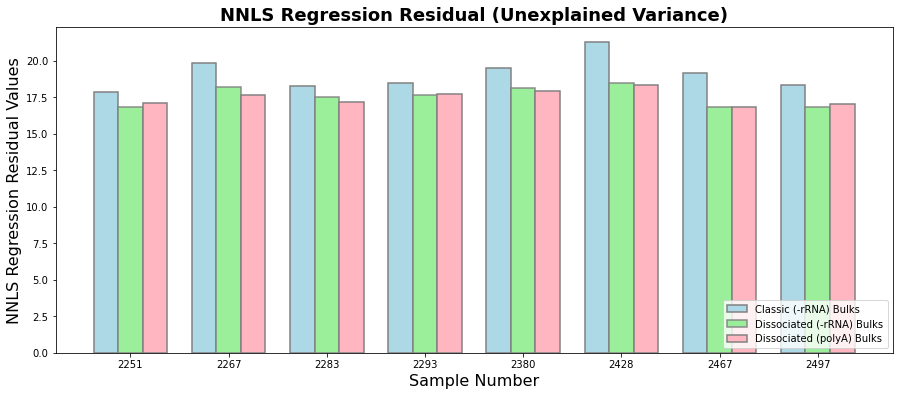

In [34]:

# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# Create x-coordinates for the bars
x_coordinates = np.arange(len(classic_bulks_values))
# Width of each bar
bar_width = 0.25

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=1, label='Classic (-rRNA) Bulks',
                        color='lightblue', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.9, label='Dissociated (-rRNA) Bulks', 
                        color='lightgreen', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=1, 
                label='Dissociated (polyA) Bulks', color="lightpink", edgecolor='grey', linewidth=1.5)

plt.xlabel('Sample Number', fontsize=16)
plt.ylabel('NNLS Regression Residual Values', fontsize = '16')

# Make the title bold
plt.title('NNLS Regression Residual (Unexplained Variance)', fontweight='bold', fontsize = '18')

plt.xticks(x_coordinates + bar_width, ['2251', '2267', '2283', '2293', '2380', '2428', '2467', '2497'])  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend(loc='lower right')

plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


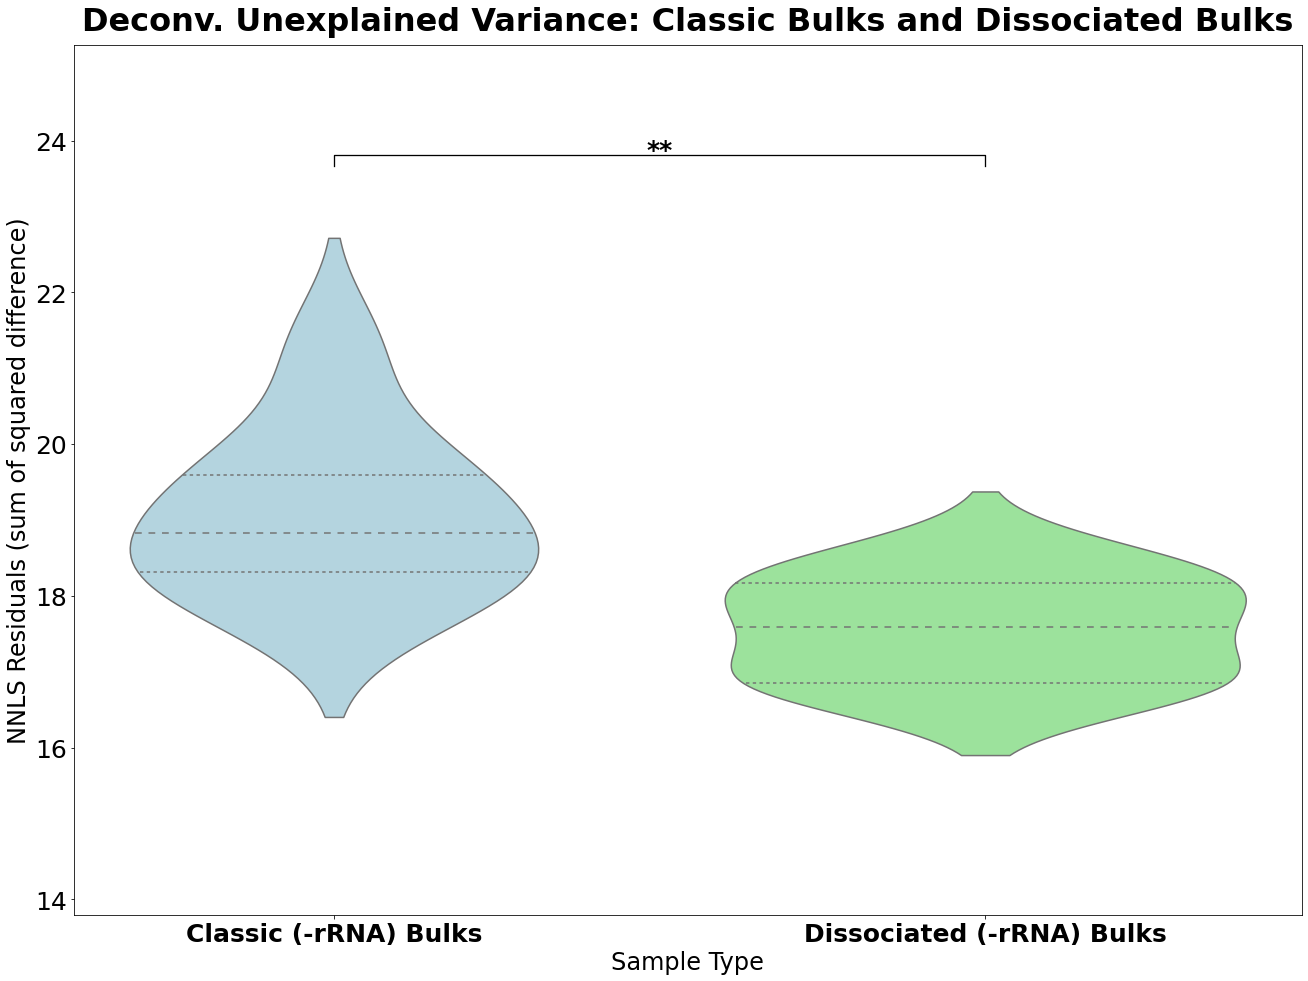

In [35]:
# Adjusted plot code for matching dimensions and formatting
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_bulks.values
bulk_type_2 = calc_res_tot_dissbulks.values
bulk_type_1 =bulk_type_1.flatten()
bulk_type_2=bulk_type_2.flatten()
# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(22, 16))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=25, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Getting maximum value for significance line
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 2.4, max_val + 2.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1.3, color='black')
    plt.text((x1 + x2) / 2, y2 - 0.1, asterisks, ha='center', va='bottom', fontsize=25, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    x1, x2 = 0, 1
    y1, y2 = max_val + 2.4, max_val + 2.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1.3, color='black')
    plt.text((x1 + x2) / 2, y2 - 0.25, "N.S.", ha='center', va='bottom', fontsize=25, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=24, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=24, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=32, fontname='Arial', fontweight='bold', x=0.5, y=1.01)
plt.ylim(df['Residuals'].min() - 3, df['Residuals'].max() + 4)
plt.yticks(fontsize=25, fontname='Arial')
plt.show()


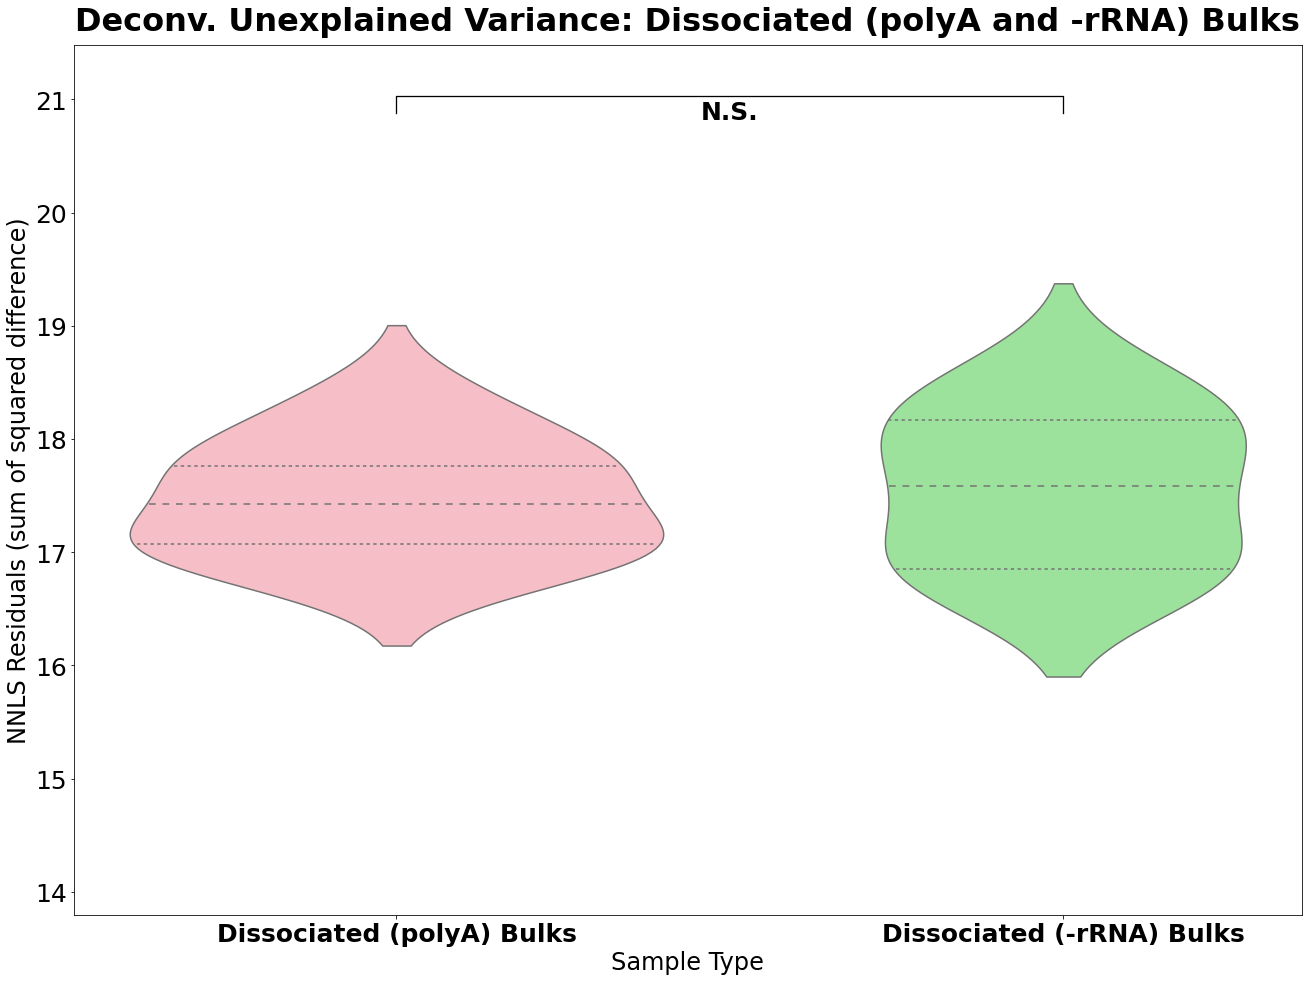

In [36]:
# Adjusted plot code for matching dimensions and formatting
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_disspolyabulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(22, 16))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=25, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Getting maximum value for significance line
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 2.4, max_val + 2.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1.3, color='black')
    plt.text((x1 + x2) / 2, y2 - 0.1, asterisks, ha='center', va='bottom', fontsize=25, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    x1, x2 = 0, 1
    y1, y2 = max_val + 2.4, max_val + 2.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1.3, color='black')
    plt.text((x1 + x2) / 2, y2 - 0.25, "N.S.", ha='center', va='bottom', fontsize=25, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=24, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=24, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', fontsize=32, fontname='Arial', fontweight='bold', x=0.5, y=1.01)
plt.ylim(df['Residuals'].min() - 3, df['Residuals'].max() + 3)
plt.yticks(fontsize=25, fontname='Arial')
plt.show()


## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [37]:
all_refs.max()

Plasma cells         1.0
Monocytes            1.0
T cells              1.0
Endothelial cells    1.0
NK cells             1.0
Epithelial cells     1.0
ILC                  1.0
Fibroblasts          1.0
B cells              1.0
DC                   1.0
Macrophages          1.0
pDC                  1.0
Mast cells           1.0
Erythroid            1.0
dtype: float32

In [38]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_bulks.T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.columns = gene_ids
bulks_recreated_mat_all   

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.484352  0.753588  0.172483  0.257466  0.450690  0.122650  0.073668   
2467  0.502866  0.604309  0.175406  0.119799  0.432397  0.087931  0.078191   
2380  0.377926  0.926087  0.209057  0.343241  0.522306  0.159007  0.068298   
2293  0.455553  0.726935  0.249761  0.056419  0.478337  0.104212  0.080684   
2283  0.486231  0.700742  0.171101  0.204513  0.459111  0.109530  0.073526   
2428  0.490287  0.582098  0.181414  0.122346  0.440175  0.079926  0.076028   
2251  0.408791  0.880960  0.225294  0.245229  0.462944  0.123802  0.071557   
2267  0.365456  0.875718  0.243239  0.261277  0.514428  0.160077  0.081076   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.830093  0.190341  0.066992  ...  0.951621  0.307361  0.275846   
2467  0.711624  0.139106  0.052355  ...  0.949490  0.310300  0.310162   
2380  0.889685  0.202438  0.251845  ...  0.986052  0.263319  0.311403   
2293  0.800261  0.160125  0.042353  ...  0.973403  0.274369  0.310879   
2283  0.749457  0.149794  0.091750  ...  0.967953  0.316334  0.318229   
2428  0.699743  0.150364  0.069967  ...  0.913885  0.303154  0.297930   
2251  0.979480  0.264158  0.081693  ...  0.905825  0.228636  0.219906   
2267  0.909424  0.201276  0.213585  ...  0.981348  0.236809  0.291709   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.211206  0.255931  0.241430  0.273546  0.152452  0.219032  0.775171  
2467  0.177272  0.274274  0.218068  0.293137  0.128529  0.253831  0.746495  
2380  0.204626  0.237928  0.275968  0.240847  0.185340  0.174297  0.916457  
2293  0.128452  0.258782  0.285631  0.197621  0.173445  0.235777  0.850300  
2283  0.198257  0.272299  0.226781  0.300916  0.143710  0.228352  0.802809  
2428  0.171549  0.268864  0.237364  0.290432  0.125946  0.253176  0.708308  
2251  0.184305  0.206374  0.291420  0.150465  0.178013  0.217463  0.733973  
2267  0.169325  0.227131  0.286491  0.194147  0.185227  0.188753  0.919522  

[8 rows x 4584 columns]

In [39]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_dissbulks.T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.columns = gene_ids
dissbulks_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.444833  0.814179  0.167114  0.300157  0.465243  0.124551  0.066246   
2467  0.390533  0.915057  0.222617  0.253366  0.489435  0.127394  0.066237   
2380  0.371733  0.882679  0.205017  0.321693  0.500720  0.147684  0.071441   
2293  0.406645  0.765487  0.216935  0.171973  0.475011  0.106002  0.069608   
2283  0.462145  0.746890  0.169281  0.241822  0.460761  0.111617  0.069908   
2428  0.435802  0.718829  0.183747  0.175235  0.447989  0.089889  0.070343   
2251  0.326333  0.888394  0.198971  0.258076  0.490293  0.092937  0.053699   
2267  0.400795  0.846824  0.266465  0.133532  0.507004  0.117118  0.082414   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.837150  0.196024  0.140915  ...  0.946438  0.290117  0.289440   
2467  0.930969  0.232506  0.160302  ...  0.945079  0.235939  0.273574   
2380  0.899966  0.212277  0.241878  ...  0.961487  0.244522  0.293712   
2293  0.805961  0.184922  0.193221  ...  0.945717  0.249734  0.305535   
2283  0.790222  0.172855  0.124398  ...  0.955165  0.297917  0.307210   
2428  0.796737  0.182457  0.132668  ...  0.927115  0.260337  0.298676   
2251  0.869003  0.226259  0.320198  ...  0.910364  0.195511  0.313949   
2267  0.886840  0.243446  0.118575  ...  0.951277  0.238620  0.267582   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.218106  0.246418  0.237712  0.266229  0.156501  0.205864  0.793642  
2467  0.185286  0.221011  0.281769  0.179774  0.182766  0.206041  0.812715  
2380  0.200274  0.225346  0.263734  0.221807  0.173413  0.190839  0.852947  
2293  0.163845  0.243852  0.264224  0.225746  0.159039  0.223955  0.797403  
2283  0.206243  0.257963  0.229735  0.282155  0.147215  0.223523  0.781665  
2428  0.183217  0.241623  0.228439  0.239261  0.140297  0.245250  0.722499  
2251  0.187328  0.207869  0.251191  0.188723  0.160387  0.221050  0.732592  
2267  0.127474  0.223834  0.352105  0.110616  0.199839  0.213946  0.838495  

[8 rows x 4584 columns]

In [40]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
disspolyabulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_disspolyabulks.T)
disspolyabulks_recreated_mat_all = disspolyabulks_recreated_mat_all.T
disspolyabulks_recreated_mat_all.columns = gene_ids
disspolyabulks_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.444010  0.801983  0.160709  0.298894  0.462354  0.125585  0.063793   
2467  0.393032  0.935825  0.226088  0.264497  0.511335  0.140276  0.063805   
2380  0.360988  0.856931  0.210113  0.302360  0.498593  0.150160  0.073962   
2293  0.416407  0.731111  0.215239  0.167634  0.477104  0.112542  0.074610   
2283  0.471525  0.752498  0.169985  0.249010  0.473560  0.119198  0.069758   
2428  0.427989  0.684114  0.177611  0.147475  0.437186  0.084176  0.066734   
2251  0.315899  0.887641  0.193761  0.273372  0.500073  0.096230  0.051494   
2267  0.403586  0.841584  0.258811  0.131237  0.489306  0.121134  0.077037   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.794259  0.179442  0.142386  ...  0.936152  0.298972  0.292011   
2467  0.885529  0.206111  0.178625  ...  0.967376  0.258764  0.297636   
2380  0.873670  0.198925  0.247356  ...  0.953908  0.240290  0.292854   
2293  0.780901  0.166745  0.186778  ...  0.958851  0.262324  0.314432   
2283  0.767001  0.157410  0.128590  ...  0.974833  0.315536  0.323307   
2428  0.723939  0.156416  0.132050  ...  0.899555  0.263979  0.298935   
2251  0.835165  0.211140  0.360605  ...  0.915433  0.200905  0.331563   
2267  0.855001  0.220552  0.107784  ...  0.931187  0.242483  0.255713   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.213706  0.251772  0.231684  0.274467  0.153990  0.193097  0.829697  
2467  0.182347  0.238106  0.289475  0.205710  0.191663  0.183158  0.905981  
2380  0.187112  0.224972  0.261041  0.215730  0.170591  0.185238  0.881612  
2293  0.162467  0.252234  0.258118  0.244163  0.155356  0.222792  0.824291  
2283  0.207792  0.270318  0.233498  0.303910  0.151636  0.214264  0.828221  
2428  0.167257  0.245783  0.217236  0.238948  0.133190  0.231226  0.764090  
2251  0.188495  0.213691  0.246843  0.206671  0.159236  0.210829  0.766304  
2267  0.125749  0.225736  0.330766  0.123201  0.192993  0.200163  0.885679  

[8 rows x 4584 columns]

In [41]:
calc_prop_tot_combo

Plasma cells  Monocytes   T cells  Endothelial cells  NK cells  \
2497      0.165109   0.000000  0.000000           0.014745  0.000000   
2467      0.181888   0.000000  0.000000           0.000000  0.000000   
2380      0.052042   0.068201  0.000000           0.282510  0.000000   
2293      0.093658   0.000000  0.005660           0.000000  0.005935   
2283      0.123398   0.000000  0.000000           0.069999  0.000000   
2428      0.199722   0.000000  0.000000           0.018217  0.000000   
2251      0.293802   0.000000  0.000000           0.012105  0.000000   
2267      0.067674   0.122282  0.000000           0.231960  0.000000   
2497      0.174367   0.000000  0.000000           0.119908  0.000000   
2467      0.208318   0.000000  0.000000           0.137198  0.000000   
2380      0.148450   0.083011  0.000000           0.256182  0.000000   
2293      0.177138   0.025634  0.000000           0.162810  0.000000   
2283      0.173820   0.000000  0.000000           0.102914  0.000000   
2428      0.281729   0.000000  0.000000           0.100824  0.000000   
2251      0.347185   0.000000  0.000000           0.335476  0.000000   
2267      0.161303   0.000000  0.075025           0.027454  0.033419   

      Epithelial cells       ILC  Fibroblasts   B cells   DC  Macrophages  \
2497          0.330890  0.010414     0.405627  0.006001  0.0     0.067214   
2467          0.594780  0.017668     0.096851  0.000000  0.0     0.108813   
2380          0.000000  0.000000     0.486796  0.000000  0.0     0.110451   
2293          0.405525  0.000000     0.000000  0.000000  0.0     0.477175   
2283          0.475581  0.000000     0.260256  0.000000  0.0     0.070765   
2428          0.550242  0.009665     0.084891  0.052469  0.0     0.084794   
2251          0.000000  0.000000     0.384471  0.027763  0.0     0.281859   
2267          0.000000  0.000000     0.338649  0.000000  0.0     0.239434   
2497          0.224072  0.000000     0.445330  0.000000  0.0     0.025461   
2467          0.032936  0.000000     0.349295  0.000000  0.0     0.272253   
2380          0.000000  0.000000     0.434647  0.000000  0.0     0.077710   
2293          0.231622  0.041681     0.145030  0.000000  0.0     0.216085   
2283          0.361341  0.000000     0.319269  0.000000  0.0     0.042656   
2428          0.349199  0.000000     0.158878  0.000000  0.0     0.109371   
2251          0.000000  0.000000     0.216711  0.000000  0.0     0.100628   
2267          0.014426  0.000000     0.173491  0.000000  0.0     0.509131   

      pDC  Mast cells  Erythroid  
2497  0.0    0.000000   0.000000  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.012047   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.000000  
2497  0.0    0.000000   0.010862  
2467  0.0    0.000000   0.000000  
2380  0.0    0.000000   0.000000  
2293  0.0    0.000000   0.000000  
2283  0.0    0.000000   0.000000  
2428  0.0    0.000000   0.000000  
2251  0.0    0.000000   0.000000  
2267  0.0    0.000000   0.005751

In [42]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
combo_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_combo.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
combo_recreated_mat_all.columns = gene_ids
combo_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.484352  0.753588  0.172483  0.257466  0.450690  0.122650  0.073668   
2467  0.502866  0.604309  0.175406  0.119799  0.432397  0.087931  0.078191   
2380  0.377926  0.926087  0.209057  0.343241  0.522306  0.159007  0.068298   
2293  0.455553  0.726935  0.249761  0.056419  0.478337  0.104212  0.080684   
2283  0.486231  0.700742  0.171101  0.204513  0.459111  0.109530  0.073526   
2428  0.490287  0.582098  0.181414  0.122346  0.440175  0.079926  0.076028   
2251  0.408791  0.880960  0.225294  0.245229  0.462944  0.123802  0.071557   
2267  0.365456  0.875718  0.243239  0.261277  0.514428  0.160077  0.081076   
2497  0.444833  0.814179  0.167114  0.300157  0.465243  0.124551  0.066246   
2467  0.390533  0.915057  0.222617  0.253366  0.489435  0.127394  0.066237   
2380  0.371733  0.882679  0.205017  0.321693  0.500720  0.147684  0.071441   
2293  0.406645  0.765487  0.216935  0.171973  0.475011  0.106002  0.069608   
2283  0.462145  0.746890  0.169281  0.241822  0.460761  0.111617  0.069908   
2428  0.435802  0.718829  0.183747  0.175235  0.447989  0.089889  0.070343   
2251  0.326333  0.888394  0.198971  0.258076  0.490293  0.092937  0.053699   
2267  0.400795  0.846824  0.266465  0.133532  0.507004  0.117118  0.082414   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.830093  0.190341  0.066992  ...  0.951621  0.307361  0.275846   
2467  0.711624  0.139106  0.052355  ...  0.949490  0.310300  0.310162   
2380  0.889685  0.202438  0.251845  ...  0.986052  0.263319  0.311403   
2293  0.800261  0.160125  0.042353  ...  0.973403  0.274369  0.310879   
2283  0.749457  0.149794  0.091750  ...  0.967953  0.316334  0.318229   
2428  0.699743  0.150364  0.069967  ...  0.913885  0.303154  0.297930   
2251  0.979480  0.264158  0.081693  ...  0.905825  0.228636  0.219906   
2267  0.909424  0.201276  0.213585  ...  0.981348  0.236809  0.291709   
2497  0.837150  0.196024  0.140915  ...  0.946438  0.290117  0.289440   
2467  0.930969  0.232506  0.160302  ...  0.945079  0.235939  0.273574   
2380  0.899966  0.212277  0.241878  ...  0.961487  0.244522  0.293712   
2293  0.805961  0.184922  0.193221  ...  0.945717  0.249734  0.305535   
2283  0.790222  0.172855  0.124398  ...  0.955165  0.297917  0.307210   
2428  0.796737  0.182457  0.132668  ...  0.927115  0.260337  0.298676   
2251  0.869003  0.226259  0.320198  ...  0.910364  0.195511  0.313949   
2267  0.886840  0.243446  0.118575  ...  0.951277  0.238620  0.267582   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.211206  0.255931  0.241430  0.273546  0.152452  0.219032  0.775171  
2467  0.177272  0.274274  0.218068  0.293137  0.128529  0.253831  0.746495  
2380  0.204626  0.237928  0.275968  0.240847  0.185340  0.174297  0.916457  
2293  0.128452  0.258782  0.285631  0.197621  0.173445  0.235777  0.850300  
2283  0.198257  0.272299  0.226781  0.300916  0.143710  0.228352  0.802809  
2428  0.171549  0.268864  0.237364  0.290432  0.125946  0.253176  0.708308  
2251  0.184305  0.206374  0.291420  0.150465  0.178013  0.217463  0.733973  
2267  0.169325  0.227131  0.286491  0.194147  0.185227  0.188753  0.919522  
2497  0.218106  0.246418  0.237712  0.266229  0.156501  0.205864  0.793642  
2467  0.185286  0.221011  0.281769  0.179774  0.182766  0.206041  0.812715  
2380  0.200274  0.225346  0.263734  0.221807  0.173413  0.190839  0.852947  
2293  0.163845  0.243852  0.264224  0.225746  0.159039  0.223955  0.797403  
2283  0.206243  0.257963  0.229735  0.282155  0.147215  0.223523  0.781665  
2428  0.183217  0.241623  0.228439  0.239261  0.140297  0.245250  0.722499  
2251  0.187328  0.207869  0.251191  0.188723  0.160387  0.221050  0.732592  
2267  0.127474  0.223834  0.352105  0.110616  0.199839  0.213946  0.838495  

[16 rows x 4584 columns]

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [43]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns, index = sample_ids)
residuals_bulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.453476  0.246412  0.037247  0.078284 -0.209855 -0.045803  0.139035   
2467 -0.468710  0.395691  0.049001  0.149936 -0.106161  0.203192  0.064178   
2380 -0.371529  0.073913  0.003150  0.404779 -0.230245 -0.097462  0.038688   
2293 -0.438179  0.273065  0.087160  0.021935 -0.152999 -0.053793  0.171412   
2283 -0.411375  0.299258  0.148533  0.029786 -0.213584 -0.029184  0.043998   
2428 -0.453350  0.417902  0.023091 -0.035859 -0.064500  0.098453 -0.003956   
2251 -0.387541  0.119040 -0.034565  0.150919 -0.223156 -0.044572  0.055945   
2267 -0.357475  0.124282  0.011276  0.035806 -0.223257 -0.066962  0.022681   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.169907  0.041345 -0.022164  ... -0.672134 -0.236003 -0.196711   
2467  0.288376  0.199898 -0.042140  ... -0.617508 -0.219004 -0.106504   
2380  0.110315  0.211609 -0.143095  ... -0.835609 -0.203539 -0.243682   
2293  0.199739  0.070167 -0.010671  ... -0.680768 -0.163992 -0.209360   
2283  0.250543  0.122432  0.007309  ... -0.612388 -0.225509 -0.102145   
2428  0.300257  0.849636 -0.051498  ... -0.745416 -0.203154 -0.197479   
2251  0.020520  0.136975  0.002522  ... -0.694109 -0.149144 -0.133330   
2267  0.090576  0.080435 -0.100960  ... -0.801916 -0.184487 -0.168146   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.042873  0.044597 -0.192486  0.220245  0.338137  0.189448  0.224829  
2467  0.046816  0.047494 -0.146245 -0.011910  0.384447  0.523454 -0.055079  
2380 -0.017125  0.237223 -0.236483 -0.112464  0.336797  0.033940 -0.154981  
2293 -0.068494  0.025677 -0.173211 -0.067826  0.343350  0.303502 -0.101168  
2283  0.082702  0.157623 -0.136954  0.456625  0.856290  0.287405 -0.467455  
2428  0.234757  0.037893 -0.206283  0.146505  0.536667  0.566643 -0.454704  
2251 -0.088809  0.035251 -0.173887  0.116345  0.568111  0.255030  0.143326  
2267 -0.024184  0.237855 -0.197810 -0.042502  0.364006  0.070787  0.080478  

[8 rows x 4584 columns]

In [44]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns, index = sample_ids)
residuals_dissbulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.402083  0.185821  0.014736  0.161411 -0.232180  0.014549  0.053107   
2467 -0.361415  0.084943 -0.065519  0.140638 -0.241026  0.021795 -0.006921   
2380 -0.349301  0.117321 -0.008869  0.113553 -0.182287  0.220812 -0.010709   
2293 -0.393329  0.234513  0.078512  0.241099 -0.160422  0.000526  0.022772   
2283 -0.417290  0.253110  0.048207  0.074523 -0.208451  0.024129  0.000325   
2428 -0.367527  0.281171  0.008963  0.004261 -0.117996  0.576705 -0.034371   
2251 -0.308419  0.111606 -0.025993  0.200681 -0.204235  0.094596  0.005360   
2267 -0.378291  0.153176 -0.076381  0.027106 -0.207035 -0.056310 -0.005327   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.162850 -0.025892 -0.028723  ... -0.615072 -0.227837 -0.211101   
2467  0.069031  0.072344 -0.056768  ... -0.679774 -0.157570 -0.130496   
2380  0.100034  0.039132 -0.096613  ... -0.733331 -0.188988 -0.202887   
2293  0.194039 -0.037059 -0.109719  ... -0.678288 -0.177328 -0.199008   
2283  0.209778 -0.009665 -0.004293  ... -0.637344 -0.227388 -0.155825   
2428  0.203263  0.314919 -0.050445  ... -0.717153 -0.218859 -0.234439   
2251  0.130997  0.035447 -0.023784  ... -0.698200 -0.154925 -0.217103   
2267  0.113160 -0.101721 -0.024490  ... -0.725523 -0.178531 -0.184031   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.094196  0.172401 -0.192141  0.246770  0.328938  0.152844  0.206358  
2467 -0.073125  0.020568 -0.189020  0.036281  0.524355  0.216722  0.187285  
2380 -0.004946  0.358448 -0.213124 -0.064779  0.430898  0.145650  0.147053  
2293  0.048933  0.462448 -0.138555 -0.007420  0.248485  0.155549  0.202597  
2283  0.076756  0.574214 -0.152124  0.190297  0.766410  0.359886 -0.070183  
2428 -0.009594  0.462044 -0.201276  0.104681  0.359648  0.500630 -0.121243  
2251 -0.047098  0.391678 -0.176738  0.079422  0.280736  0.222872  0.140417  
2267 -0.109519  0.269810 -0.226898 -0.022756  0.270583  0.062562  0.161505  

[8 rows x 4584 columns]

In [45]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_disspolyabulks = pd.DataFrame()
res = disspolya_bulks.values - disspolyabulks_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolyabulks_recreated_mat_all.columns, index = sample_ids)
residuals_disspolyabulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.421114  0.198017  0.008558  0.195080 -0.252659 -0.065586  0.053259   
2467 -0.364454  0.064175 -0.056587  0.175025 -0.266937 -0.039758 -0.013546   
2380 -0.350457  0.143069 -0.006205  0.191232 -0.203072 -0.077707 -0.025998   
2293 -0.409549  0.268889  0.077279  0.298929 -0.227388 -0.066193  0.022817   
2283 -0.455011  0.247502  0.040518  0.099458 -0.225222 -0.065893  0.003614   
2428 -0.399706  0.315886  0.018301  0.002908 -0.168613  0.070575 -0.040290   
2251 -0.306614  0.112359 -0.049418  0.203382 -0.253593 -0.027688 -0.006418   
2267 -0.391529  0.158416 -0.063448  0.036341 -0.241520 -0.084788 -0.001024   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497 -0.073210 -0.007605 -0.056619  ... -0.636307 -0.241013 -0.218032   
2467  0.114471  0.035527 -0.100970  ... -0.621672 -0.169086 -0.157502   
2380  0.126330  0.055865 -0.139756  ... -0.717010 -0.182556 -0.211392   
2293  0.219099 -0.049690 -0.122220  ... -0.667989 -0.204861 -0.180588   
2283  0.115352  0.008148 -0.018845  ... -0.638699 -0.245717 -0.146042   
2428  0.276061  0.159756 -0.057548  ... -0.656505 -0.204193 -0.252946   
2251  0.164835  0.030613 -0.126617  ... -0.707613 -0.157687 -0.229088   
2267  0.144999 -0.065205 -0.039634  ... -0.689692 -0.177129 -0.170613   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.133681  0.138449 -0.168813  0.205073  0.417212  0.114909  0.170303  
2467 -0.115335  0.001956 -0.107162  0.045388  0.784745  0.189943  0.094019  
2380 -0.078623  0.392970 -0.154075 -0.096837  0.447351  0.069425  0.118388  
2293  0.013469  0.401853 -0.069176 -0.021642  0.284485  0.073509  0.175709  
2283  0.035111  0.457765 -0.113509  0.127337  0.848364  0.260881  0.171779  
2428 -0.060793  0.467961 -0.183894  0.048021  0.340033  0.463893  0.222367  
2251 -0.087371  0.358447 -0.144874  0.029342  0.276325  0.149269  0.233696  
2267 -0.115090  0.235934 -0.130336 -0.038277  0.325819  0.018964  0.114321  

[8 rows x 4584 columns]

In [46]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
residuals_combo = pd.DataFrame()
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo.index = np.concatenate([residuals_bulks.index.values, residuals_dissbulks.index.values])
residuals_combo

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.453476  0.246412  0.037247  0.078284 -0.209855 -0.045803  0.139035   
2467 -0.468710  0.395691  0.049001  0.149936 -0.106161  0.203192  0.064178   
2380 -0.371529  0.073913  0.003150  0.404779 -0.230245 -0.097462  0.038688   
2293 -0.438179  0.273065  0.087160  0.021935 -0.152999 -0.053793  0.171412   
2283 -0.411375  0.299258  0.148533  0.029786 -0.213584 -0.029184  0.043998   
2428 -0.453350  0.417902  0.023091 -0.035859 -0.064500  0.098453 -0.003956   
2251 -0.387541  0.119040 -0.034565  0.150919 -0.223156 -0.044572  0.055945   
2267 -0.357475  0.124282  0.011276  0.035806 -0.223257 -0.066962  0.022681   
2497 -0.402083  0.185821  0.014736  0.161411 -0.232180  0.014549  0.053107   
2467 -0.361415  0.084943 -0.065519  0.140638 -0.241026  0.021795 -0.006921   
2380 -0.349301  0.117321 -0.008869  0.113553 -0.182287  0.220812 -0.010709   
2293 -0.393329  0.234513  0.078512  0.241099 -0.160422  0.000526  0.022772   
2283 -0.417290  0.253110  0.048207  0.074523 -0.208451  0.024129  0.000325   
2428 -0.367527  0.281171  0.008963  0.004261 -0.117996  0.576705 -0.034371   
2251 -0.308419  0.111606 -0.025993  0.200681 -0.204235  0.094596  0.005360   
2267 -0.378291  0.153176 -0.076381  0.027106 -0.207035 -0.056310 -0.005327   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.169907  0.041345 -0.022164  ... -0.672134 -0.236003 -0.196711   
2467  0.288376  0.199898 -0.042140  ... -0.617508 -0.219004 -0.106504   
2380  0.110315  0.211609 -0.143095  ... -0.835609 -0.203539 -0.243682   
2293  0.199739  0.070167 -0.010671  ... -0.680768 -0.163992 -0.209360   
2283  0.250543  0.122432  0.007309  ... -0.612388 -0.225509 -0.102145   
2428  0.300257  0.849636 -0.051498  ... -0.745416 -0.203154 -0.197479   
2251  0.020520  0.136975  0.002522  ... -0.694109 -0.149144 -0.133330   
2267  0.090576  0.080435 -0.100960  ... -0.801916 -0.184487 -0.168146   
2497  0.162850 -0.025892 -0.028723  ... -0.615072 -0.227837 -0.211101   
2467  0.069031  0.072344 -0.056768  ... -0.679774 -0.157570 -0.130496   
2380  0.100034  0.039132 -0.096613  ... -0.733331 -0.188988 -0.202887   
2293  0.194039 -0.037059 -0.109719  ... -0.678288 -0.177328 -0.199008   
2283  0.209778 -0.009665 -0.004293  ... -0.637344 -0.227388 -0.155825   
2428  0.203263  0.314919 -0.050445  ... -0.717153 -0.218859 -0.234439   
2251  0.130997  0.035447 -0.023784  ... -0.698200 -0.154925 -0.217103   
2267  0.113160 -0.101721 -0.024490  ... -0.725523 -0.178531 -0.184031   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.042873  0.044597 -0.192486  0.220245  0.338137  0.189448  0.224829  
2467  0.046816  0.047494 -0.146245 -0.011910  0.384447  0.523454 -0.055079  
2380 -0.017125  0.237223 -0.236483 -0.112464  0.336797  0.033940 -0.154981  
2293 -0.068494  0.025677 -0.173211 -0.067826  0.343350  0.303502 -0.101168  
2283  0.082702  0.157623 -0.136954  0.456625  0.856290  0.287405 -0.467455  
2428  0.234757  0.037893 -0.206283  0.146505  0.536667  0.566643 -0.454704  
2251 -0.088809  0.035251 -0.173887  0.116345  0.568111  0.255030  0.143326  
2267 -0.024184  0.237855 -0.197810 -0.042502  0.364006  0.070787  0.080478  
2497 -0.094196  0.172401 -0.192141  0.246770  0.328938  0.152844  0.206358  
2467 -0.073125  0.020568 -0.189020  0.036281  0.524355  0.216722  0.187285  
2380 -0.004946  0.358448 -0.213124 -0.064779  0.430898  0.145650  0.147053  
2293  0.048933  0.462448 -0.138555 -0.007420  0.248485  0.155549  0.202597  
2283  0.076756  0.574214 -0.152124  0.190297  0.766410  0.359886 -0.070183  
2428 -0.009594  0.462044 -0.201276  0.104681  0.359648  0.500630 -0.121243  
2251 -0.047098  0.391678 -0.176738  0.079422  0.280736  0.222872  0.140417  
2267 -0.109519  0.269810 -0.226898 -0.022756  0.270583  0.062562  0.161505  

[16 rows x 4584 columns]

## Comparing Residuals

In [47]:
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes= np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


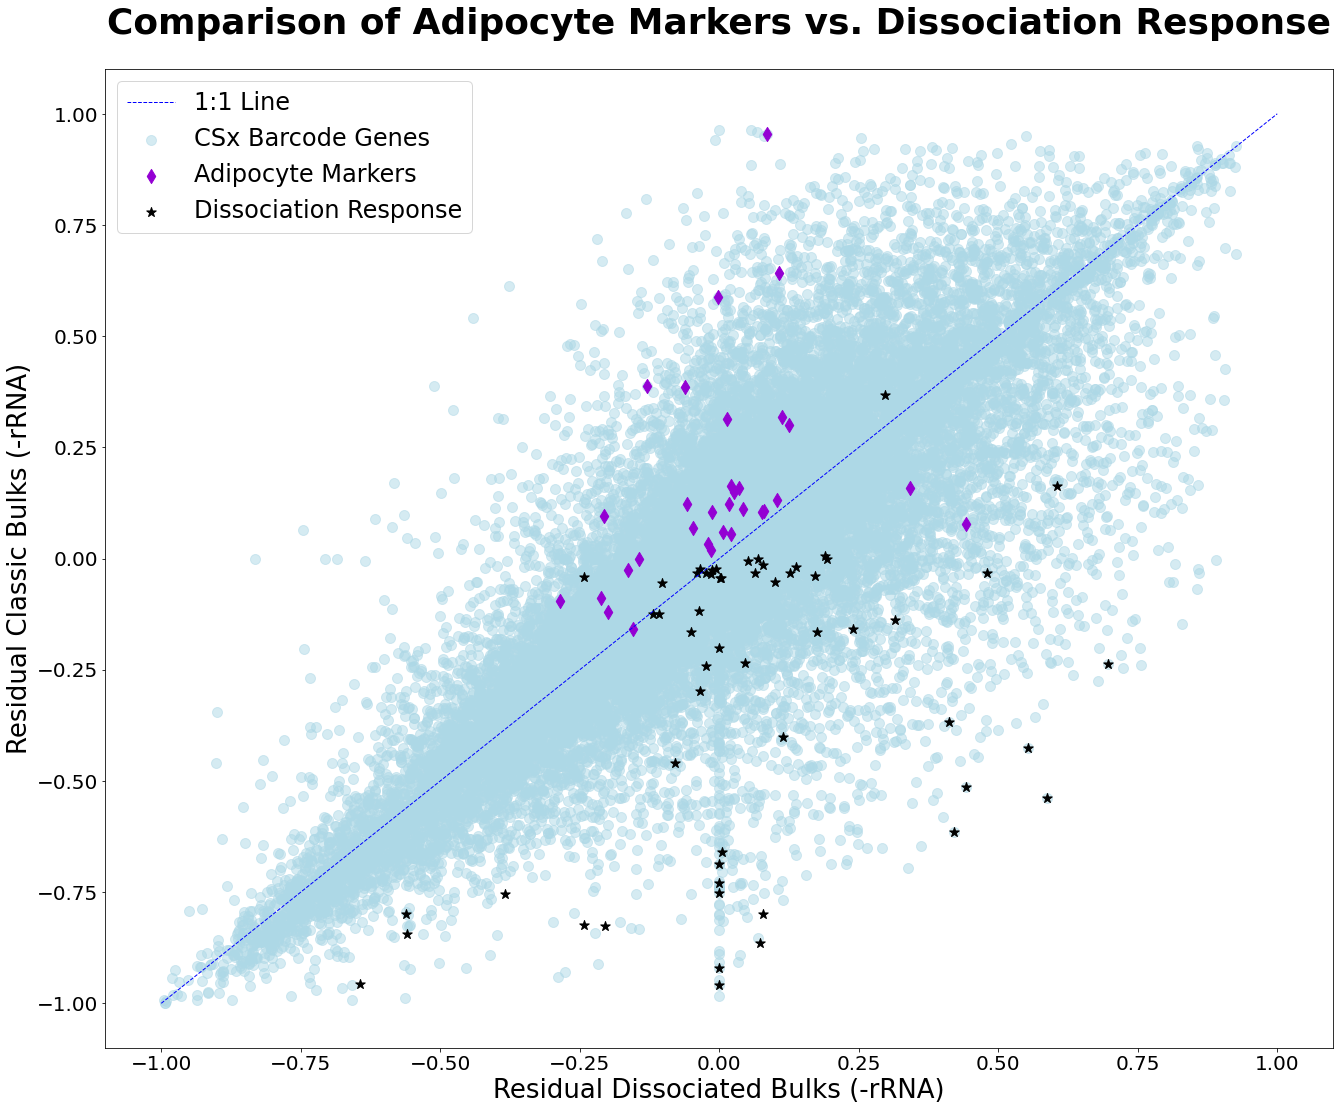

In [48]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(22, 18))

# Plot CIBERSORT genes
genes_of_interest = cibersort_genes
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue', s=100,
                    label='CSx Barcode Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', s=100,
                    label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*',  s=100,
                    label='Dissociation Response' if gene == diss_response[0] else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Comparison of Adipocyte Markers vs. Dissociation Response', 
                fontsize=36, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=26, fontname='Arial')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=26, fontname='Arial')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=24)

# Show the plot
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


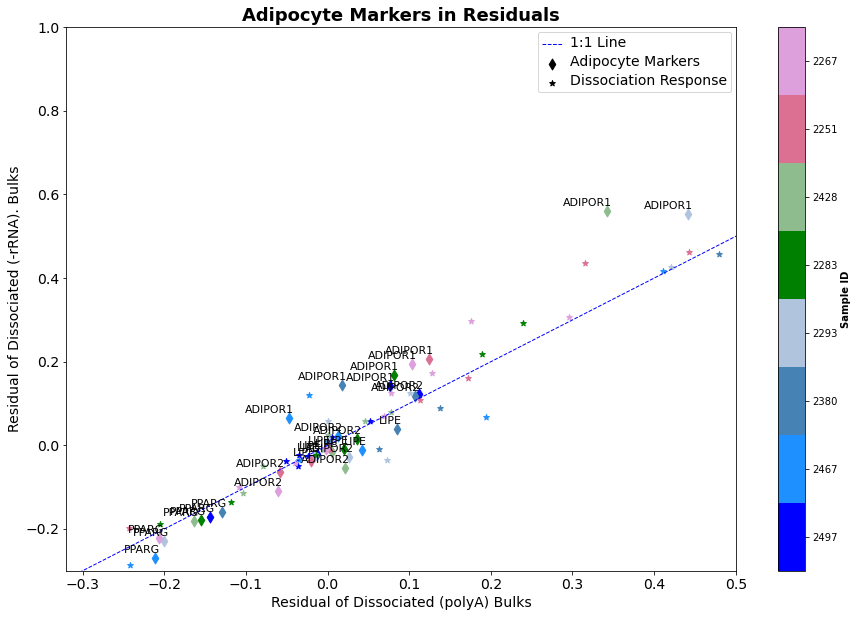

In [50]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_bulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 110

# Create a sc_atter plot with labels for multiple genes
plt.figure(figsize=(28,19))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=220,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=25)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "",s=150)

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='black', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals by Sample',  fontsize=46, fontname='Arial', fontweight='bold', x=0.5, y=1.0003)
plt.ylabel('Residual Values of Classic Bulks (-rRNA)', fontsize=26, fontname='Arial')
plt.xlabel('Residual Values of Dissociated Bulks (-rRNA)', fontsize=26, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(24)
    text.set_fontname('Arial')

#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)),label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold', fontsize=34)
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Set colorbar tick font size
colorbar.ax.tick_params(labelsize=30)

plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Add legend
plt.legend(fontsize=34, markerscale=1)

# Show the plot
plt.show()


## Top Genes per Sample's Residual:

Analyzing the main genes in the Residual of the samples with high adipocyte markers:

In [51]:
# Extract the top genes
top_genes_per_sample_bulk = pd.DataFrame()
for num in range(0,8):

    row = residuals_bulks.values[num, :]  

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  
    top_genes_per_sample_bulk[num] = gene_names_top_10
top_genes_per_sample_bulk.columns = sample_ids
top_genes_per_sample_bulk                                

2497        2467     2380     2293     2283      2428     2251     2267
0   NBEAL2    TMEM132C     GPAM    GABRE      TTN      ACPP    ITGB4     GPAM
1      TTN  AC136475.3       PC   NUP210  TMEM63A     GABRE     TEP1      TTN
2    STAB1       GABRE     LIPE     HID1     DTX4     CLCN5   NBEAL2    PTPRF
3    F13A1  MIRLET7BHG    MARC1     LY75    F13A1  B4GALNT3    ABCC5    ITPR3
4  RAPGEF3     TMEM63A      TTN   NBEAL2  PLEKHG5   TSNARE1   ATP8B2   NBEAL2
5    PLCG1        LY75  TNFSF14    PTPRS    WDR91     ITGA9    OBSCN  SIGLEC1
6    CD163     PLEKHA6   PLXNA4  NADSYN1    OBSCN      DNM1    MEGF6   HEATR1
7    KMT2D       OBSCN   RETSAT    KMT2D   NBEAL2     CMYA5    PTPRF    PTPRS
8     MYRF       WDR91      PPL     NEO1      SRC    MPPED2      TTN    KMT2D
9      CGN       CIITA    PTPRF     PSD4    PLCG1   TMEM63A  SIGLEC1    MUC16

In [52]:
# Extract the top genes
top_genes_per_sample_dissbulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_dissbulks.values[num, :]

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices] 

    top_genes_per_sample_dissbulk[num] = gene_names_top_10
top_genes_per_sample_dissbulk.columns = sample_ids
top_genes_per_sample_dissbulk       

2497     2467     2380    2293     2283     2428     2251      2267
0    NBEAL2   CELSR1      PPL   OBSCN  TFCP2L1    GABRE      TTN       HK3
1     STAB1    OBSCN  TNFSF14   TUFT1  PLEKHG5  TFCP2L1   NBEAL2    NBEAL2
2      MYRF   NBEAL2    OBSCN  CELSR1    OBSCN  NECTIN4    ITGA3      PSD4
3     PLCG1    ABCC5    MEGF6   PLCG1   NBEAL2    OBSCN    PTPRF     KMT2D
4   RAPGEF3   SEMA3B    PTPRF    YOD1   SNHG22     PSD4    KMT2D  ARHGEF17
5    SEC24C  RAPGEF3   SEMA3B    PSD4   SEMA7A    PLCG1     H6PD    AMOTL2
6    KLHL21     TEP1      TTN  NUP210   CELSR1   CELSR1   AMOTL2    CHI3L1
7  MAPK8IP3    PLCG1    ITGB4  NBEAL2    STAB1     YOD1    PLCG1        CP
8     NISCH  SIGLEC1    ITGA3   KMT2D     LDB1    TUFT1  FAM110C     THSD4
9     OBSCN    KMT2D    ITPR3   LAMB3  TMEM63A   PRSS22  NADSYN1     MUC16

## Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


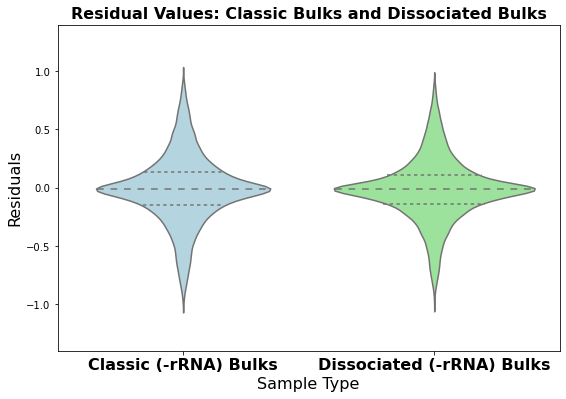

In [53]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

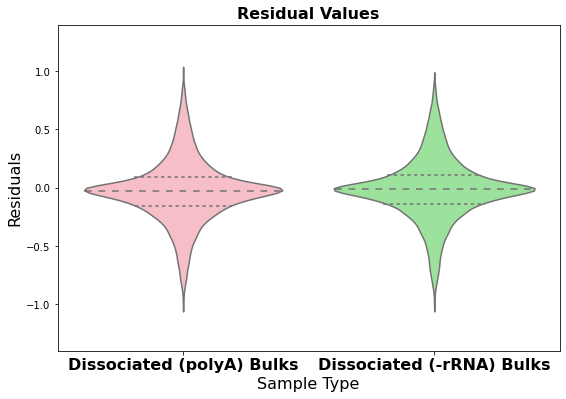

In [54]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = residuals_disspolyabulks.values.flatten()
bulk_type_2 = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=[ 'lightpink','lightgreen'])
# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

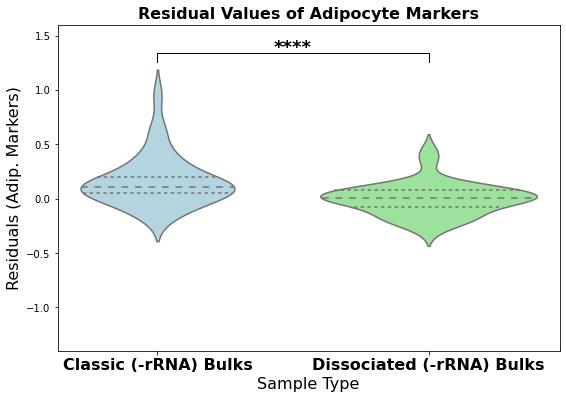

In [55]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue','lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.15, max_val+0.22
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


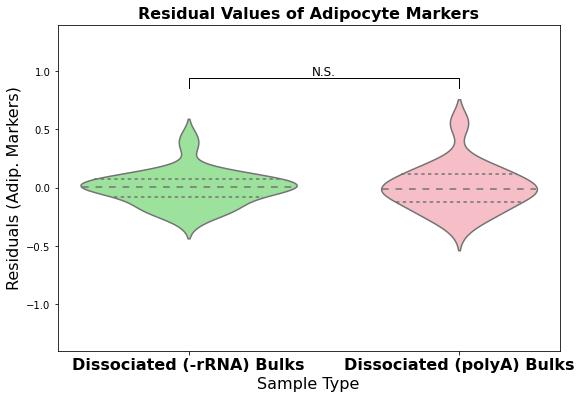

In [56]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_dissbulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38# Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

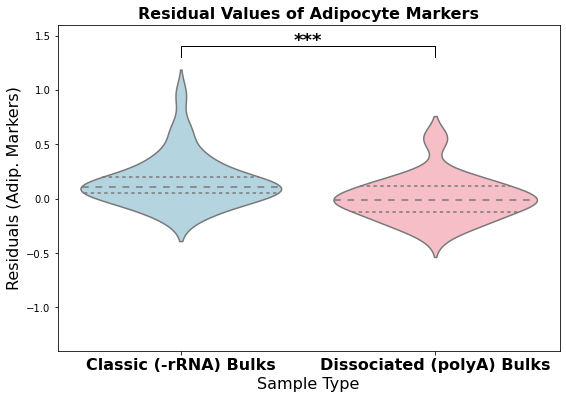

In [57]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(classic_bulks_values) +
                                  ['Bulktype2'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

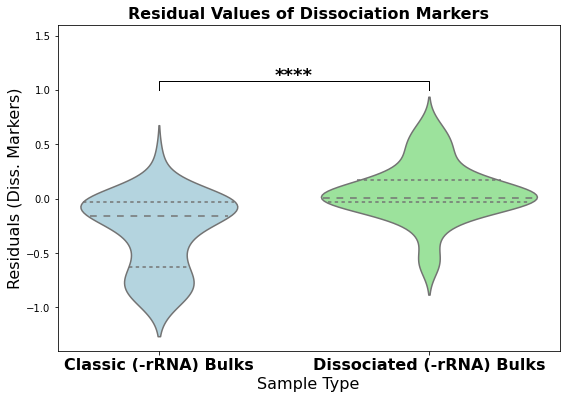

In [58]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    
plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


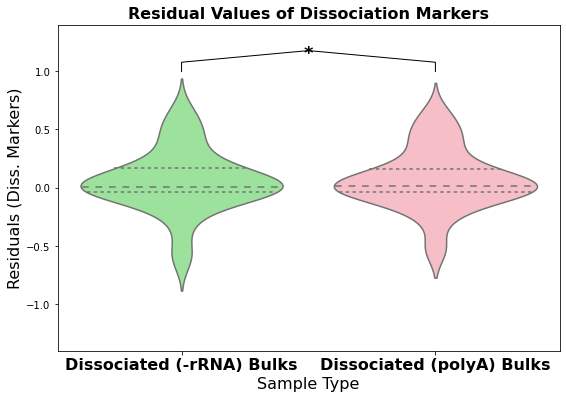

In [59]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_dissbulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

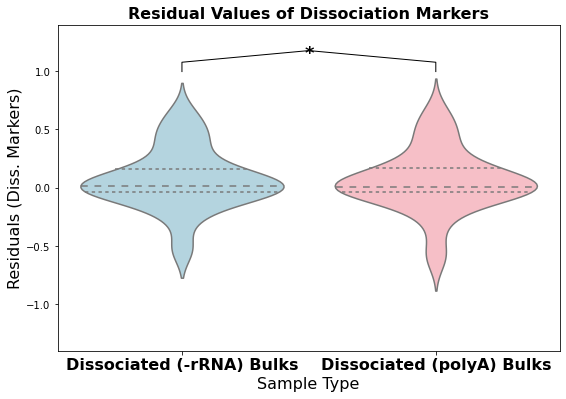

In [60]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_disspolyabulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

## PCA

Combo (Classic and Dissociated (-rRNA together))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


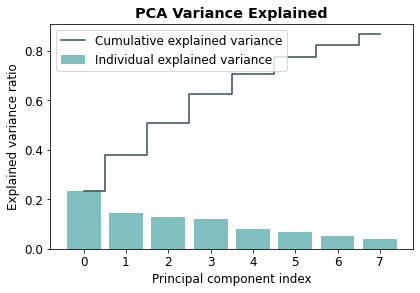

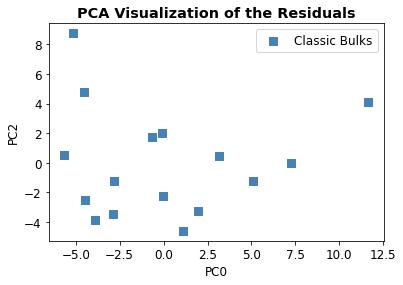

Component_0 Component_1 Component_2 Component_3 Component_4 Component_5  \
0          VTCN1     FAM107A        GPAM         PPL      KIF26B       LAMA3   
1          PELI2      MFSD2A        SAA1       F13A1       INHBA        NAV2   
2        ZNF780B    ANKRD33B      PLXNA4       DAPK1      PDLIM3       NRXN3   
3        TMEM63A      B3GNT5      CLSTN2        SDC1       UNC5B  AC136475.3   
4     MIRLET7BHG     TFCP2L1        ACO1      KCNMA1     BHLHE41      RASSF8   
...          ...         ...         ...         ...         ...         ...   
4579     ZC3H12A      BTN3A2       CLDN4       IGHG1     FAM110C       PELI2   
4580       CLDN1       BIRC3        PLK2      FBXO32        CCL2      PGRMC1   
4581       CXCL8      BTN3A1         BGN        IGKC       MECOM       SESN3   
4582        RND3         EHF  AC245014.3      IFITM1         ADM      NUP210   
4583     ALDH1A3        LY75       SMAD7      CHI3L1       THSD4       PTGDS   

     Component_6 Component_7  
0          CLDN1        EYA2  
1          MYH11      RNF152  
2          MERTK        CDH6  
3         KCNMA1        ESR1  
4          IGLC3      SLC7A2  
...          ...         ...  
4579       STON2        KLK7  
4580      TUBA1B       RHPN2  
4581       STMN1         CGN  
4582        CD36        ASS1  
4583       ERAP2       KRT19  

[4584 rows x 8 columns]

In [61]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes   


In [62]:
# Separate the first and last 8 samples (by sample type)
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

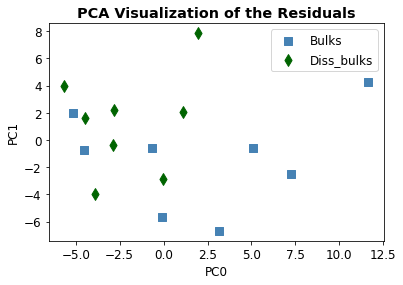

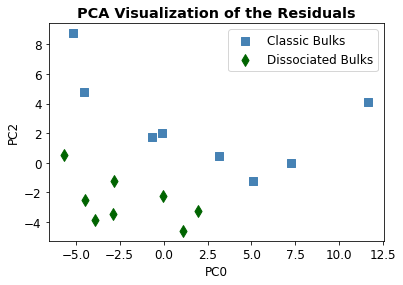

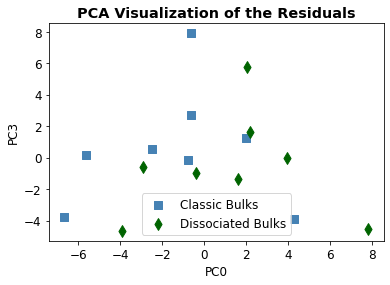

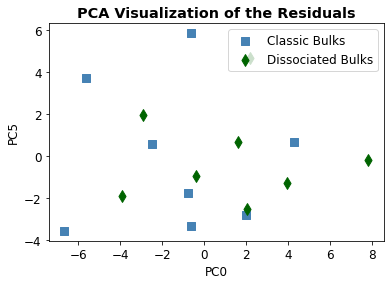

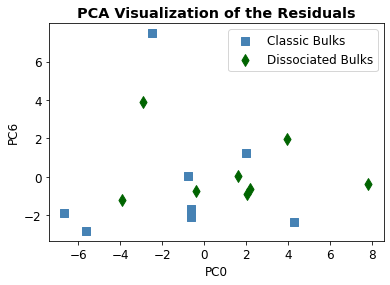

In [63]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


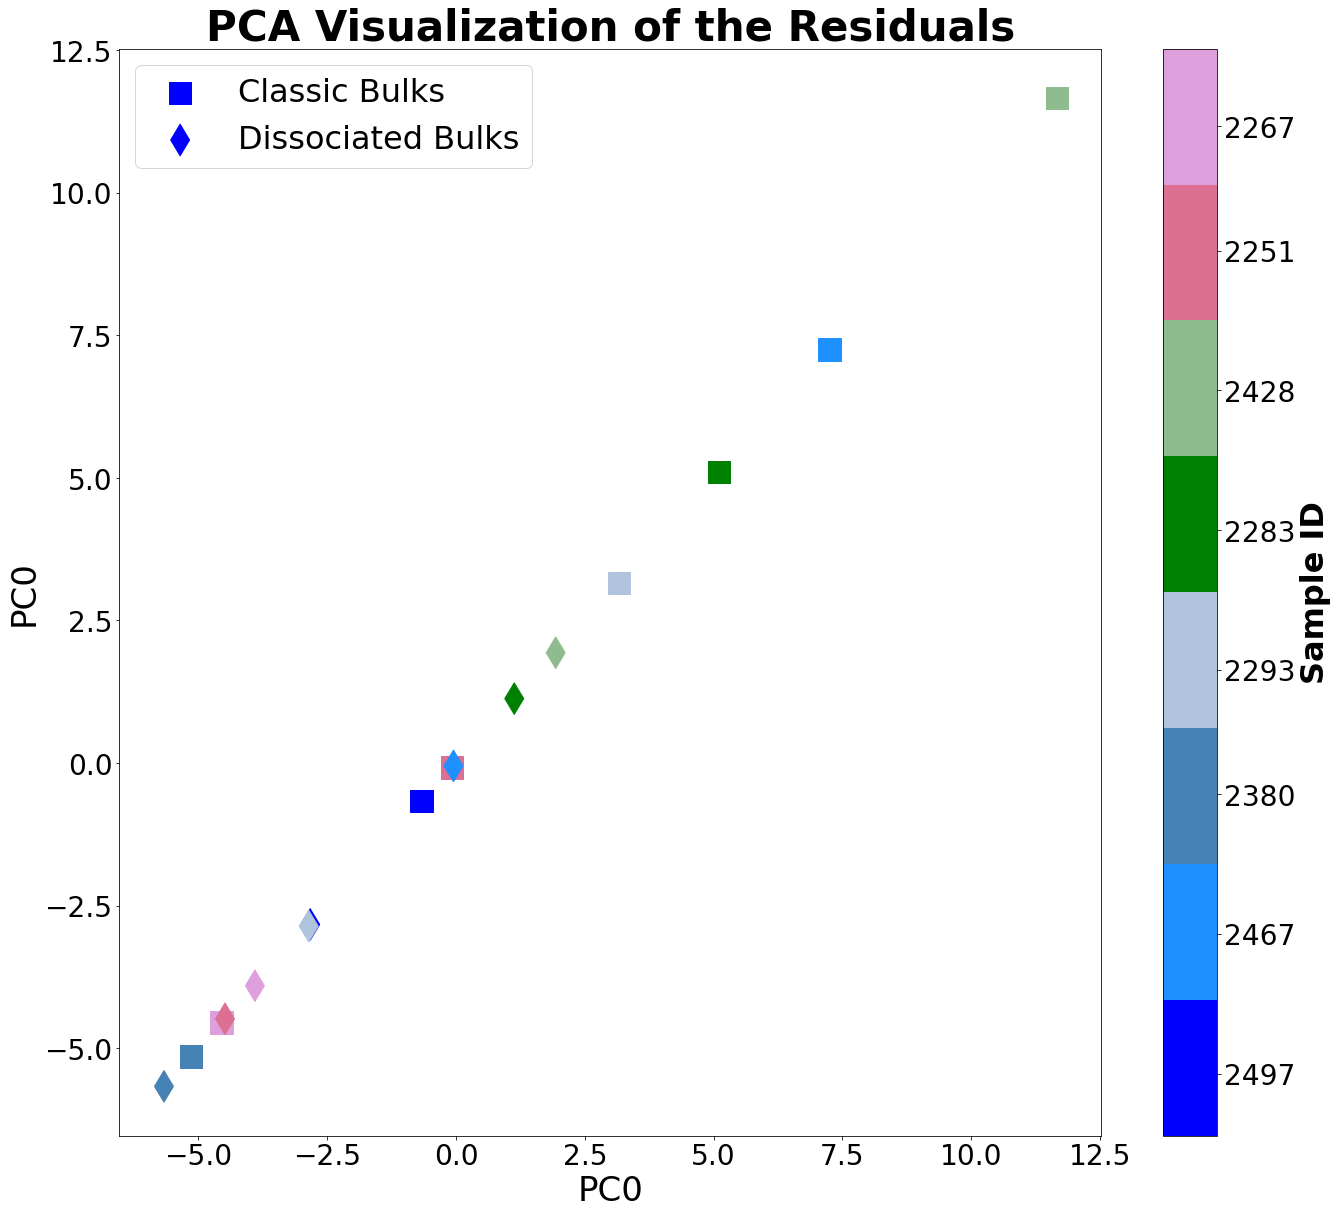

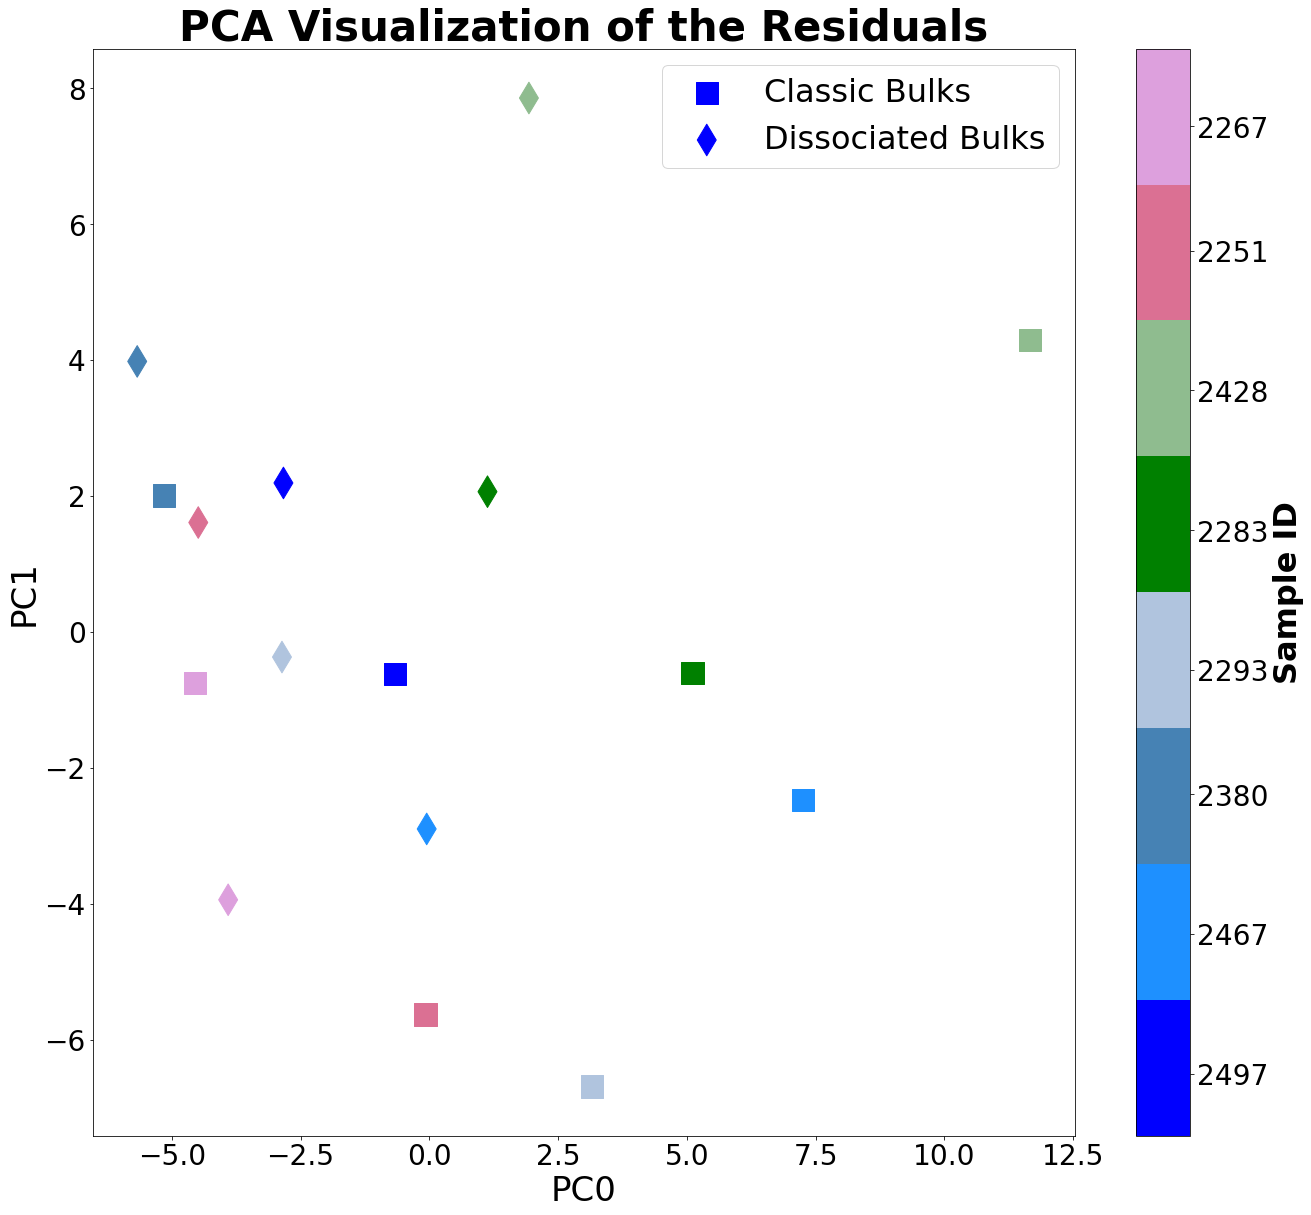

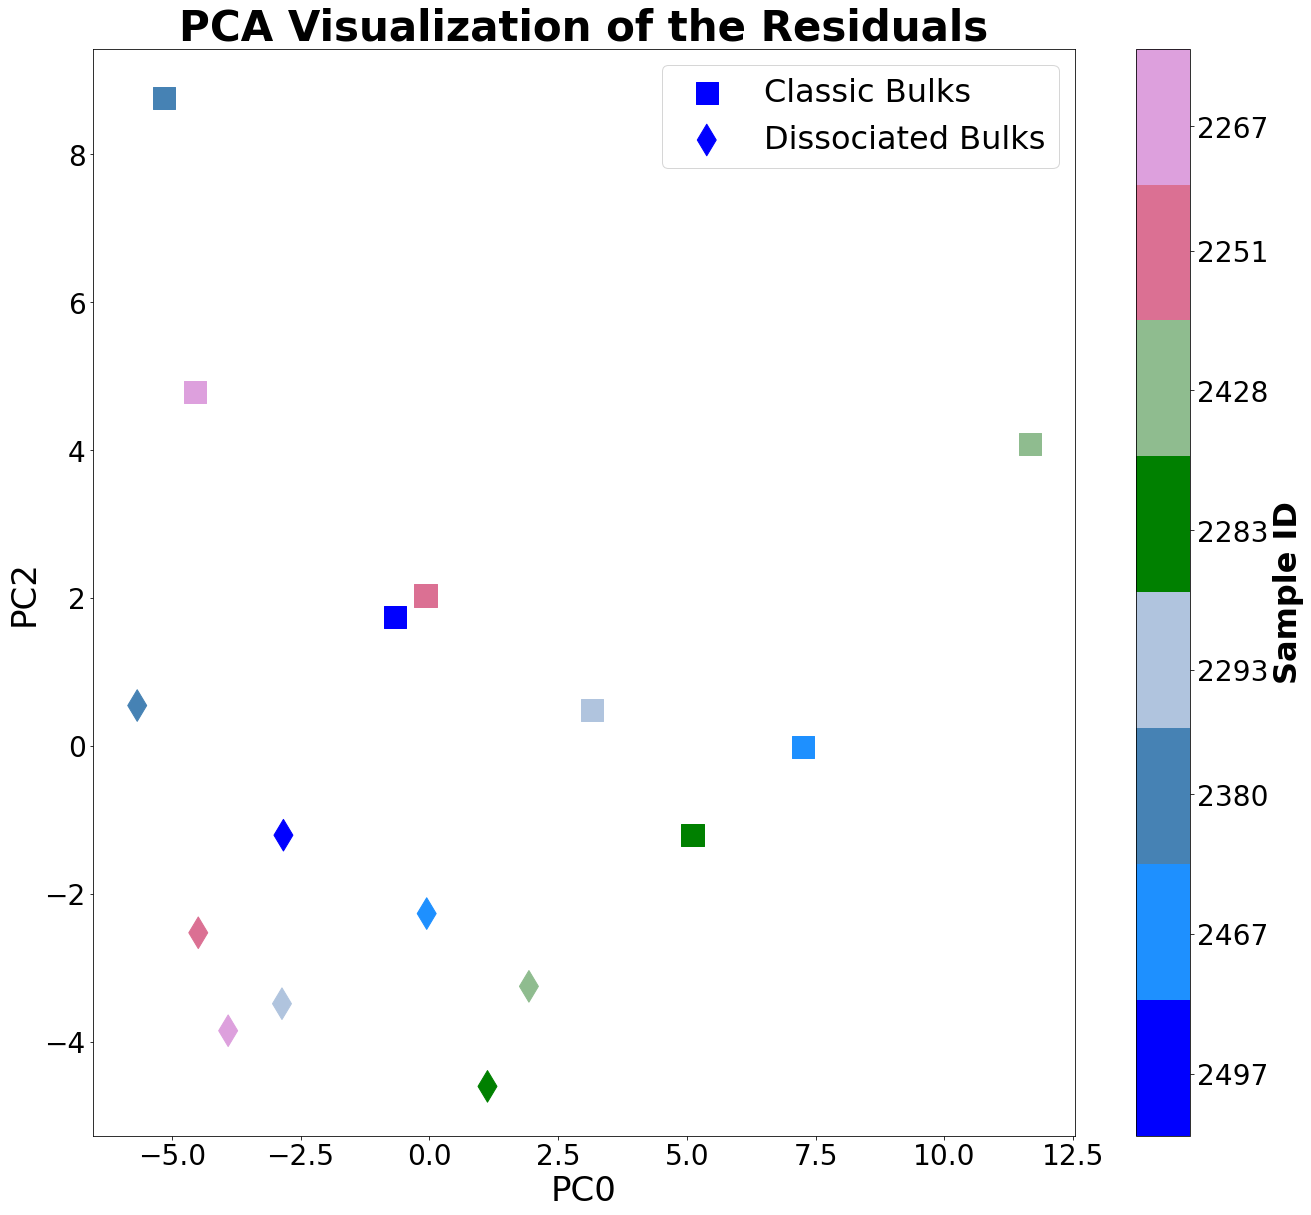

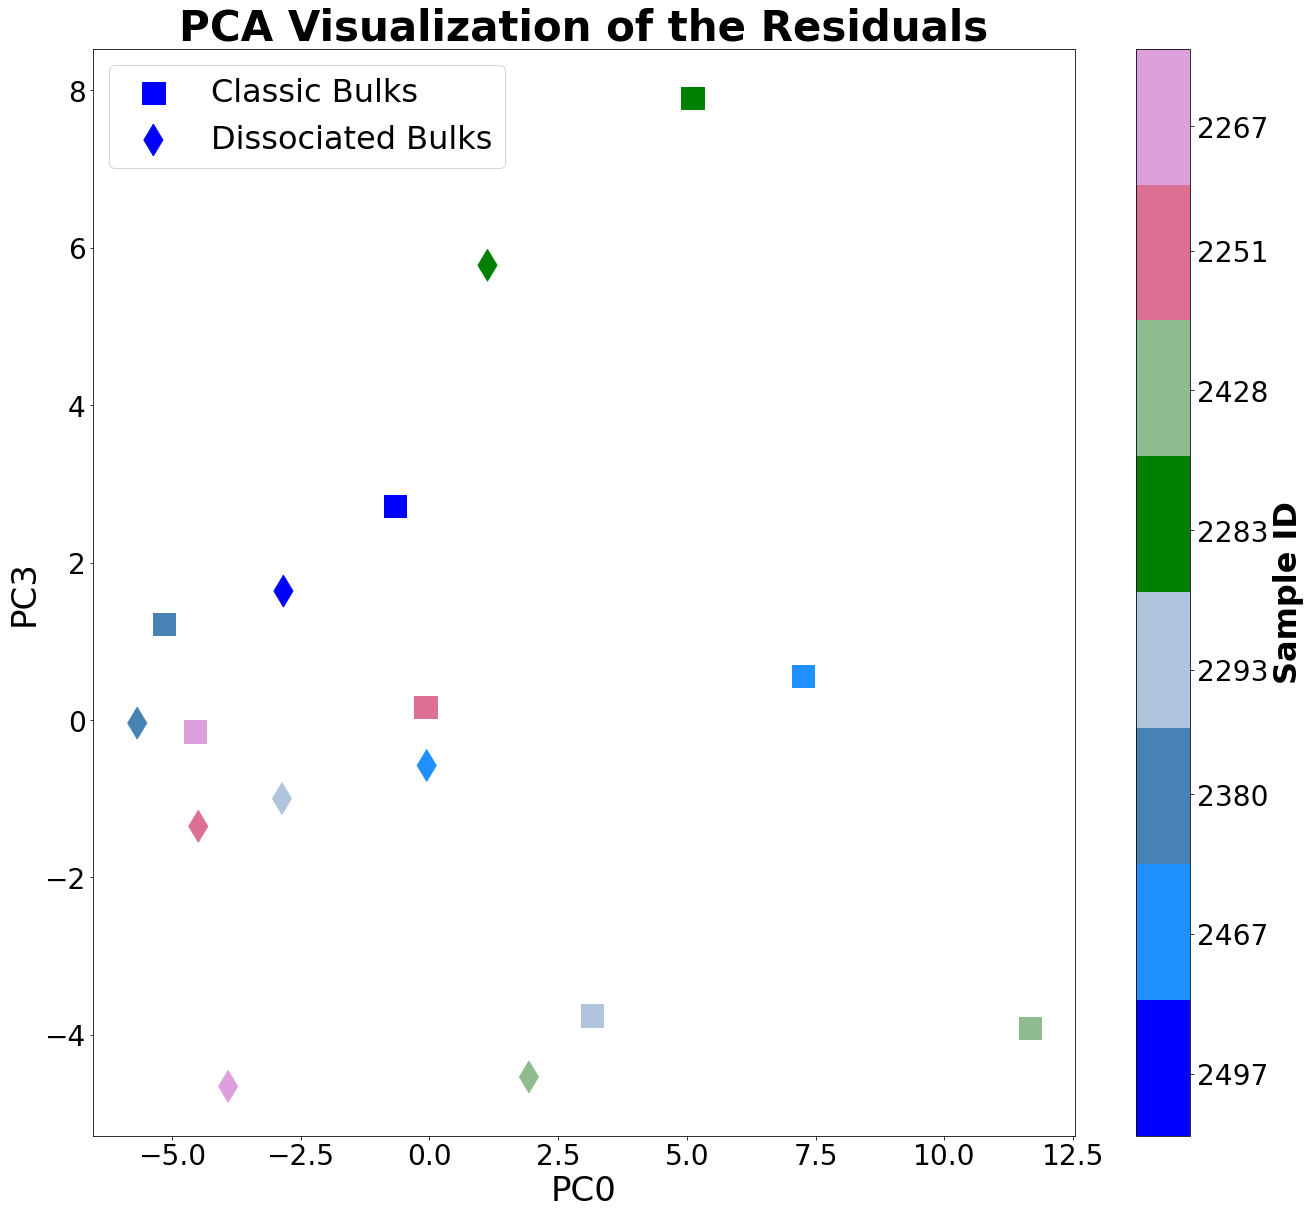

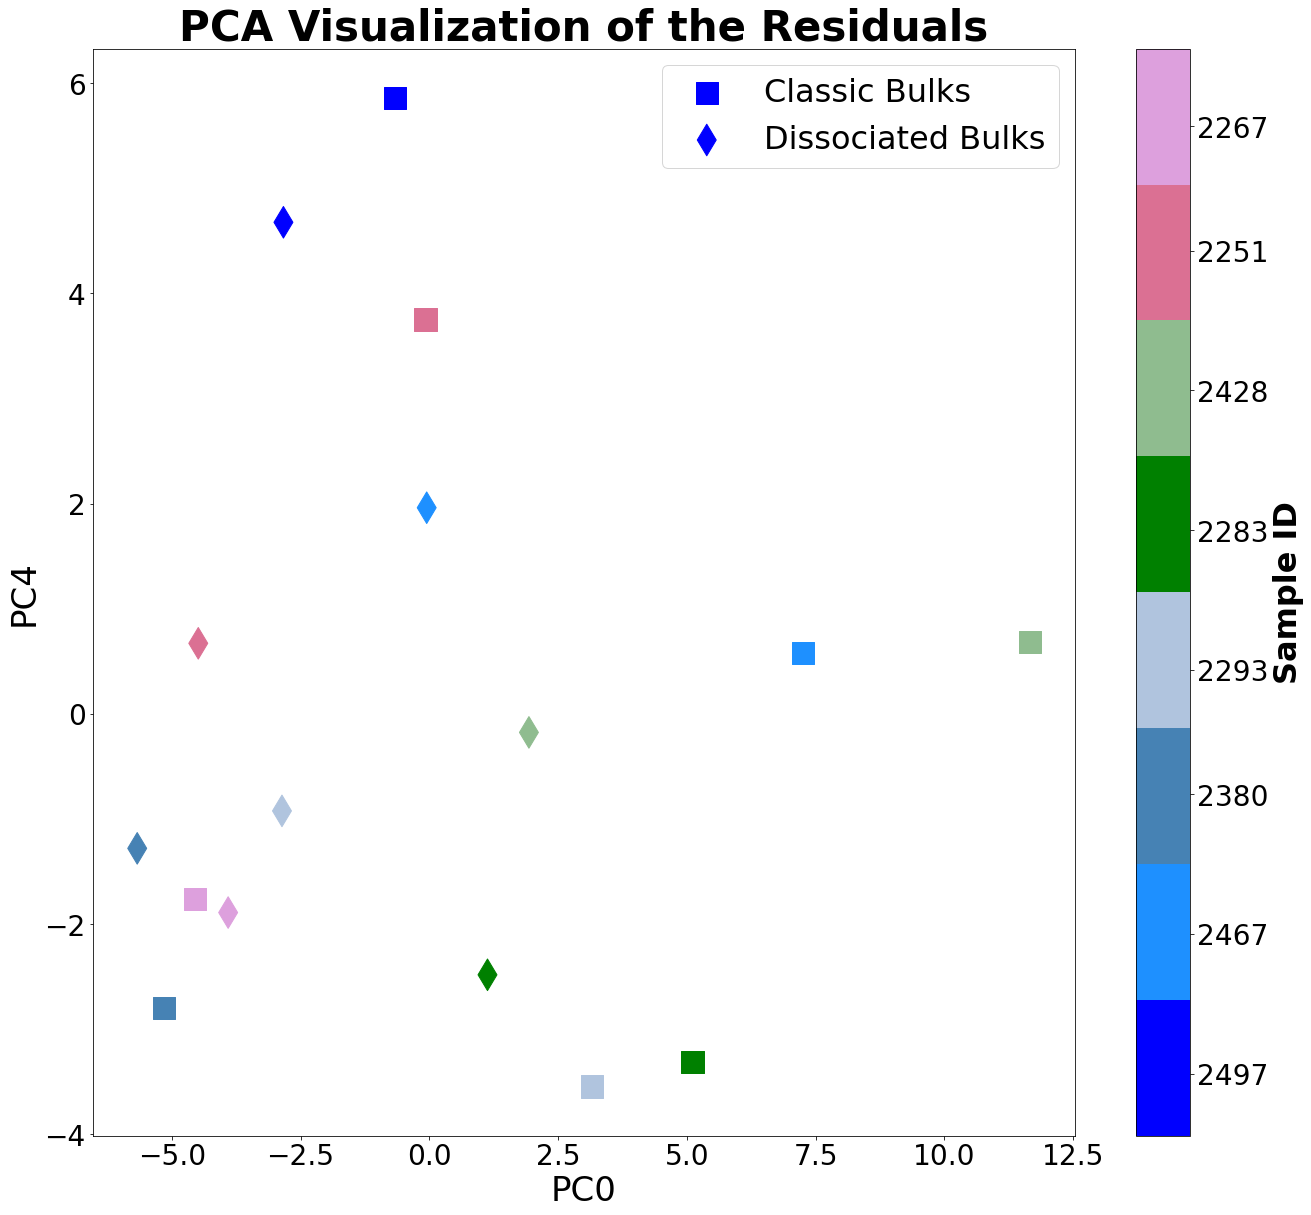

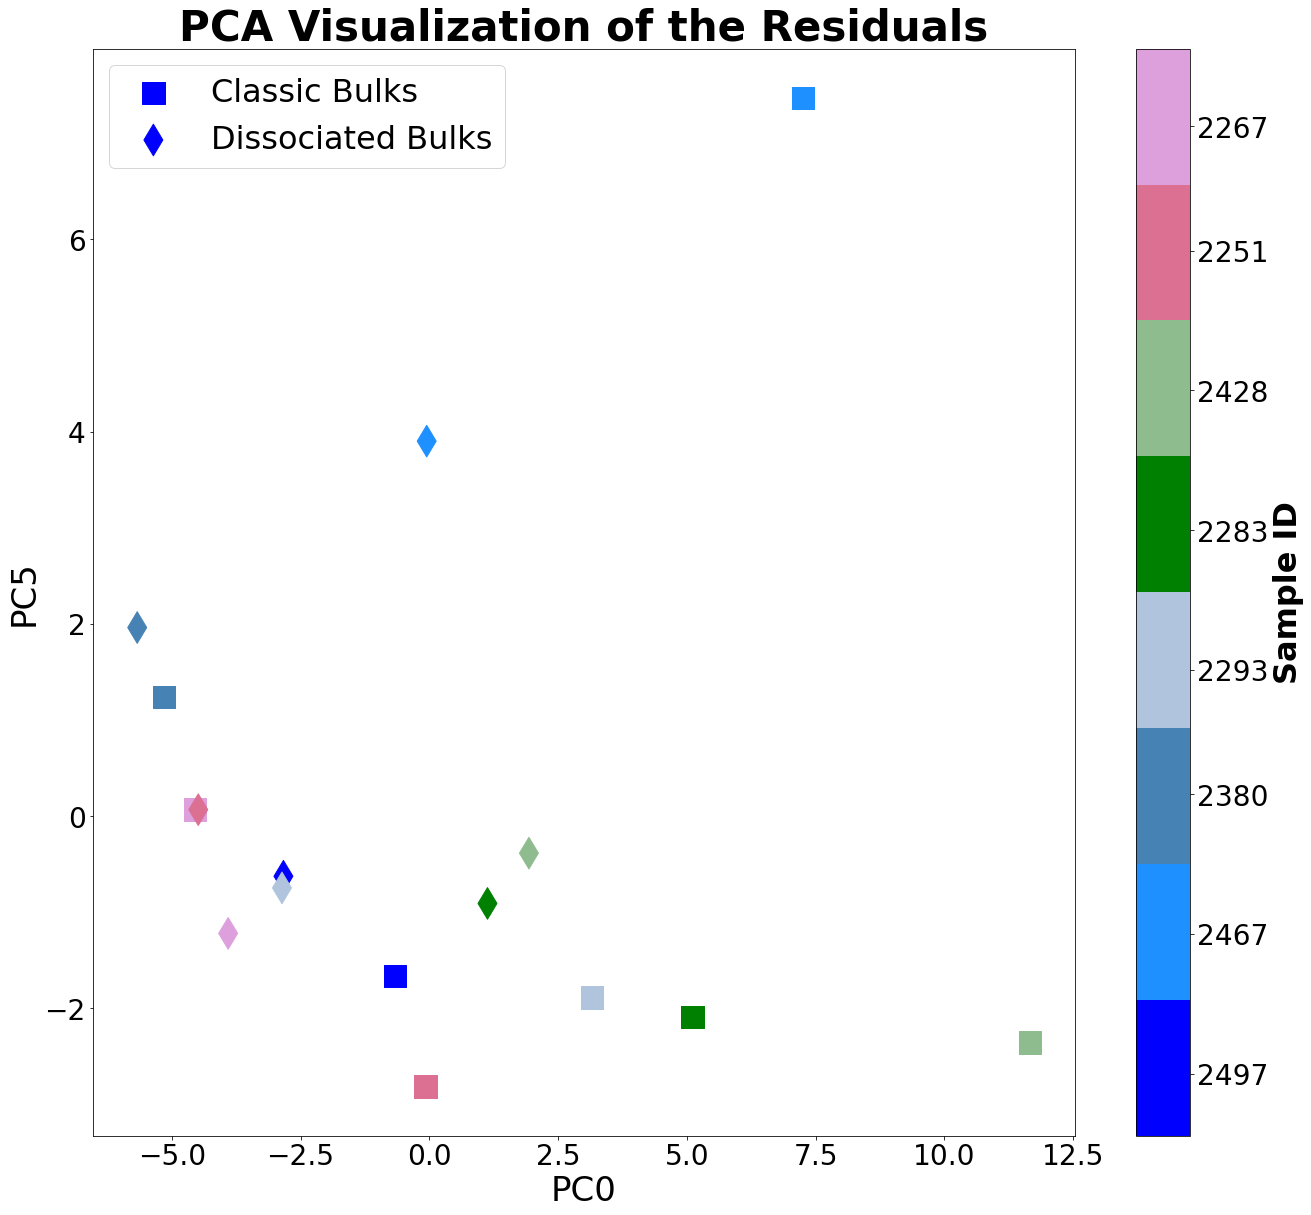

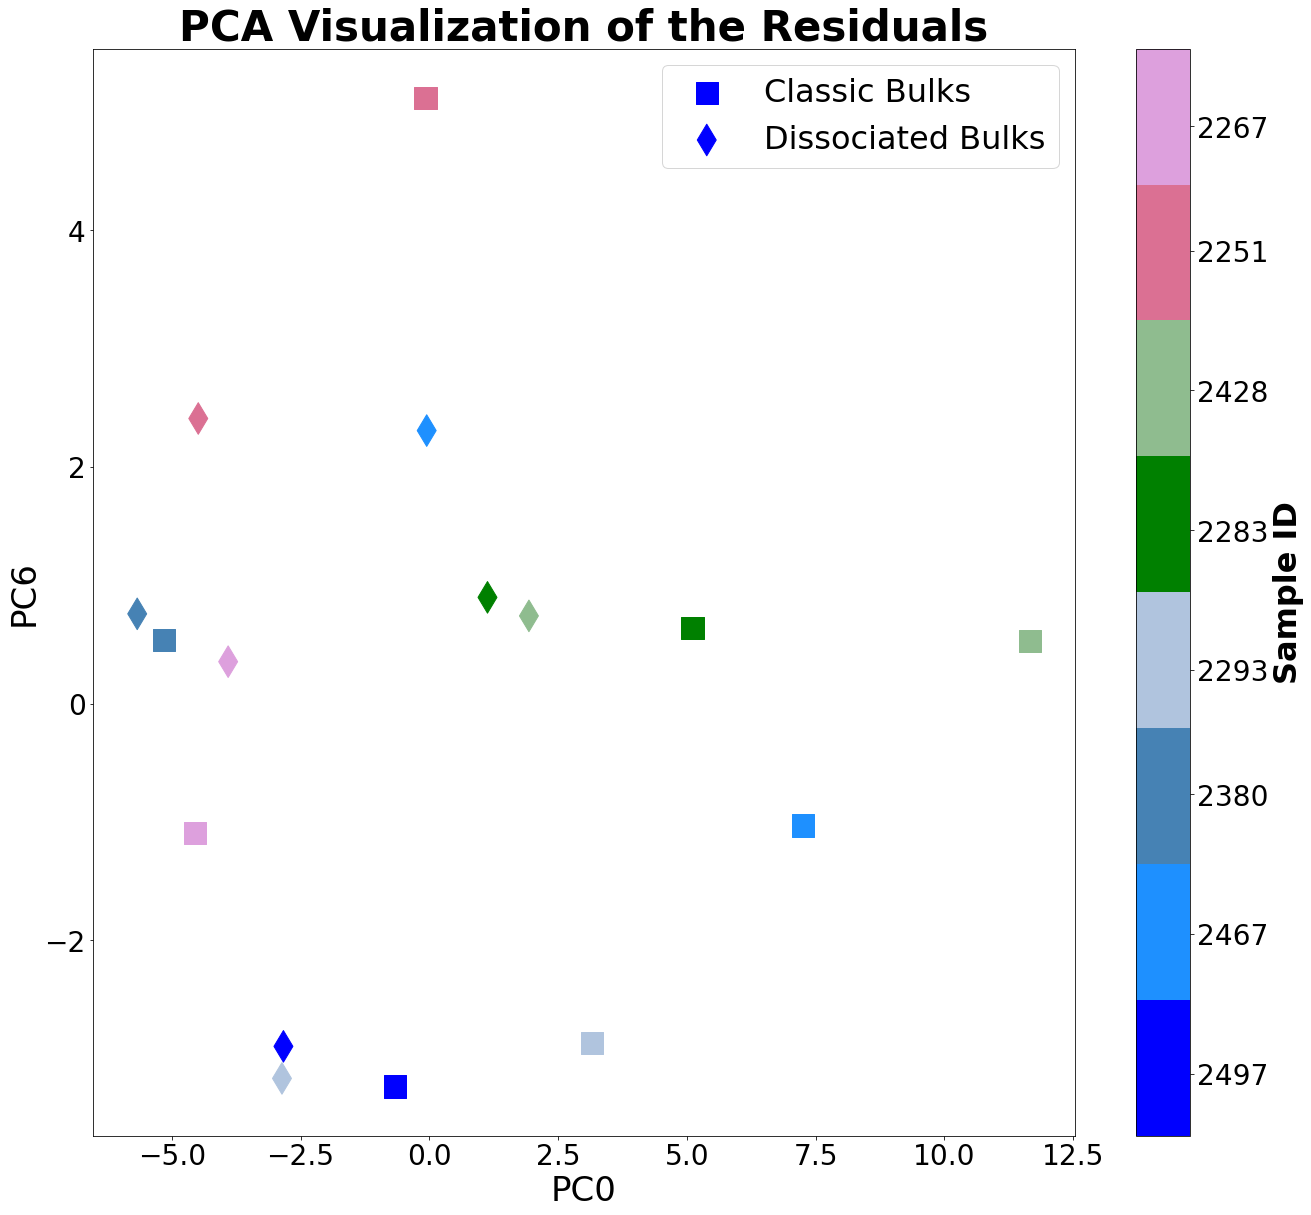

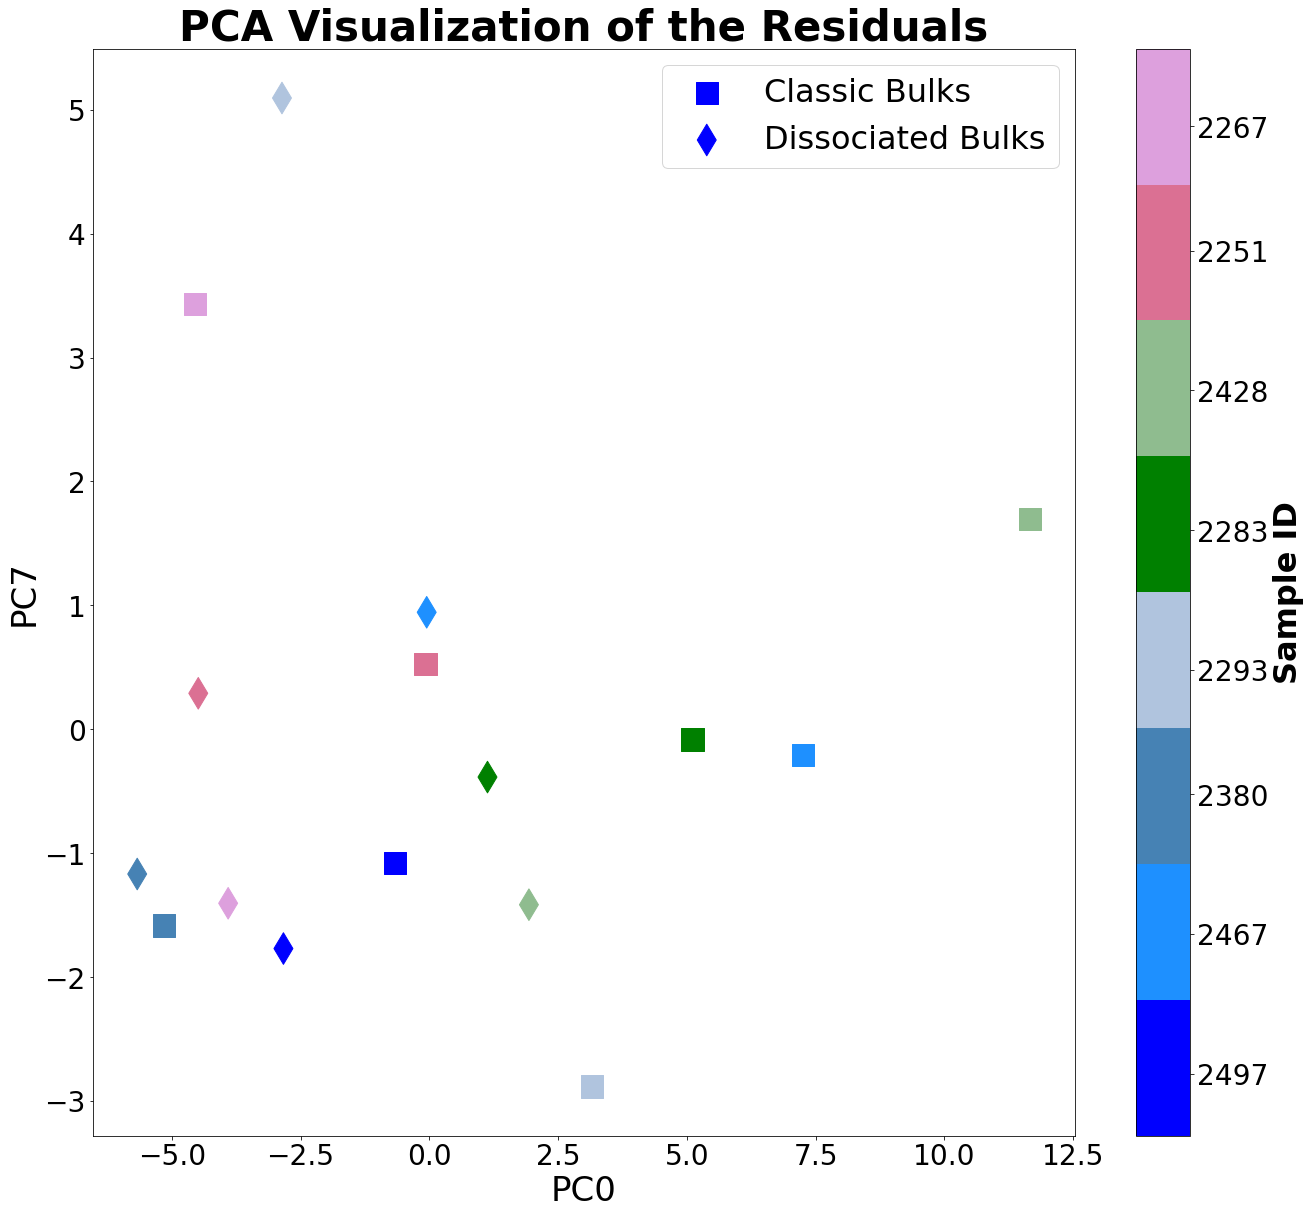

In [64]:
for idx in [0,1,2,3,4,5,6,7]:
    # Assuming `row_indices` contains the row indices of your samples
    row_indices = np.tile(range(1, 9), 2)
    plt.figure(figsize = (22,20))
    # Define custom colors
    custom_colors = ['blue','dodgerblue','steelblue','lightsteelblue','green','darkseagreen','palevioletred','plum']

    # Create a custom colormap
    cmap_custom = mcolors.ListedColormap(custom_colors)
    marker_size = 500

    # PCA Visualization
    scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, idx], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                                cmap=cmap_custom, marker='s', s=marker_size)
    scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, idx], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                                cmap=cmap_custom, marker='d', s=marker_size)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    # Add colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Sample ID', fontsize=32, fontweight='bold')

    # Adjust colorbar ticks to be centered between colors
    cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
    cbar.set_ticklabels(sample_ids )
    cbar.ax.tick_params(labelsize=28)
    # Change the color of the little marker in the legend
    # Change the color of the marker in the legend using a custom handler
    legend = plt.legend(fontsize=32)

    plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=42, fontname='Arial')
    plt.xlabel("PC0", fontsize=34, fontname='Arial')
    plt.ylabel(f"PC{idx}", fontsize=34, fontname='Arial')
    plt.show()

In [65]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = pd.DataFrame(pca_results)
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     1.835617  0.087743
1        1.0    -1.413963  0.179224
2        2.0     4.062374  0.001165
3        3.0     0.667655  0.515209
4        4.0    -0.093554  0.926789
5        5.0    -0.375435  0.712964
6        6.0    -0.294699  0.772549
7        7.0    -0.043134  0.966204
Components with significantly different means:
   Component  T-Statistic   P-Value
2        2.0     4.062374  0.001165


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


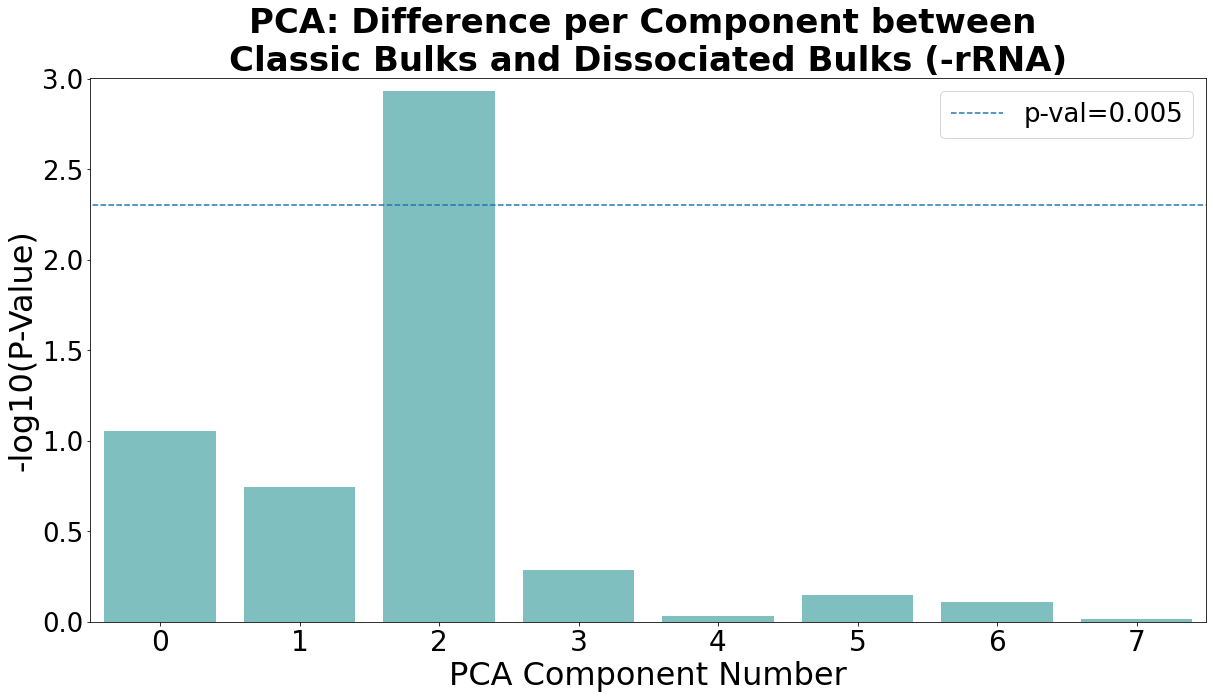

In [66]:
# Bar plot for each component
plt.figure(figsize=(20, 10))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)
plt.xlabel('PCA Component Number', fontsize=32, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=32, fontname='Arial')
plt.plot([-1,0,1,2,3,4,5,6,7,8],np.repeat(-np.log10(0.005),10),linestyle='--', label='p-val=0.005')
plt.title('PCA: Difference per Component between \nClassic Bulks and Dissociated Bulks (-rRNA)', 
            fontsize=34, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6,7], fontsize=28)
plt.yticks(fontsize=26)
plt.ylim(0,max(-np.log10(results['P-Value']))+0.07)
plt.legend(fontsize=26)
plt.xlim(-0.5,7.5)
plt.show()

In [90]:
# The sheets on the Excel
''' NOTE: You'll need to run GOrilla on these lists for the next part!'''
added = "PCA_genes_residuals_combo.xlsx"
sheet_names = ['GOPROCESS_Component_0','GOPROCESS_Component_1','GOPROCESS_Component_2','GOPROCESS_Component_3']  

In [71]:
pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", f"{added}")
pca_genes.to_excel(pca_name_path, sheet_name = "PCA_Components_Genes")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


filtered: (19, 11)


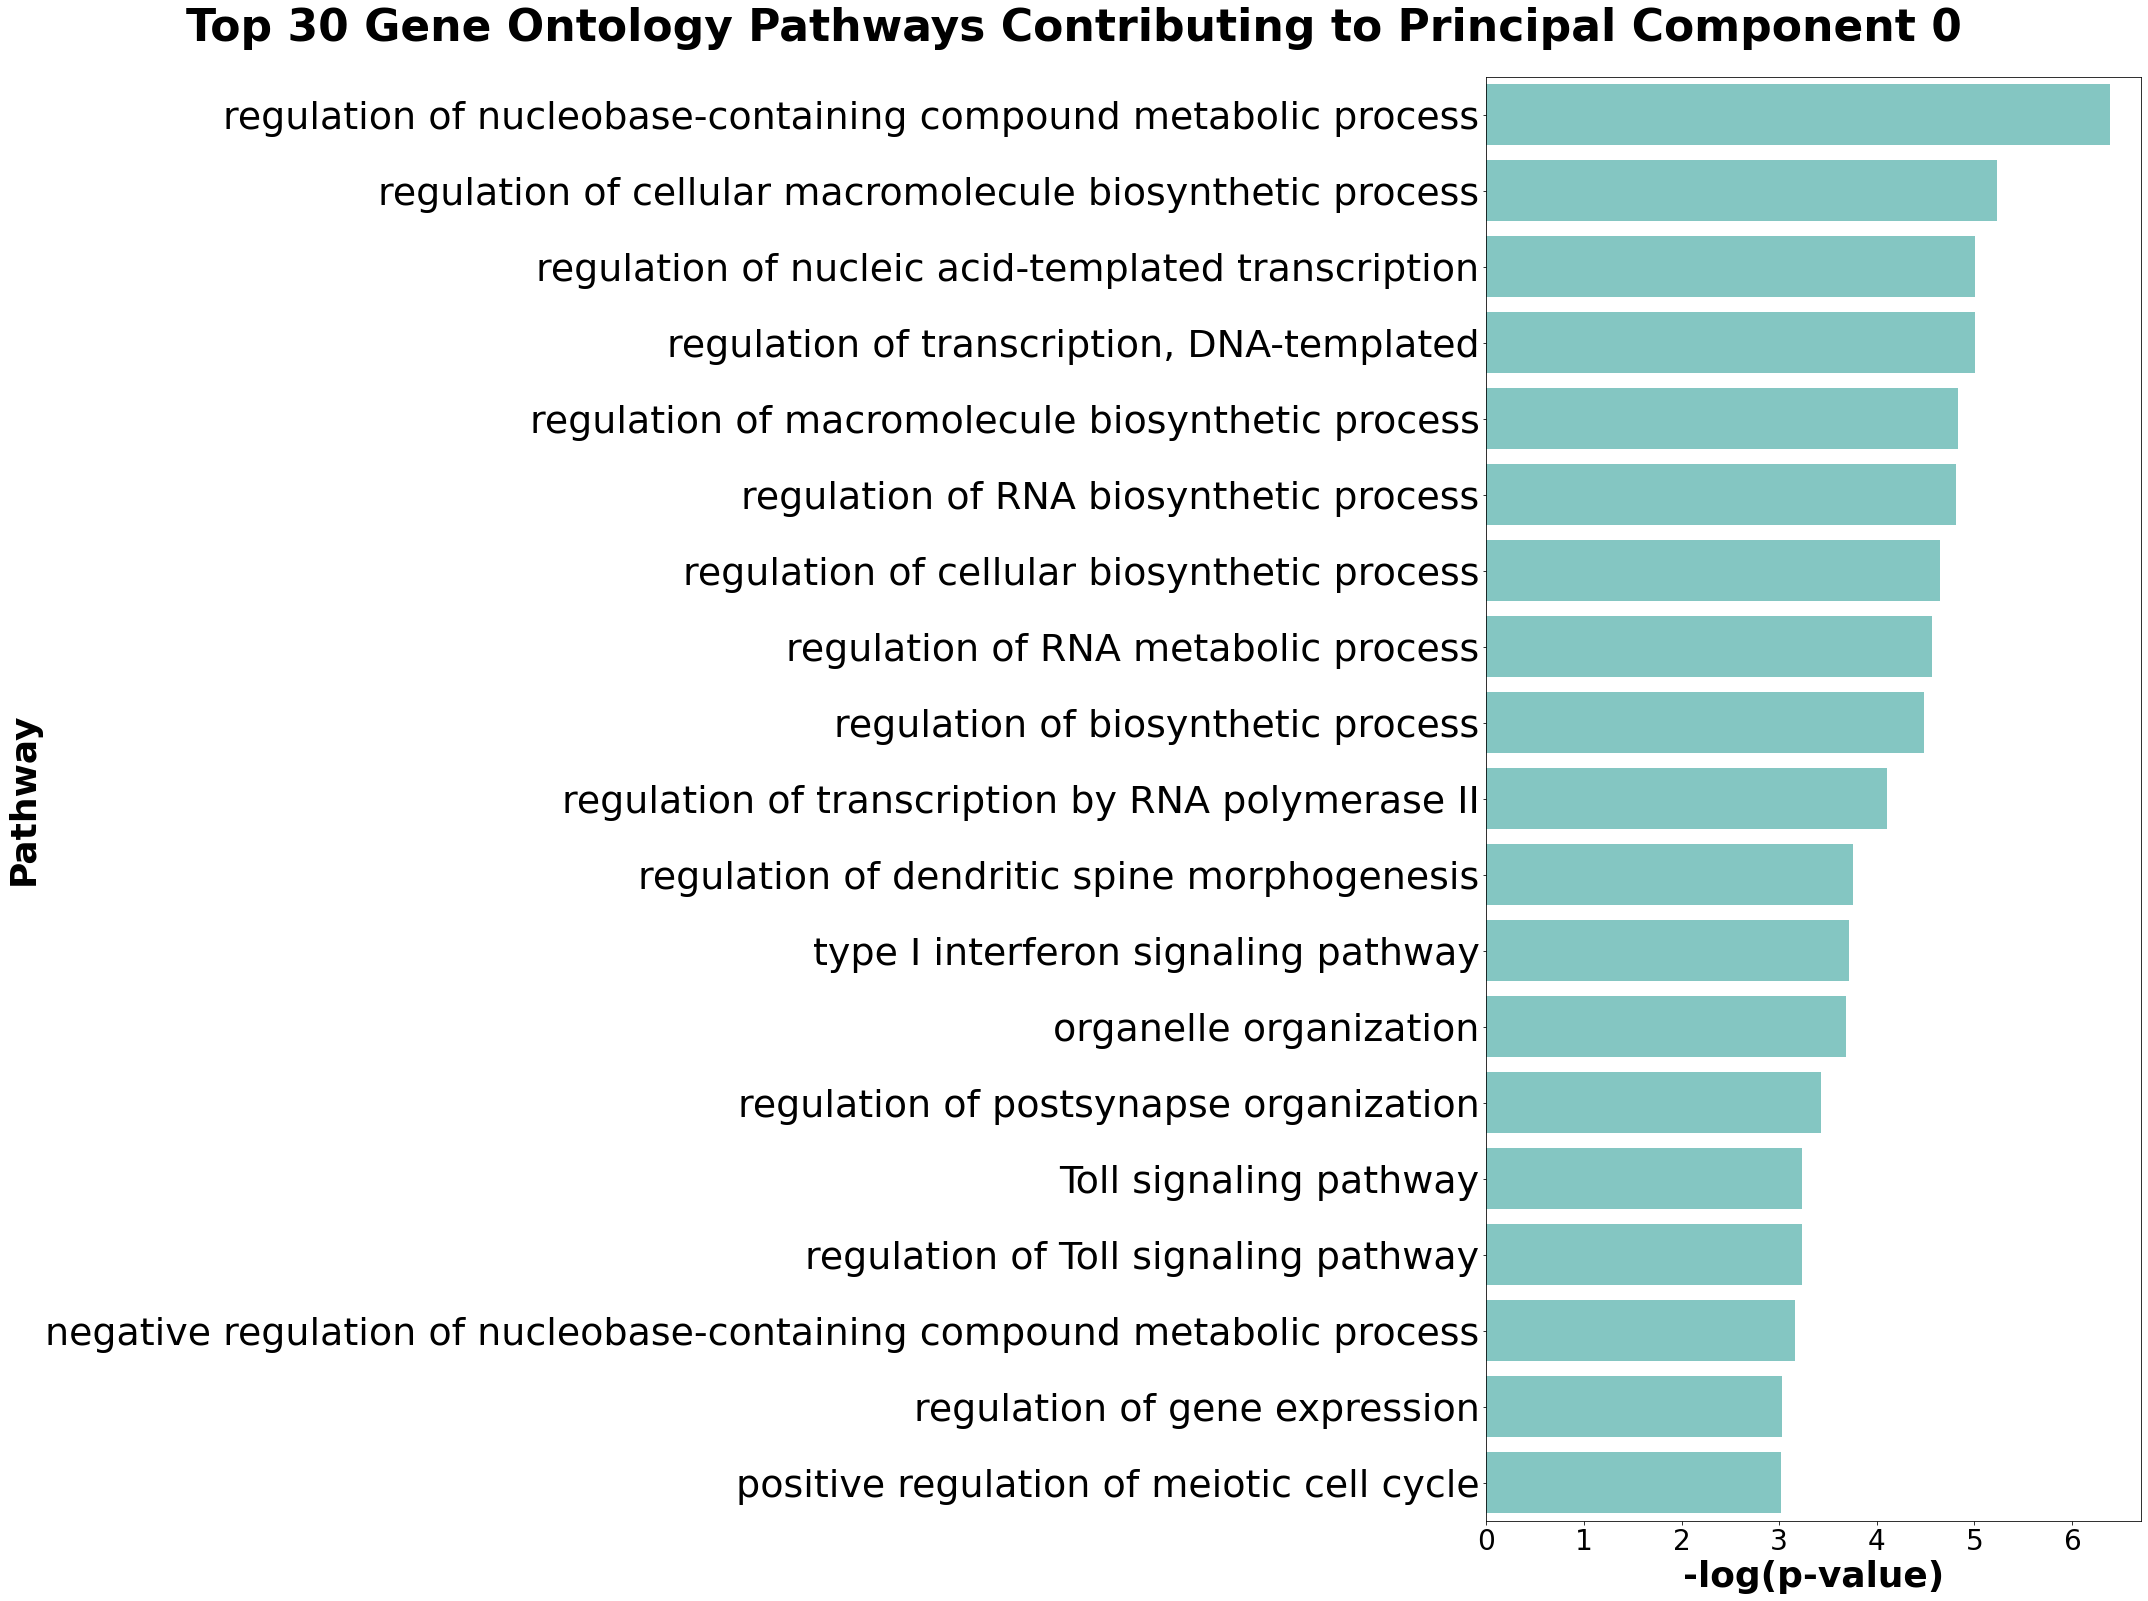

filtered: (30, 11)


/projects/aivich@xsede.org/code-server/tmp/ipykernel_2070664/607945358.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


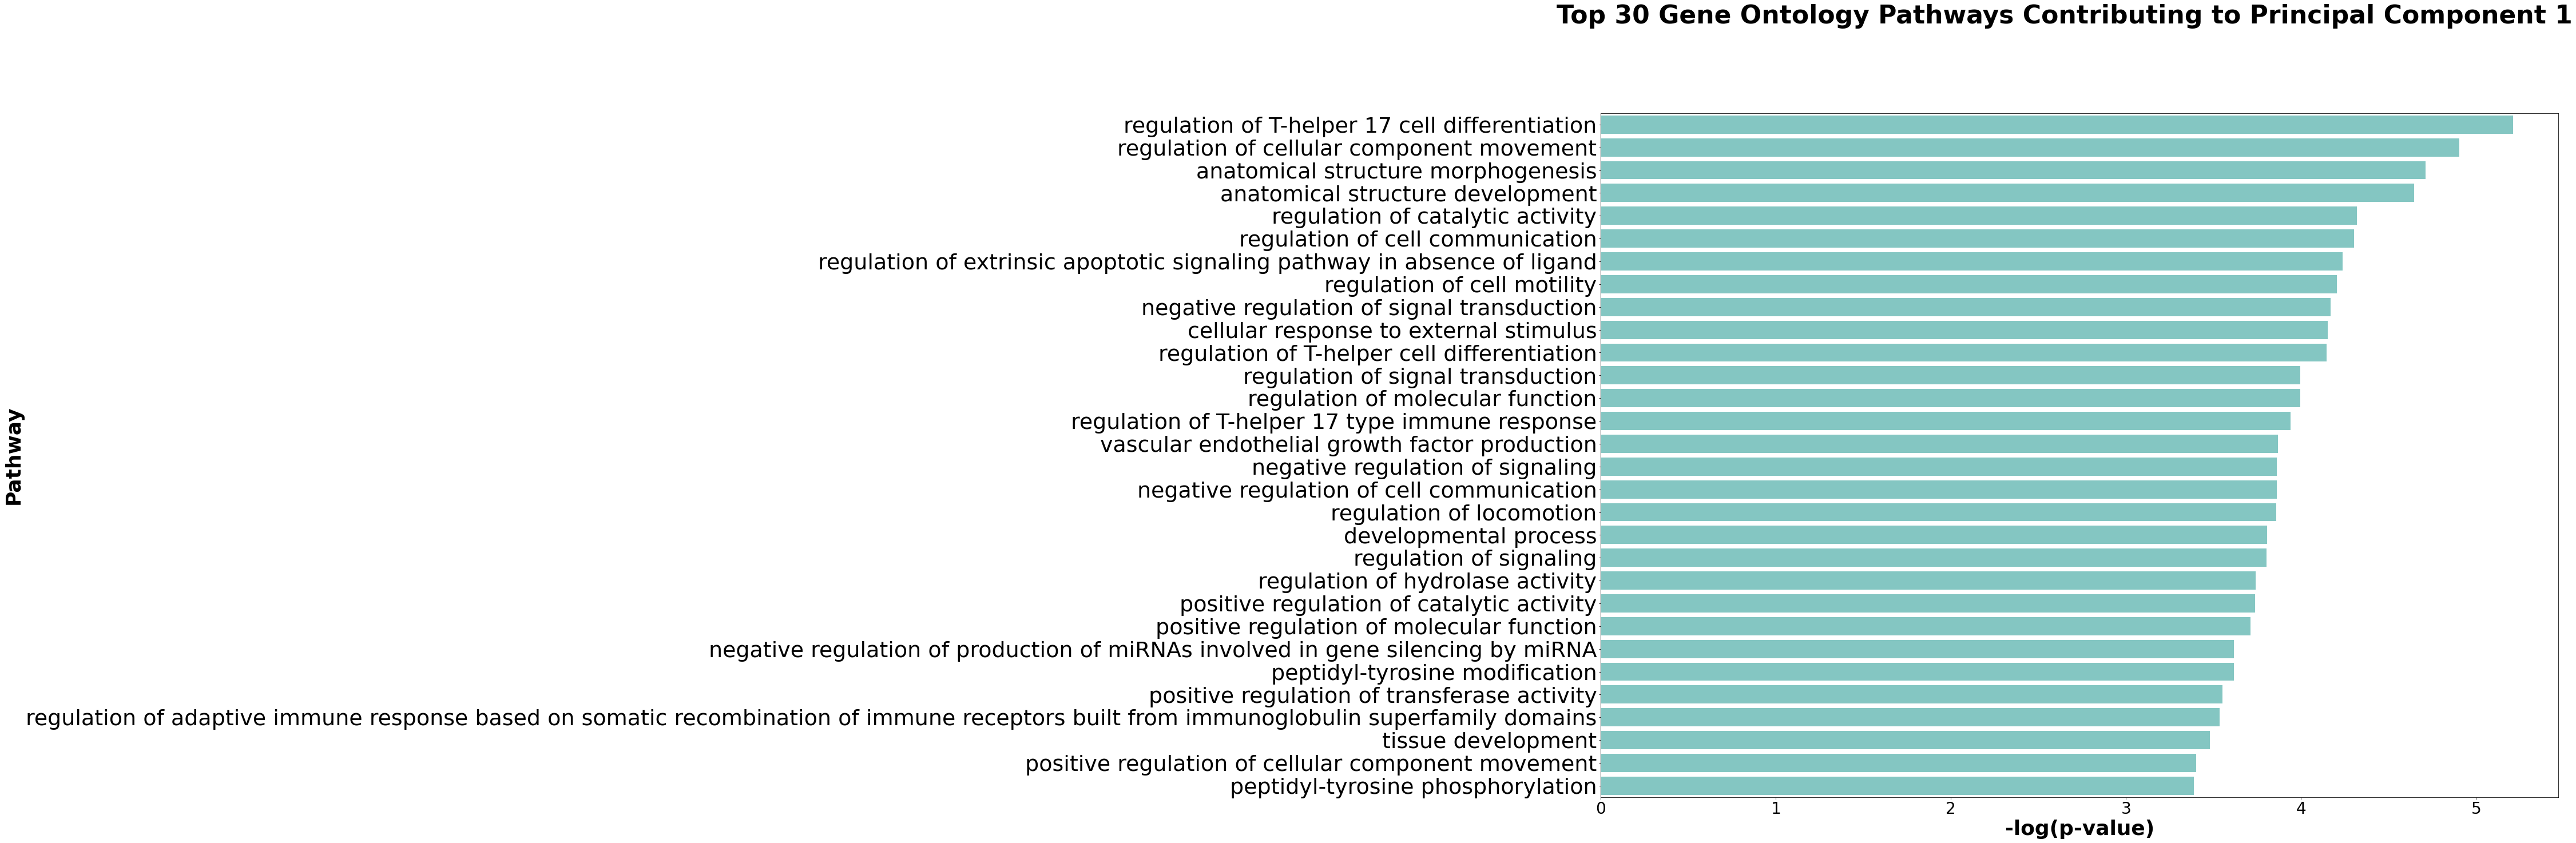

filtered: (30, 11)


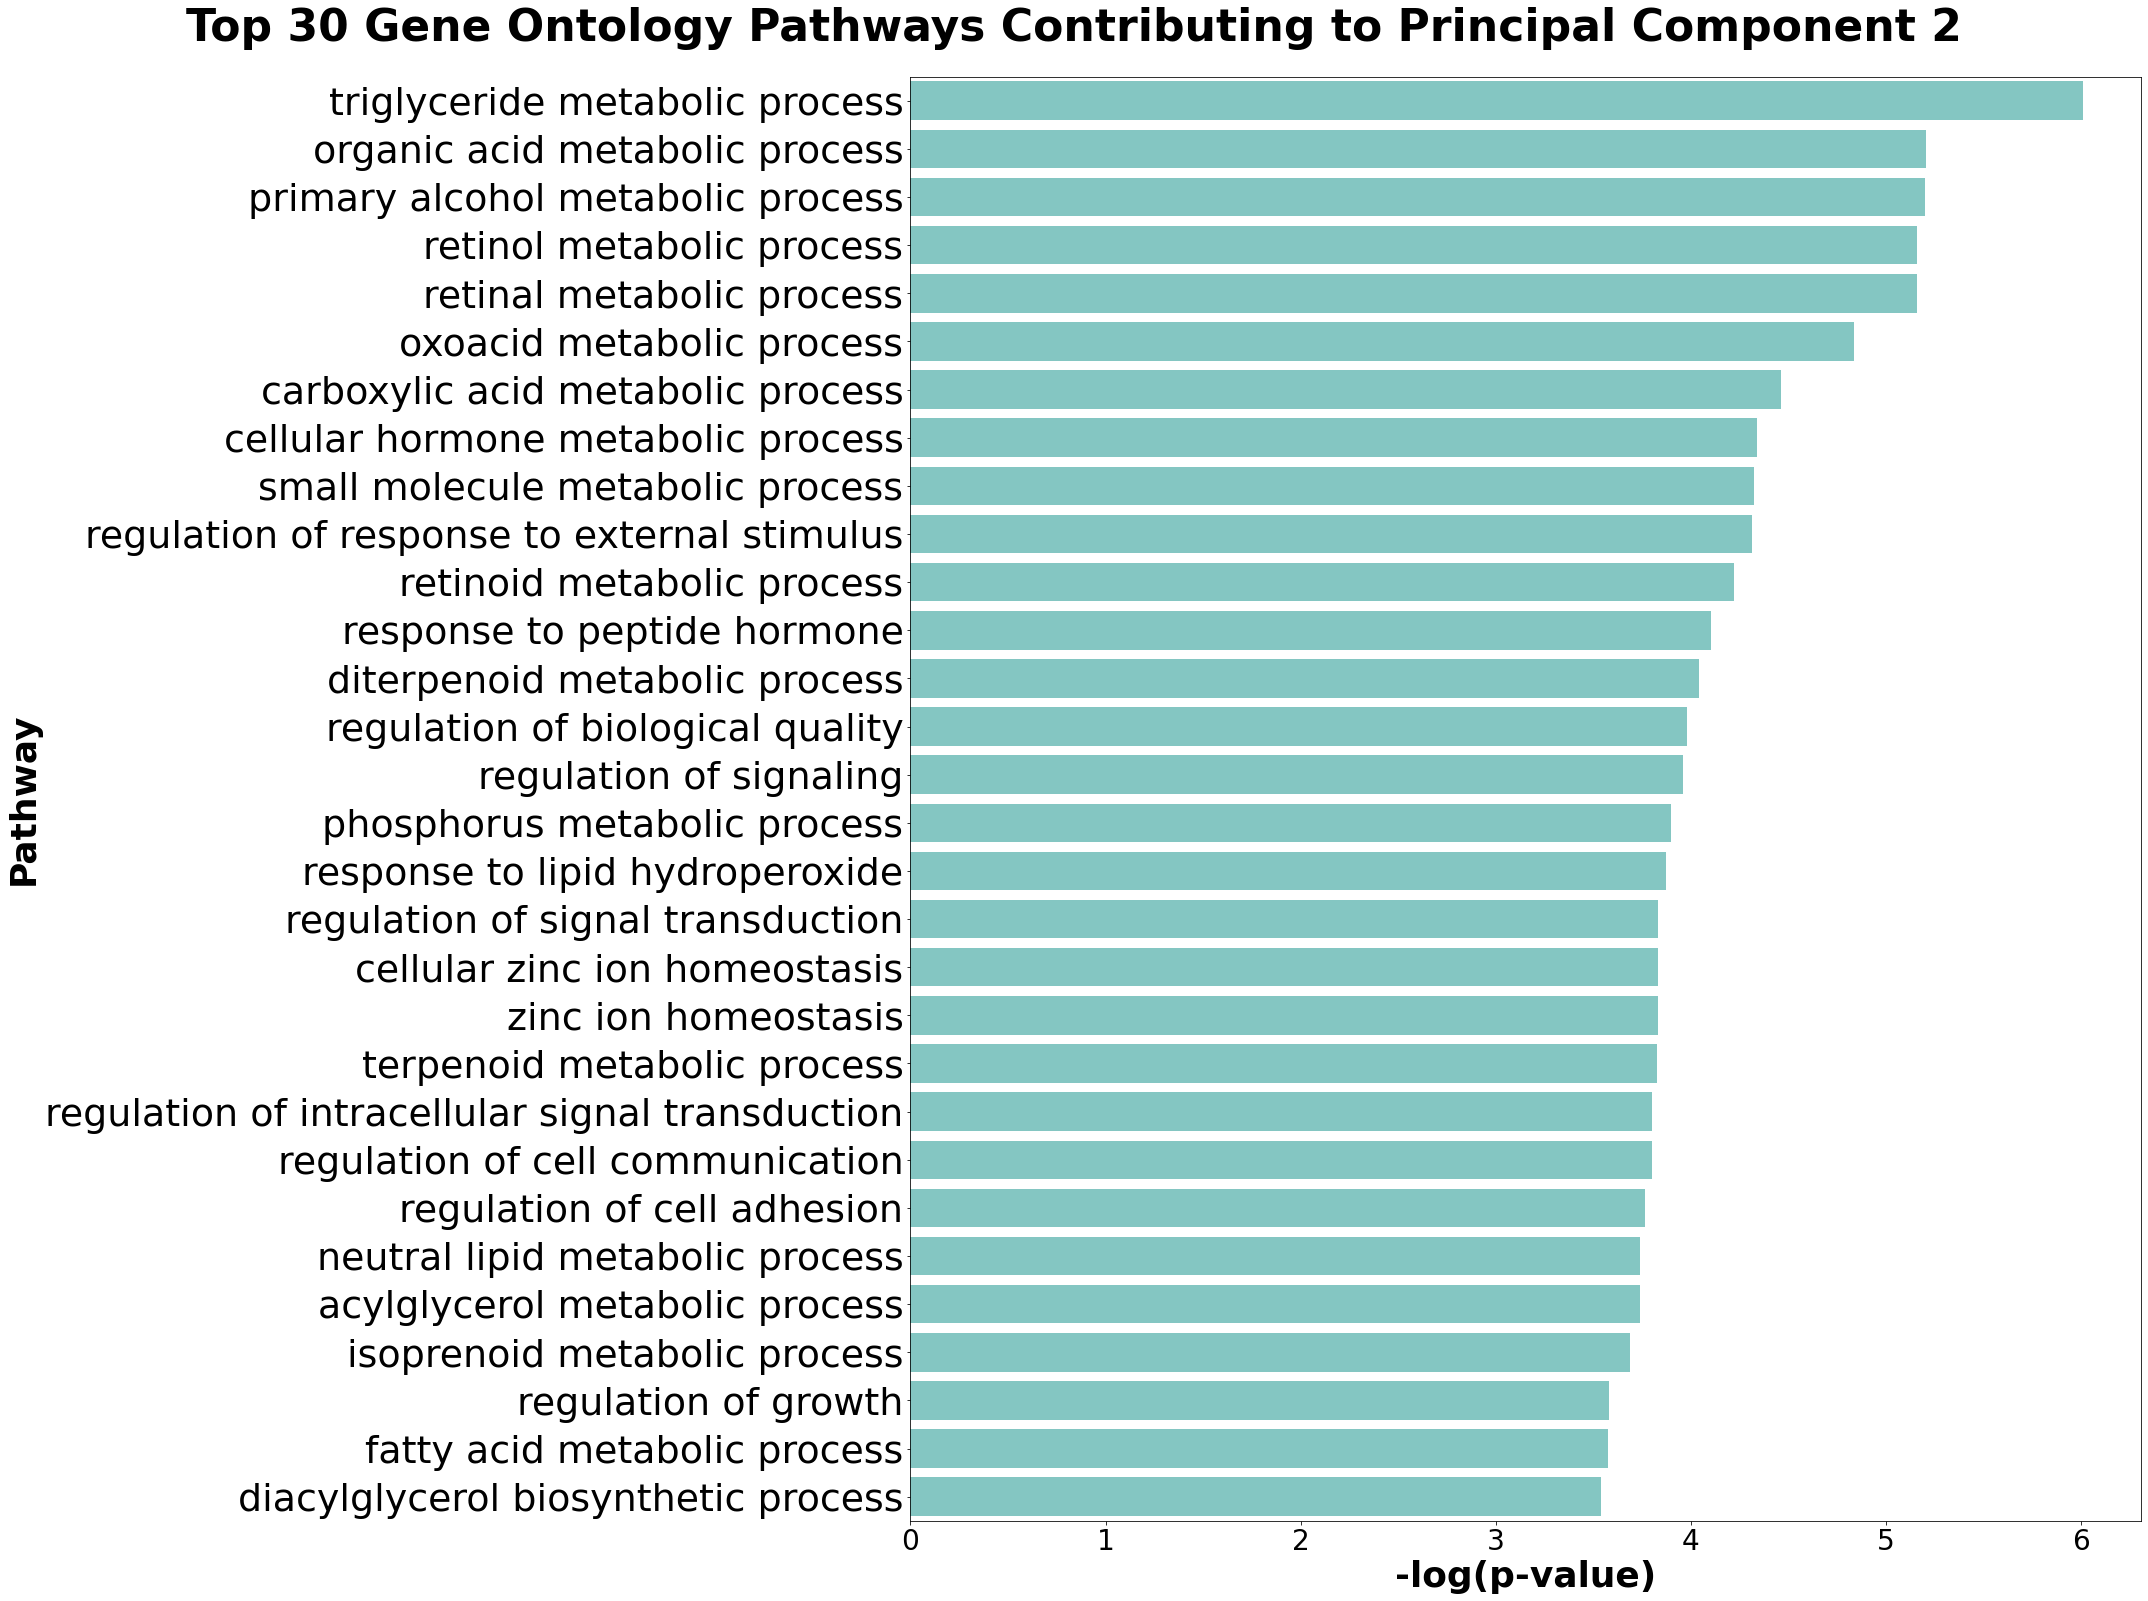

filtered: (30, 11)


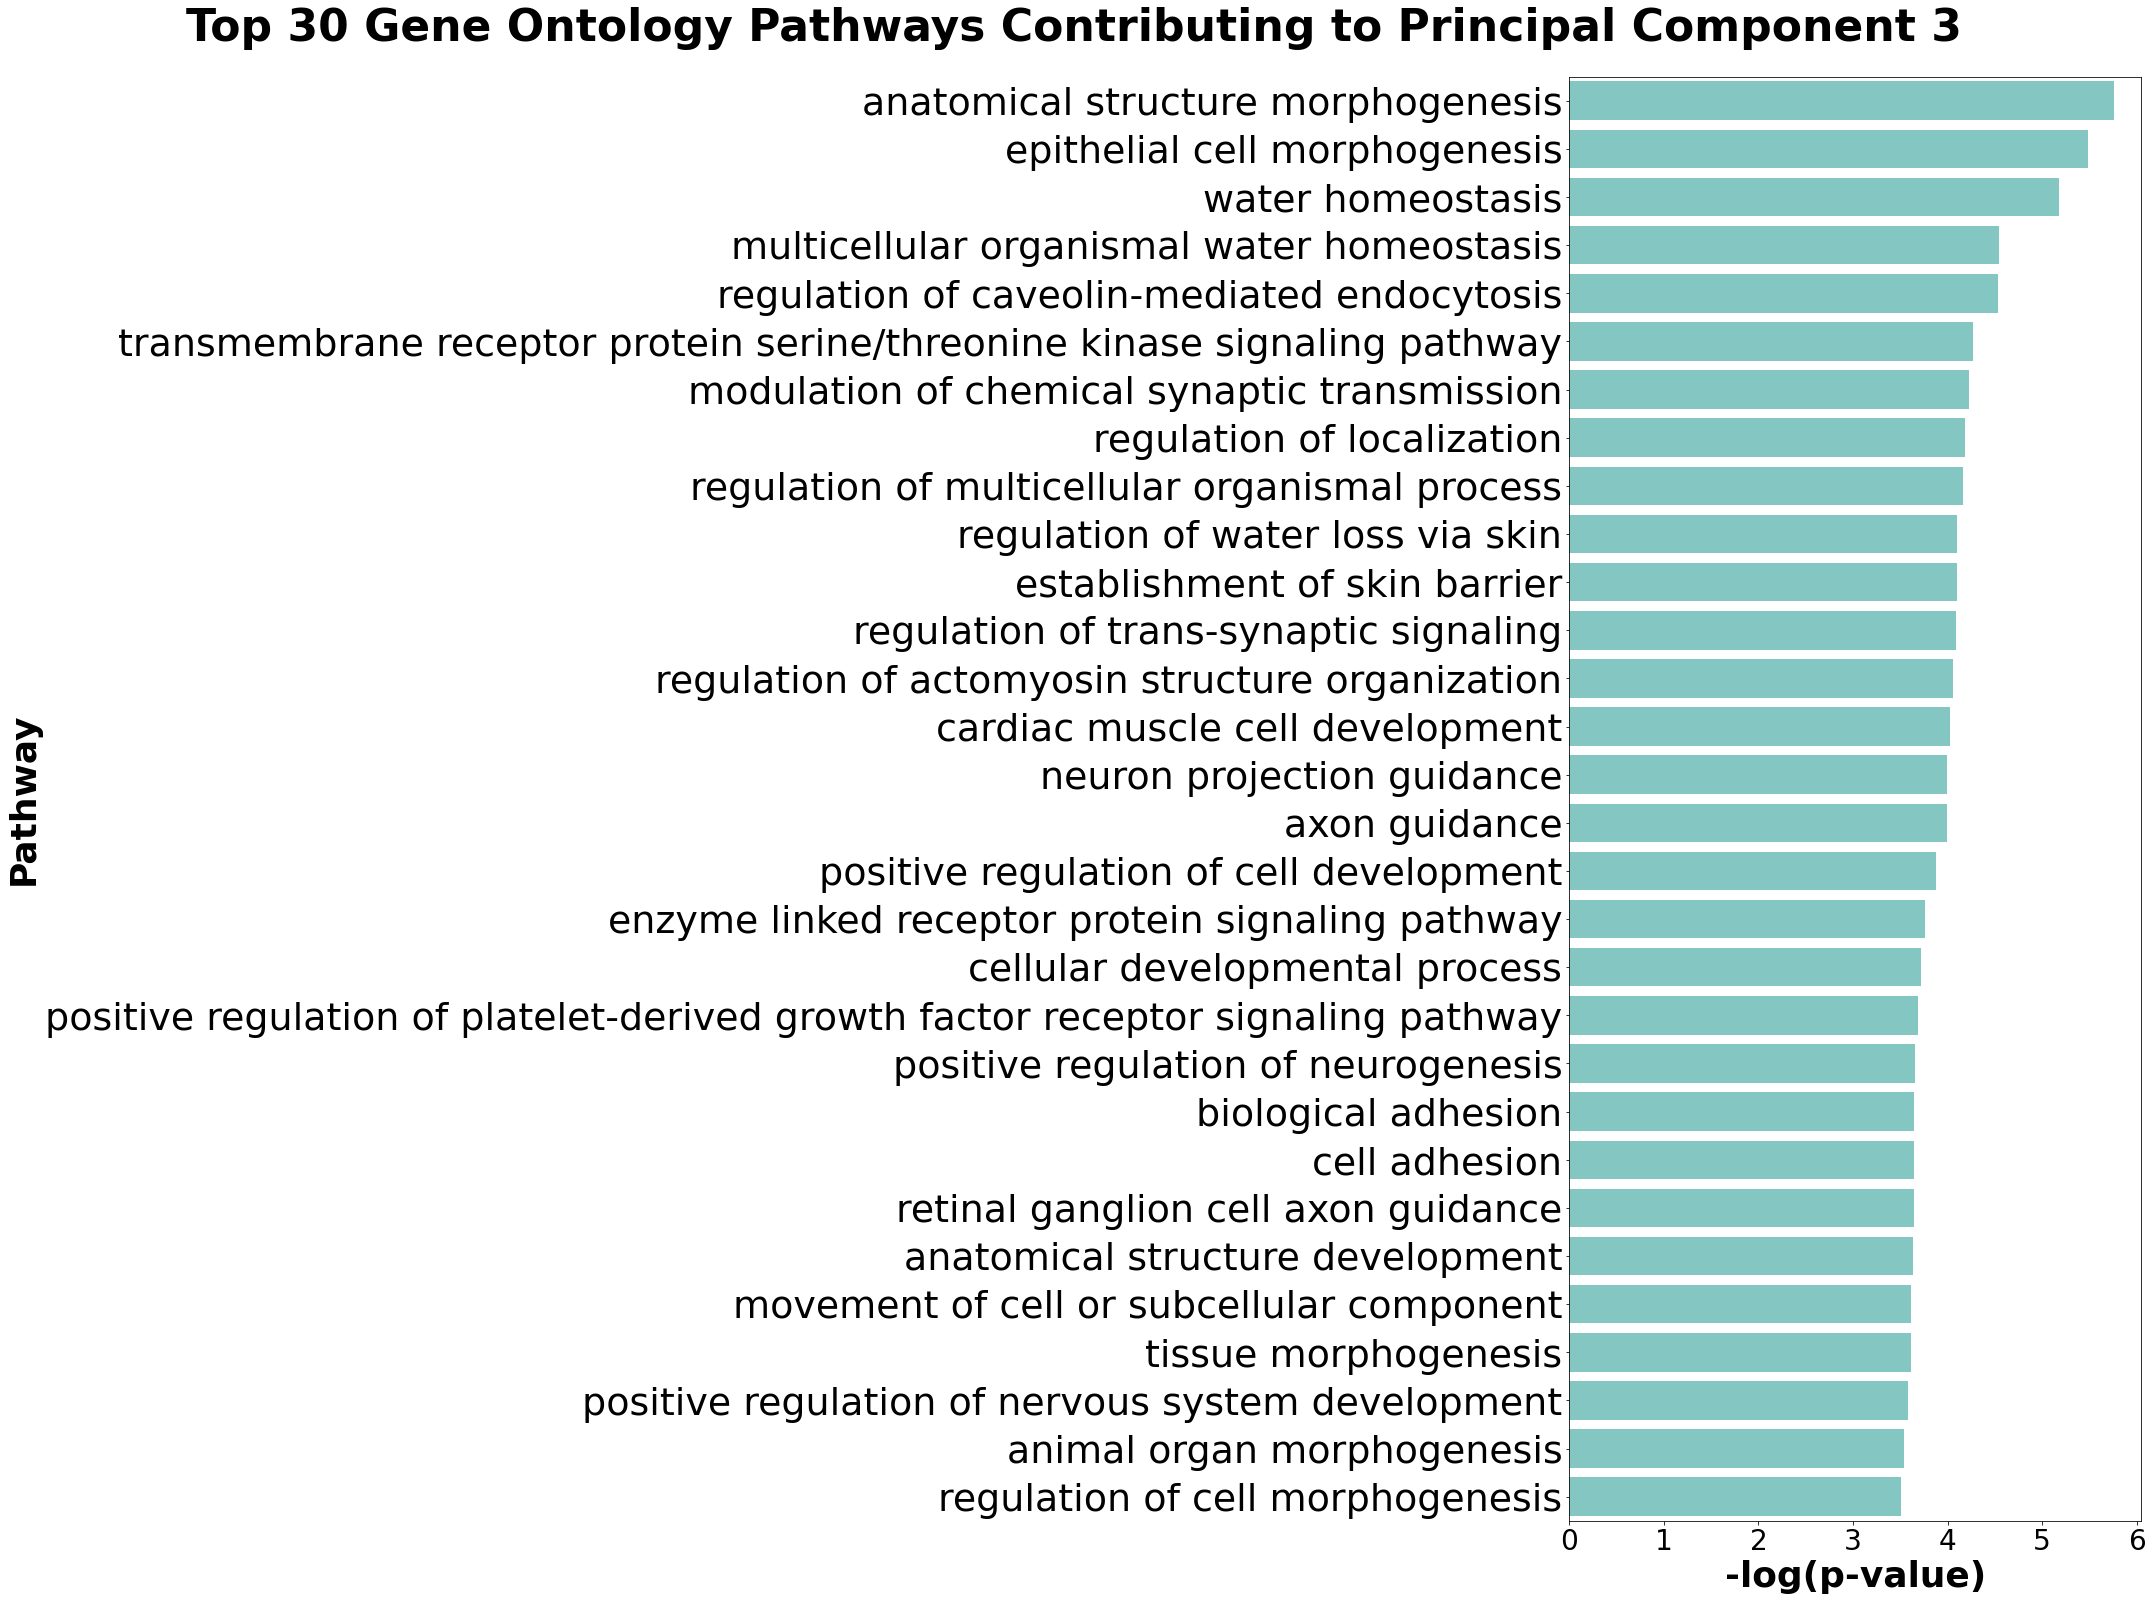

In [91]:
for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=36, fontweight='bold')
    plt.ylabel('Pathway', fontsize=36, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Principal Component {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=44,  y=1.0005)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(38)
    plt.tight_layout()
    plt.xticks(fontsize=28)
    plt.show()

## NMF

Analyzing how close to negative the distributions of each residual are:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


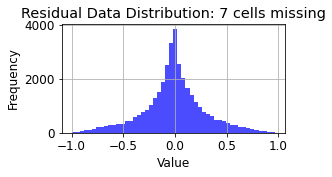

In [72]:
data = residuals_bulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

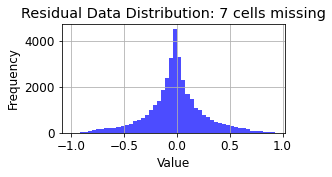

In [73]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9987524016268683


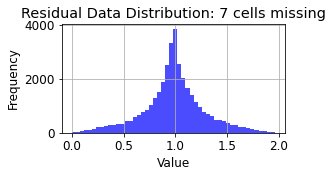

In [74]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9958686221854989


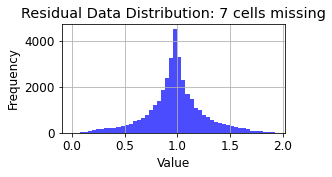

In [75]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9987524016268683


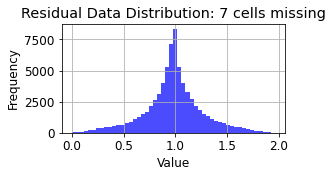

In [76]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### The combined residuals (classic and dissociated)

In [105]:
#nmf on residual combined
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
0  0.075226  0.156697  0.133275  0.141519  0.102357  0.100275  0.148486   
1  0.058329  0.161620  0.120536  0.110095  0.102060  0.135119  0.114301   
2  0.090520  0.123201  0.112281  0.136424  0.091074  0.183063  0.100499   
3  0.073087  0.125764  0.117188  0.149326  0.089927  0.102081  0.124199   

      ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
0  0.146211  0.106603  0.134095  ...  0.049210  0.112519  0.117422  0.113872   
1  0.147891  0.188653  0.107115  ...  0.035221  0.084610  0.092664  0.133372   
2  0.131235  0.066257  0.111452  ...  0.042116  0.094210  0.086455  0.106511   
3  0.125611  0.147242  0.101341  ...  0.018529  0.093807  0.090765  0.115246   

       ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
0  0.123075  0.111761  0.132689  0.187541  0.154339  0.158078  
1  0.117382  0.091433  0.136801  0.182688  0.182383  0.052584  
2  0.255988  0.096625  0.136687  0.147685  0.129020  0.185890  
3  0.127980  0.089478  0.109841  0.156502  0.119059  0.114198  

[4 rows x 4584 columns]

In [106]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic       P-Value
0        0.0     0.077159  9.395886e-01
1        1.0     0.751164  4.649940e-01
2        2.0    -8.436902  7.334988e-07
3        3.0     1.055247  3.091835e-01
Components with significantly different means:
   Component  T-Statistic       P-Value
2        2.0    -8.436902  7.334988e-07


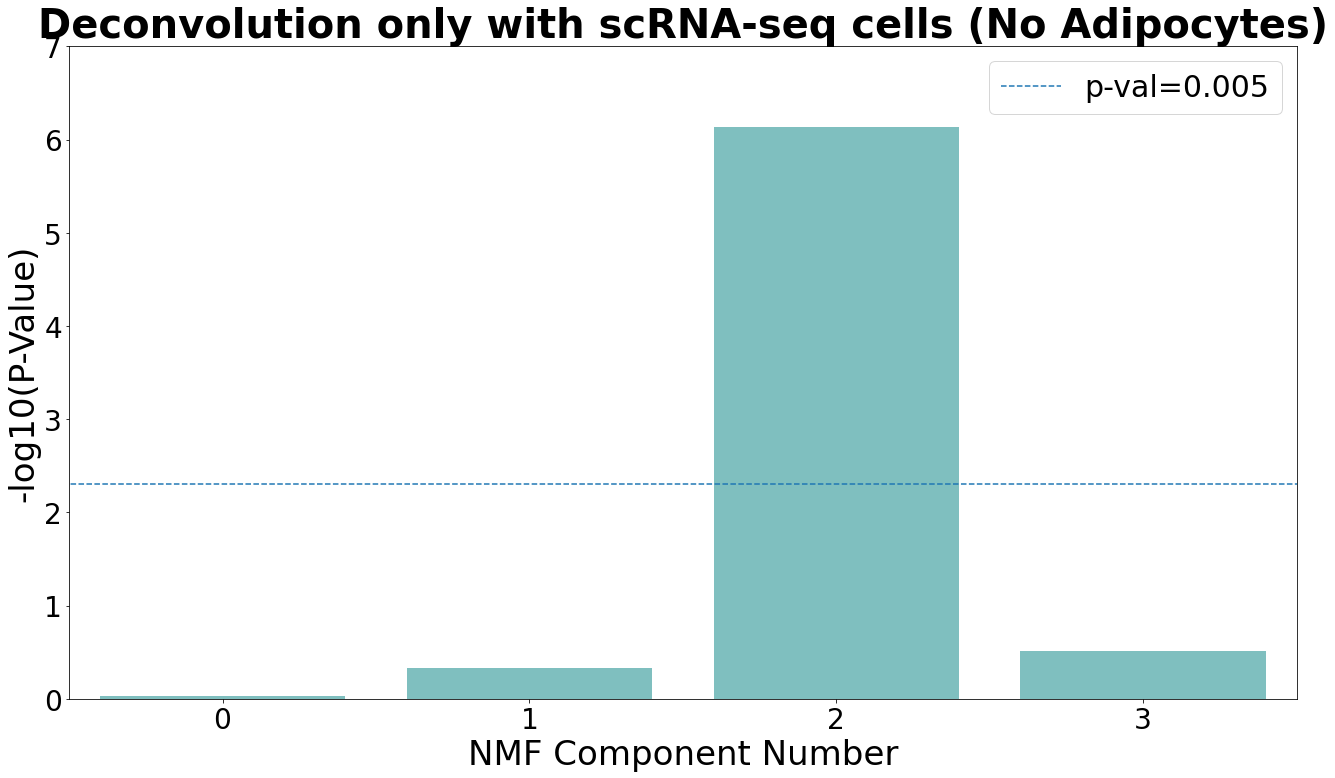

In [107]:
# Bar plot for each component
plt.figure(figsize=(22,12))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)

plt.xlabel('NMF Component Number', fontsize=34, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=34, fontname='Arial')
plt.plot([-1,0,1,2,3,4],np.repeat(-np.log10(0.005),6),linestyle='--', label='p-val=0.005')
title_str ='Deconvolution only with scRNA-seq cells (No Adipocytes)'
plt.title(title_str, fontsize=40, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3], fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(0,7)
plt.xlim(-0.5,3.5)
plt.legend(fontsize=30)
plt.show()

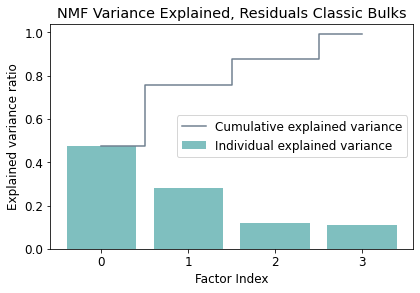

In [82]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
]


## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance', color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='slategrey')
plt.ylabel('Explained variance ratio')
plt.xlabel('Factor Index')
plt.legend(loc='best')
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks")
plt.show()

In [83]:
W = res_nmf_combo.values
H = components_combo.values

nmf_genes_combo = pd.DataFrame()
num_components = num_nmf_comp_combo

# Iterate through each component
for component_idx in range(num_components):

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_combo[component_idx] = top_genes[::-1]
    
nmf_genes_combo.columns = ["Component_0","Component_1","Component_2","Component_3"]
nmf_genes_combo

Component_0 Component_1 Component_2 Component_3
0           LY75       GABRE       NLRP3        TLN2
1          CIITA       WDR91        RELT      PLXNA4
2           TAP2     TMEM63A      KLHL21        GPAM
3         BTN3A1       VTCN1       DUSP2       F13A1
4            TTN       OBSCN     ZC3H12A         TTN
...          ...         ...         ...         ...
4579        MT1A       IGHG4        UPF2      CLEC2B
4580         CFD       IGHG3       HIPK2        CCL3
4581        AREG       IGHA1     SELENOP         MDK
4582       DEFB1       CXCL8       PSMB9      PMAIP1
4583        MT1M       IGLC3       BICD1    HIST1H1D

[4584 rows x 4 columns]

In [93]:
# The sheets on the Excel
''' NOTE: You'll need to run GOrilla on these lists for the next part!'''
added = "NMF_genes_residuals_combo.xlsx"
sheet_names = ['GOPROCESS_Component_0','GOPROCESS_Component_1','GOPROCESS_Component_2','GOPROCESS_Component_3']  

nmf_name_path = Path(f"{os.getcwd()}/../results/EXP4/", f"{added}")
pnmf_genes_combo.to_excel(pca_name_path, sheet_name = "NMF_Components_Genes")

filtered: (30, 11)


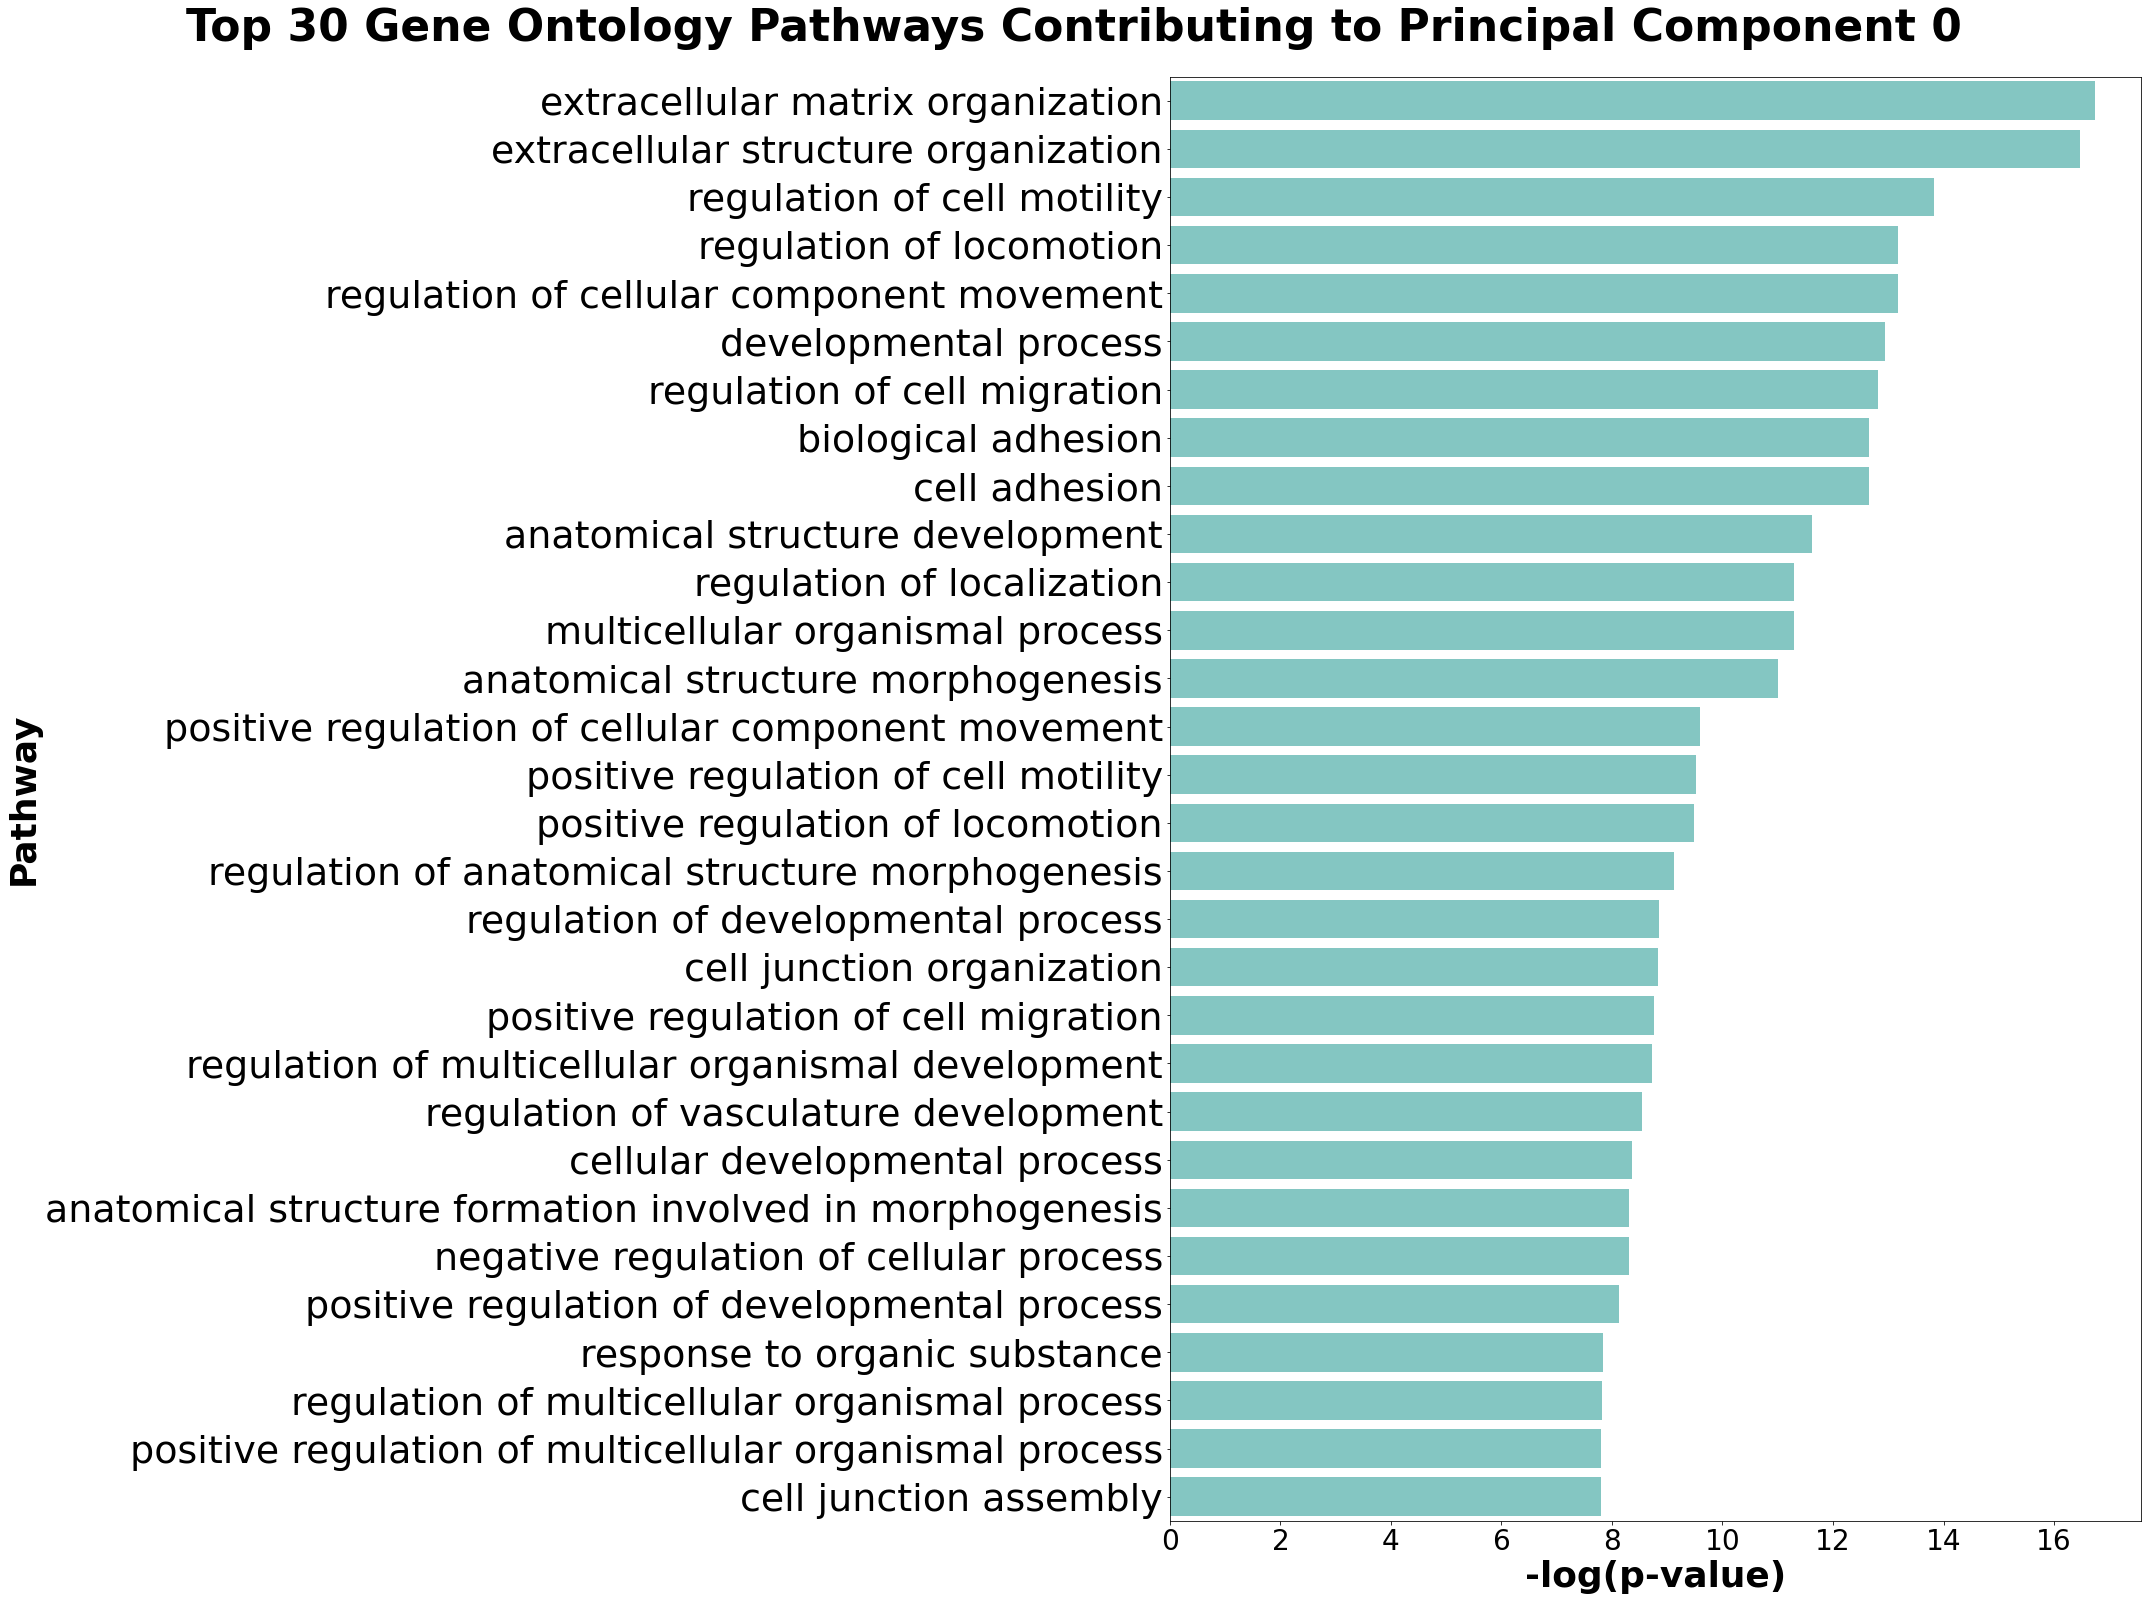

filtered: (16, 11)


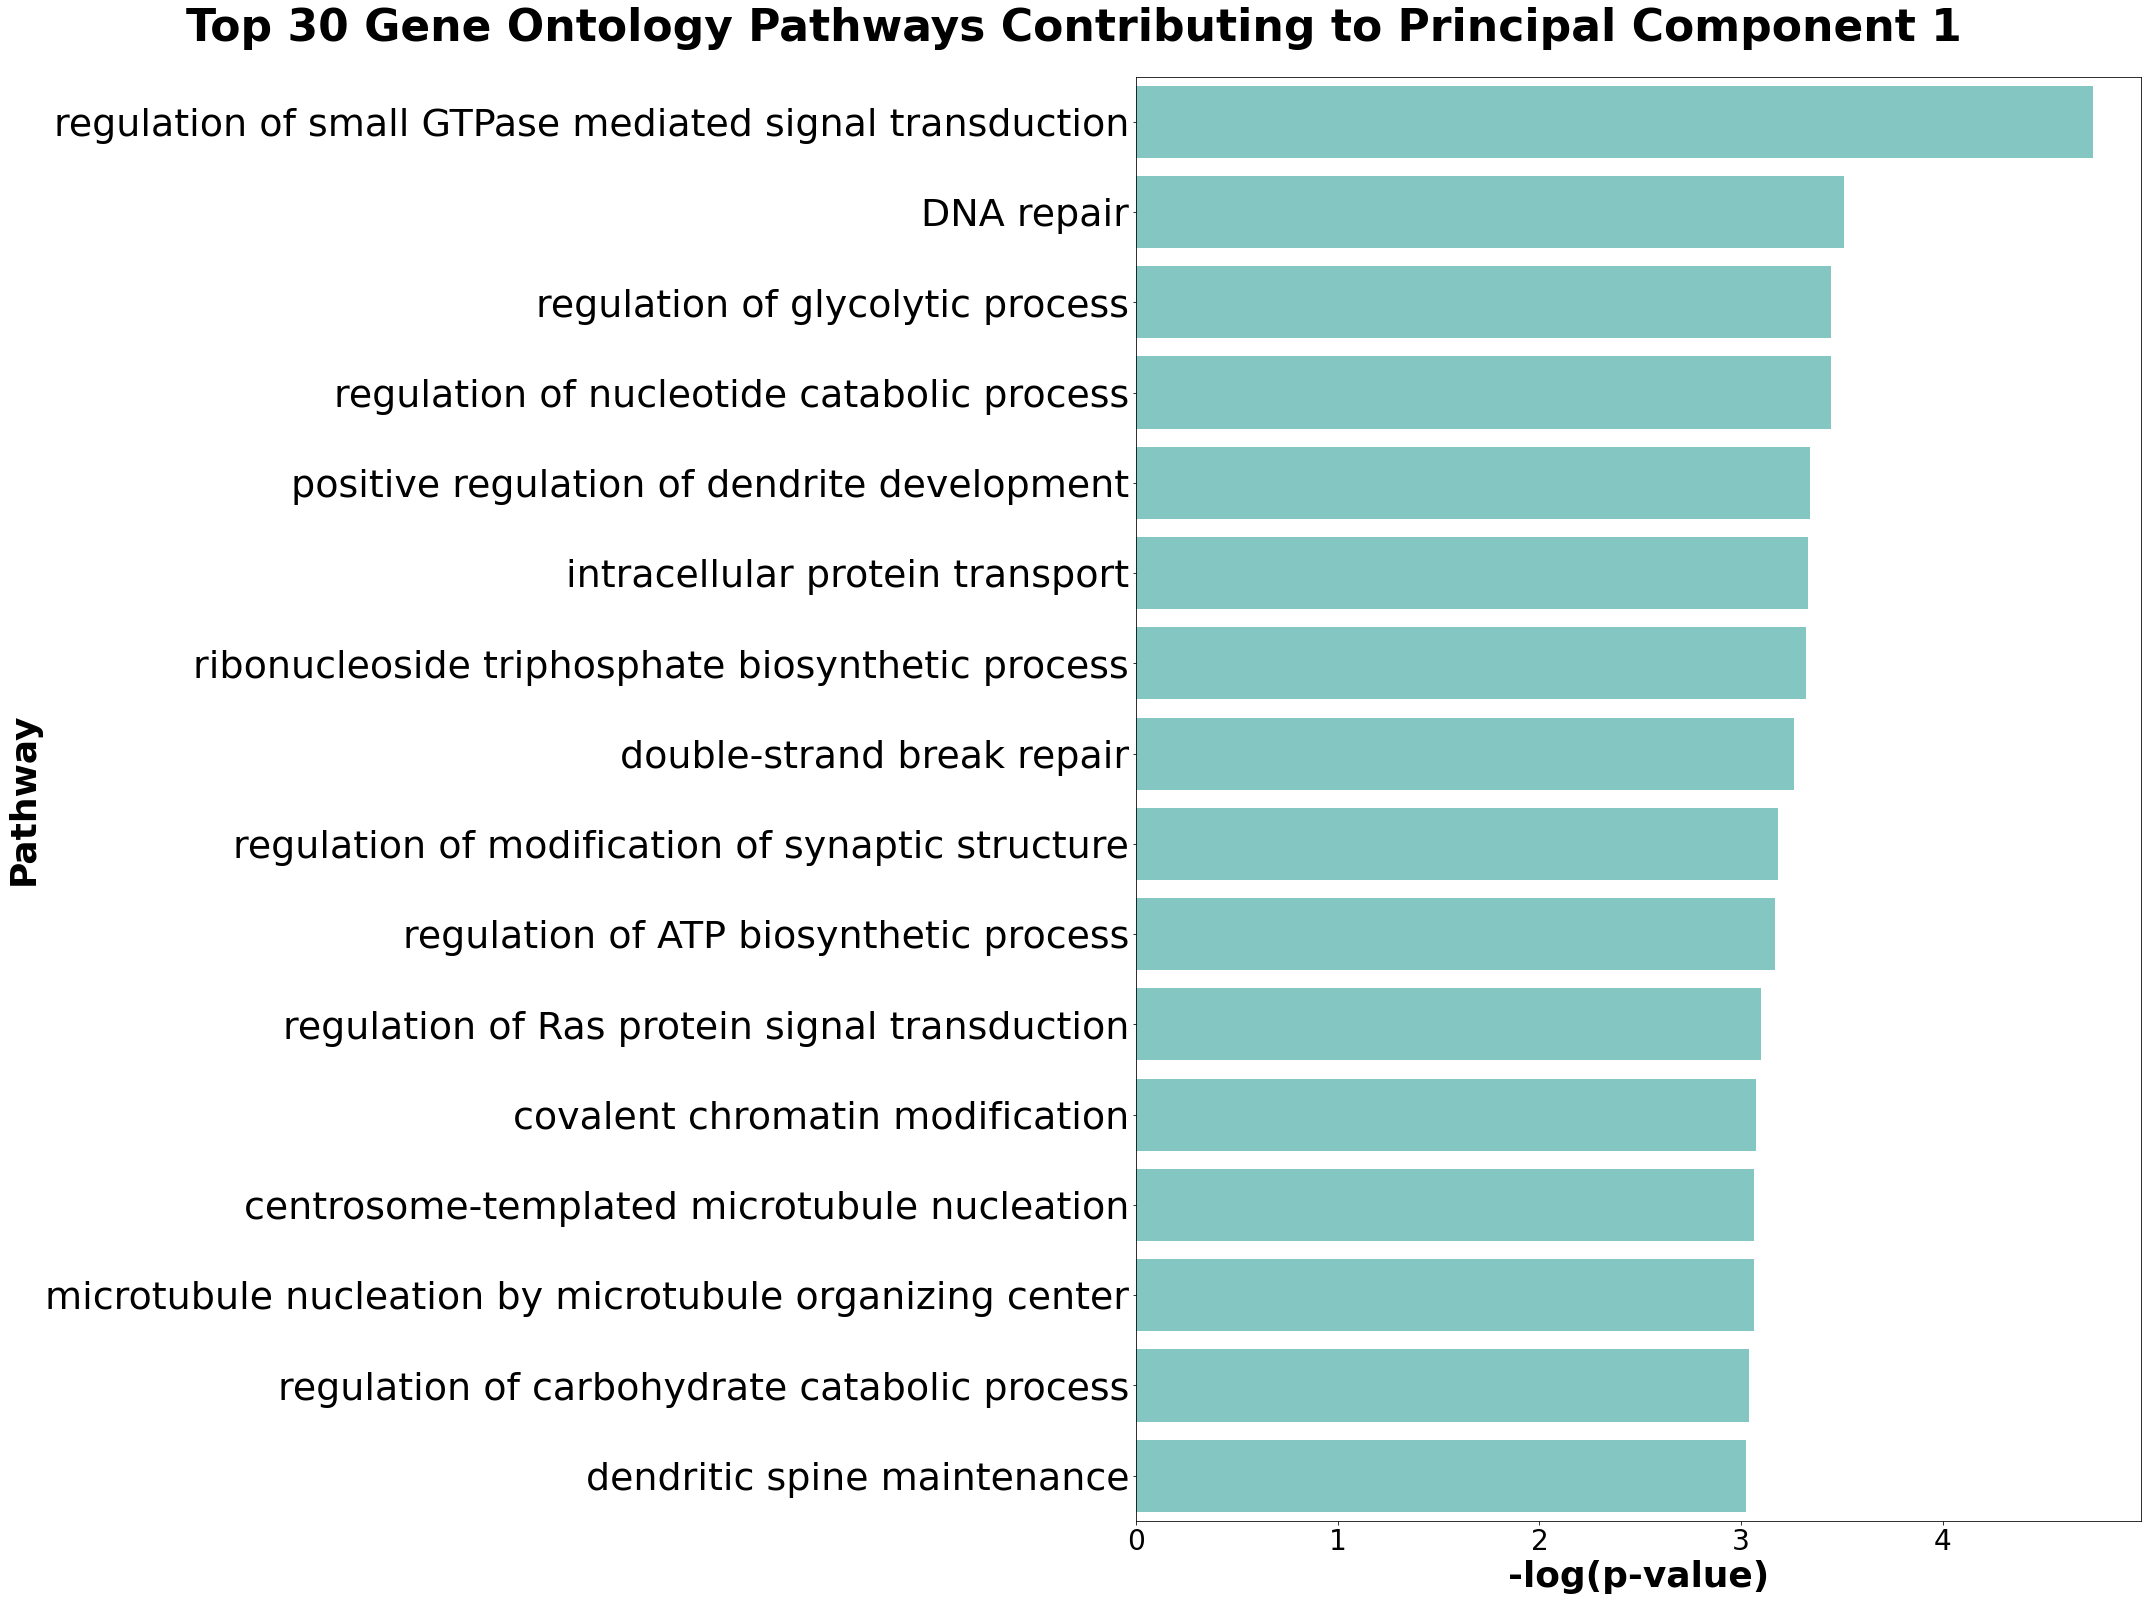

filtered: (30, 11)


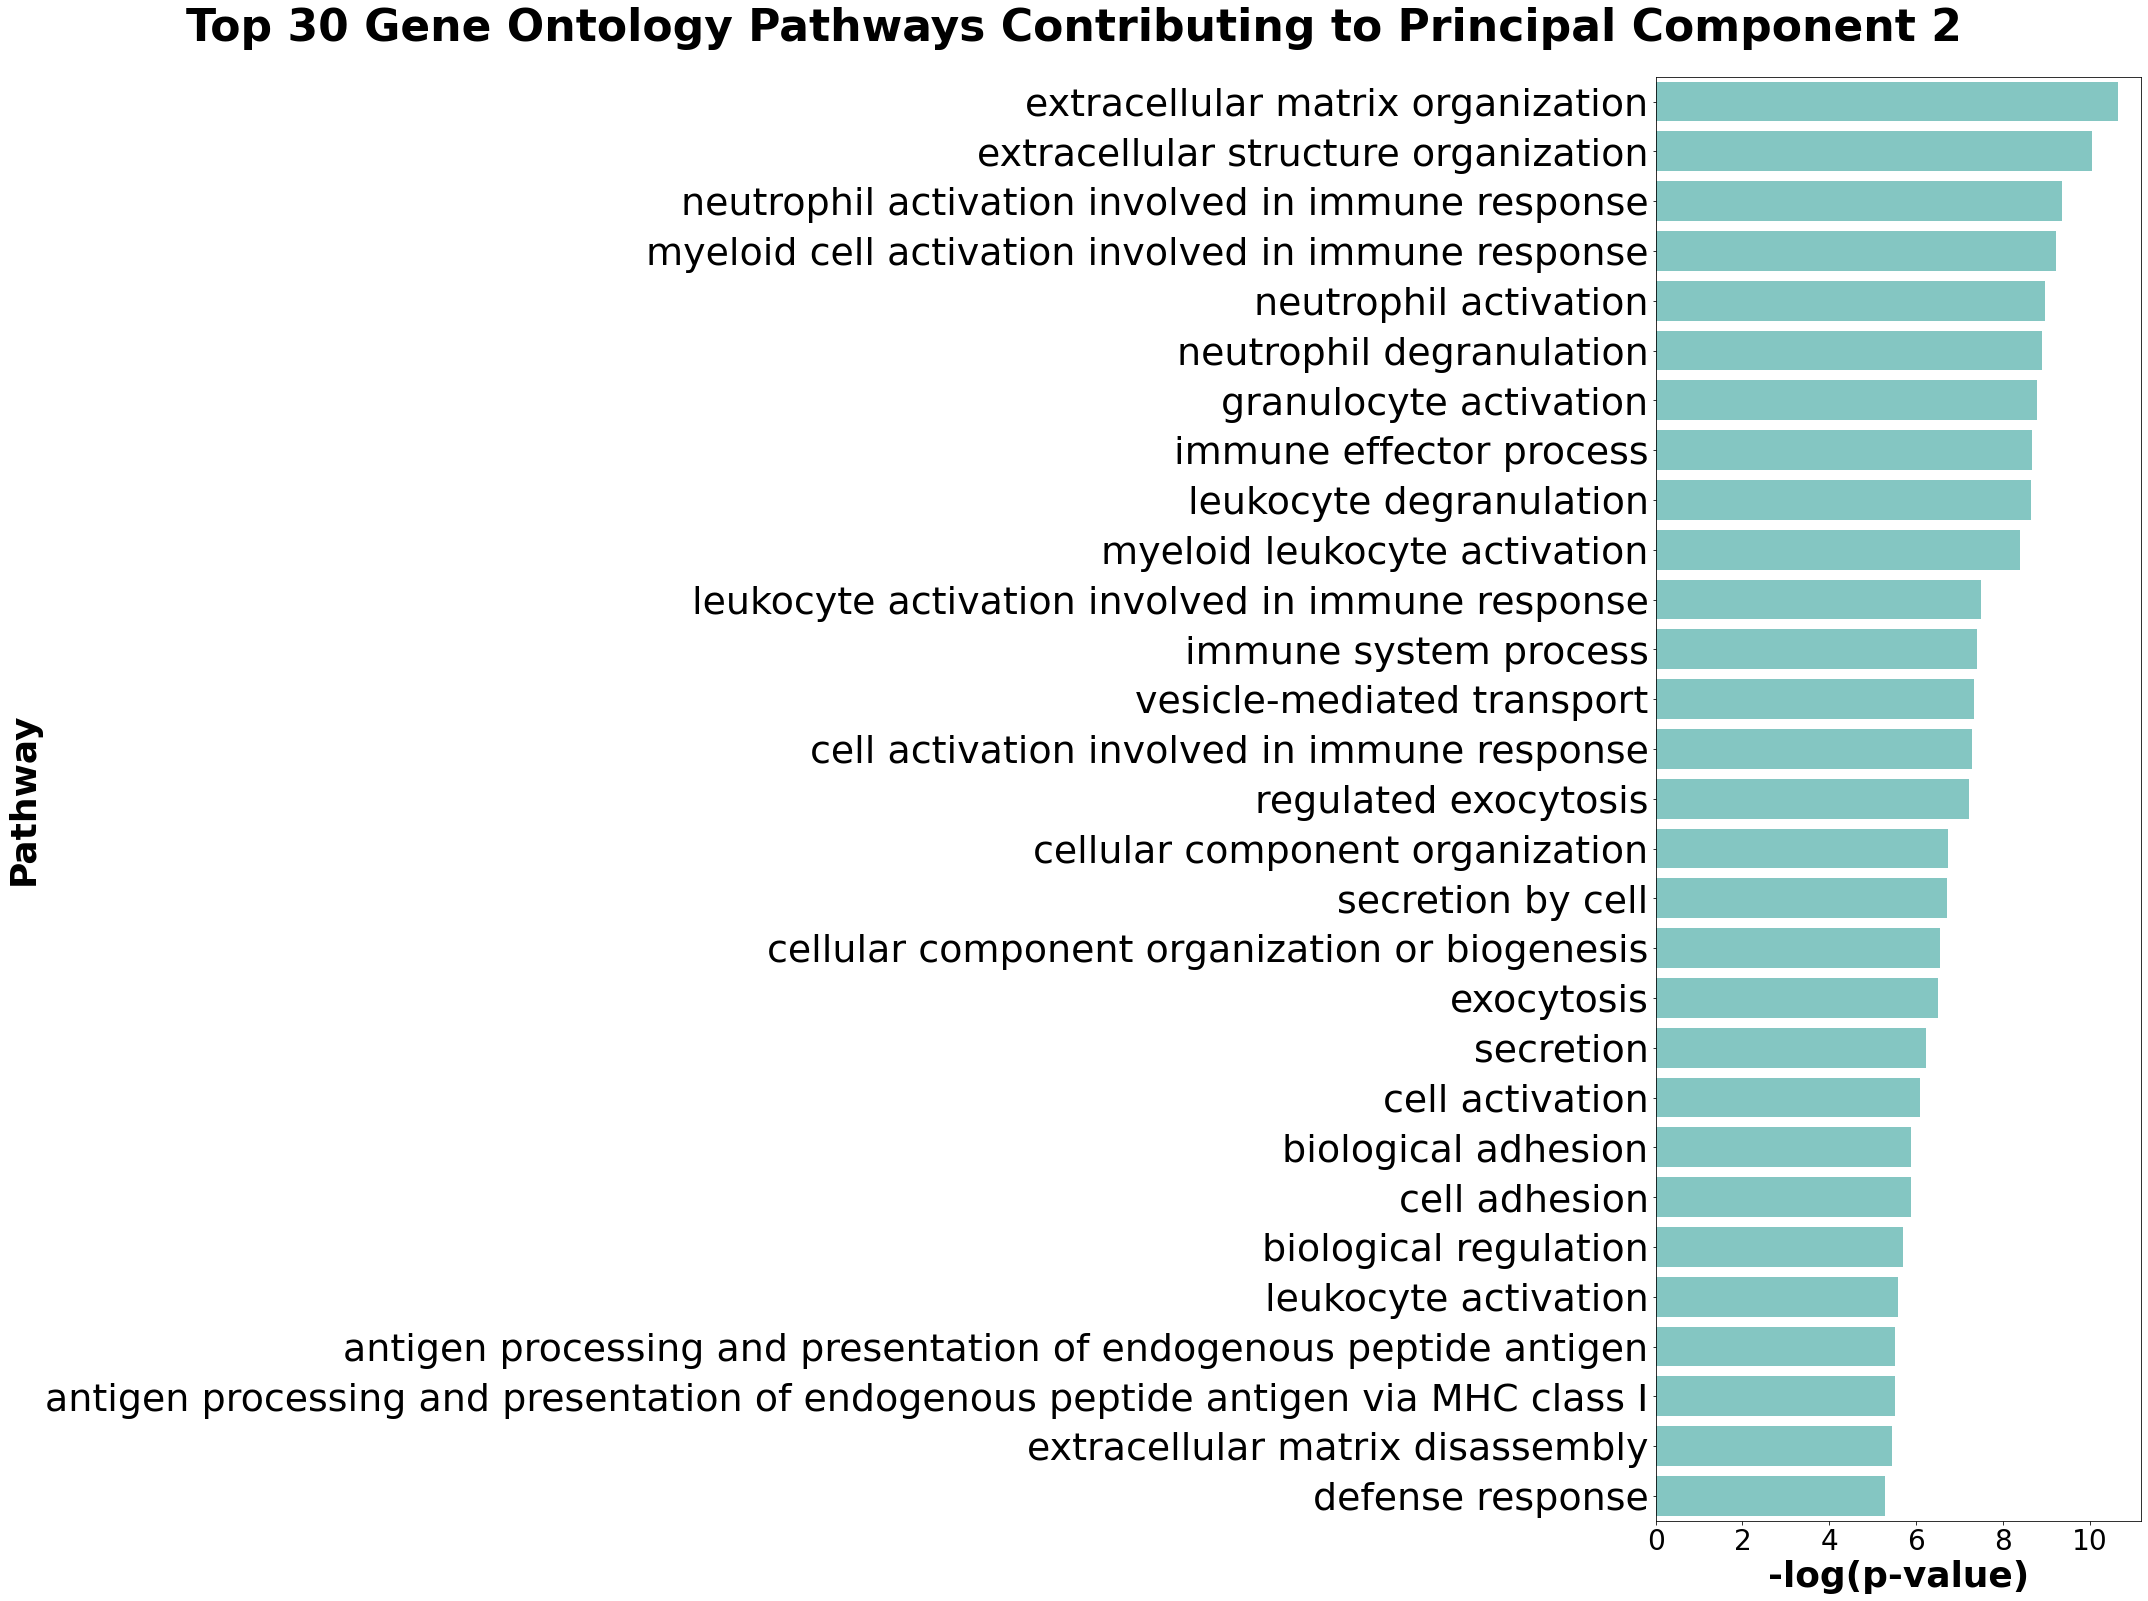

filtered: (30, 11)


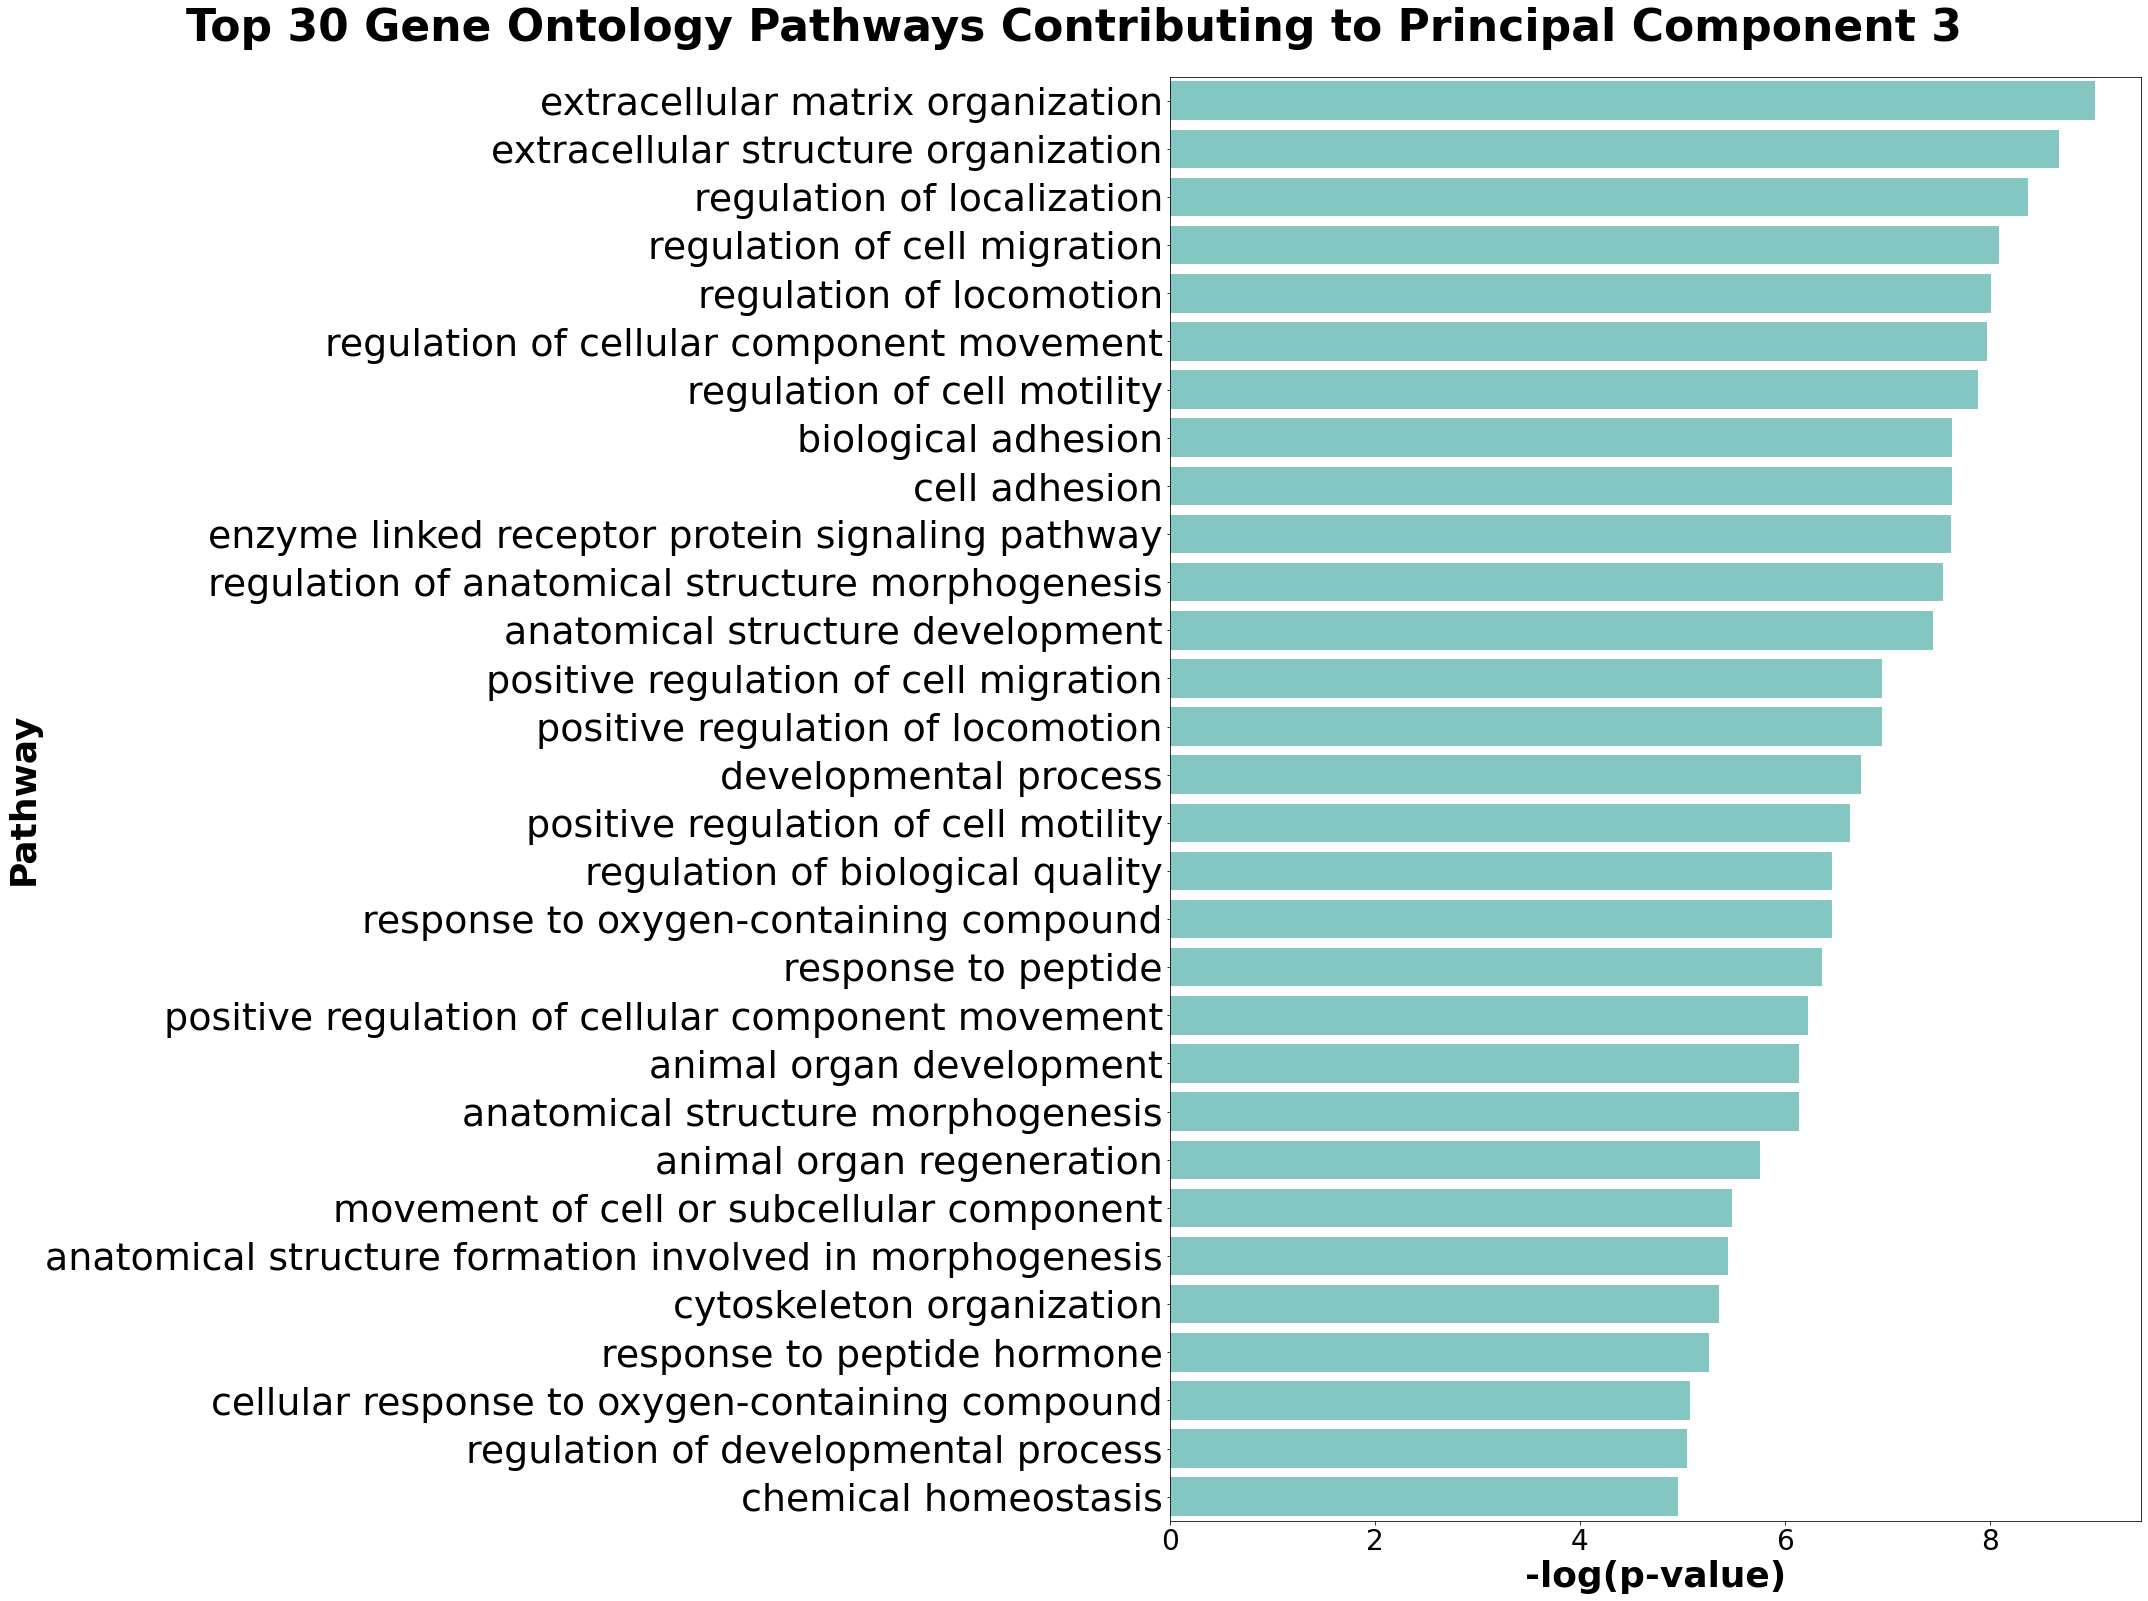

In [94]:
for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=36, fontweight='bold')
    plt.ylabel('Pathway', fontsize=36, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Principal Component {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=44,  y=1.0005)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(38)
    plt.tight_layout()
    plt.xticks(fontsize=28)
    plt.show()

Now the Classic

In [95]:
#nmf on residual combined
num_nmf_comp_bulks = 4
nmf = NMF(n_components = num_nmf_comp_bulks, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_bulks_shift)
res_nmf_bulks = pd.DataFrame(res_nmf_df)
components_bulks = pd.DataFrame(nmf.components_)
components_bulks.columns = gene_ids
components_bulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
0  0.053304  0.120579  0.100212  0.096609  0.081385  0.095951  0.116918   
1  0.086324  0.140265  0.131693  0.169351  0.099951  0.116954  0.136161   
2  0.042576  0.119253  0.083463  0.078668  0.078120  0.093356  0.080510   
3  0.053920  0.129129  0.109746  0.102590  0.075964  0.100725  0.102730   

      ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
0  0.107510  0.083012  0.100932  ...  0.037416  0.084277  0.081391  0.077636   
1  0.142565  0.158350  0.115553  ...  0.019622  0.106496  0.103397  0.131454   
2  0.109316  0.152803  0.075813  ...  0.021568  0.063647  0.064924  0.101856   
3  0.121812  0.096057  0.099024  ...  0.043536  0.072656  0.089987  0.101319   

       ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
0  0.088109  0.082763  0.082842  0.124117  0.132954  0.123363  
1  0.168422  0.102050  0.130452  0.180916  0.129901  0.134450  
2  0.082877  0.064389  0.087800  0.120394  0.132909  0.039326  
3  0.106937  0.084978  0.144373  0.174115  0.129472  0.072284  

[4 rows x 4584 columns]

In [96]:
W = res_nmf_bulks.values
H = components_bulks.values

nmf_genes_bulks = pd.DataFrame()
num_components = num_nmf_comp_bulks

# Iterate through each component
for component_idx in range(num_components):

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_bulks[component_idx] = top_genes[::-1]
    
nmf_genes_bulks.columns = ["Component_0","Component_1","Component_2","Component_3"]
nmf_genes_bulks

Component_0 Component_1 Component_2 Component_3
0           LY75        GPAM    TMEM132C         PPL
1         BTN3A1       F13A1       GABRE         CGN
2          ITGB4      PLXNA4        ACPP       F13A1
3          CIITA        TLN2        DNM1       WDR91
4           TAP2      AMOTL2      MPPED2     PLEKHG5
...          ...         ...         ...         ...
4579        MT1A      TCF7L2      CCDC80         ADM
4580        MT1M       VAMP5        MT1M        CCL2
4581         IL6      CLEC2B        AREG        MT1A
4582        AREG       PSMB9       IGLC3        MT1M
4583         CFD       TEX14       IGHG4       CRYAB

[4584 rows x 4 columns]

In [100]:
# The sheets on the Excel
''' NOTE: You'll need to run GOrilla on these lists for the next part!'''
added = "NMF_genes_residuals_classic.xlsx"
sheet_names = ['GOPROCESS_Component_0','GOPROCESS_Component_1','GOPROCESS_Component_2','GOPROCESS_Component_3']  

nmf_name_path = Path(f"{os.getcwd()}/../results/EXP4/", f"{added}")
pnmf_genes_combo.to_excel(pca_name_path, sheet_name = "NMF_Components_Genes")

filtered: (30, 11)


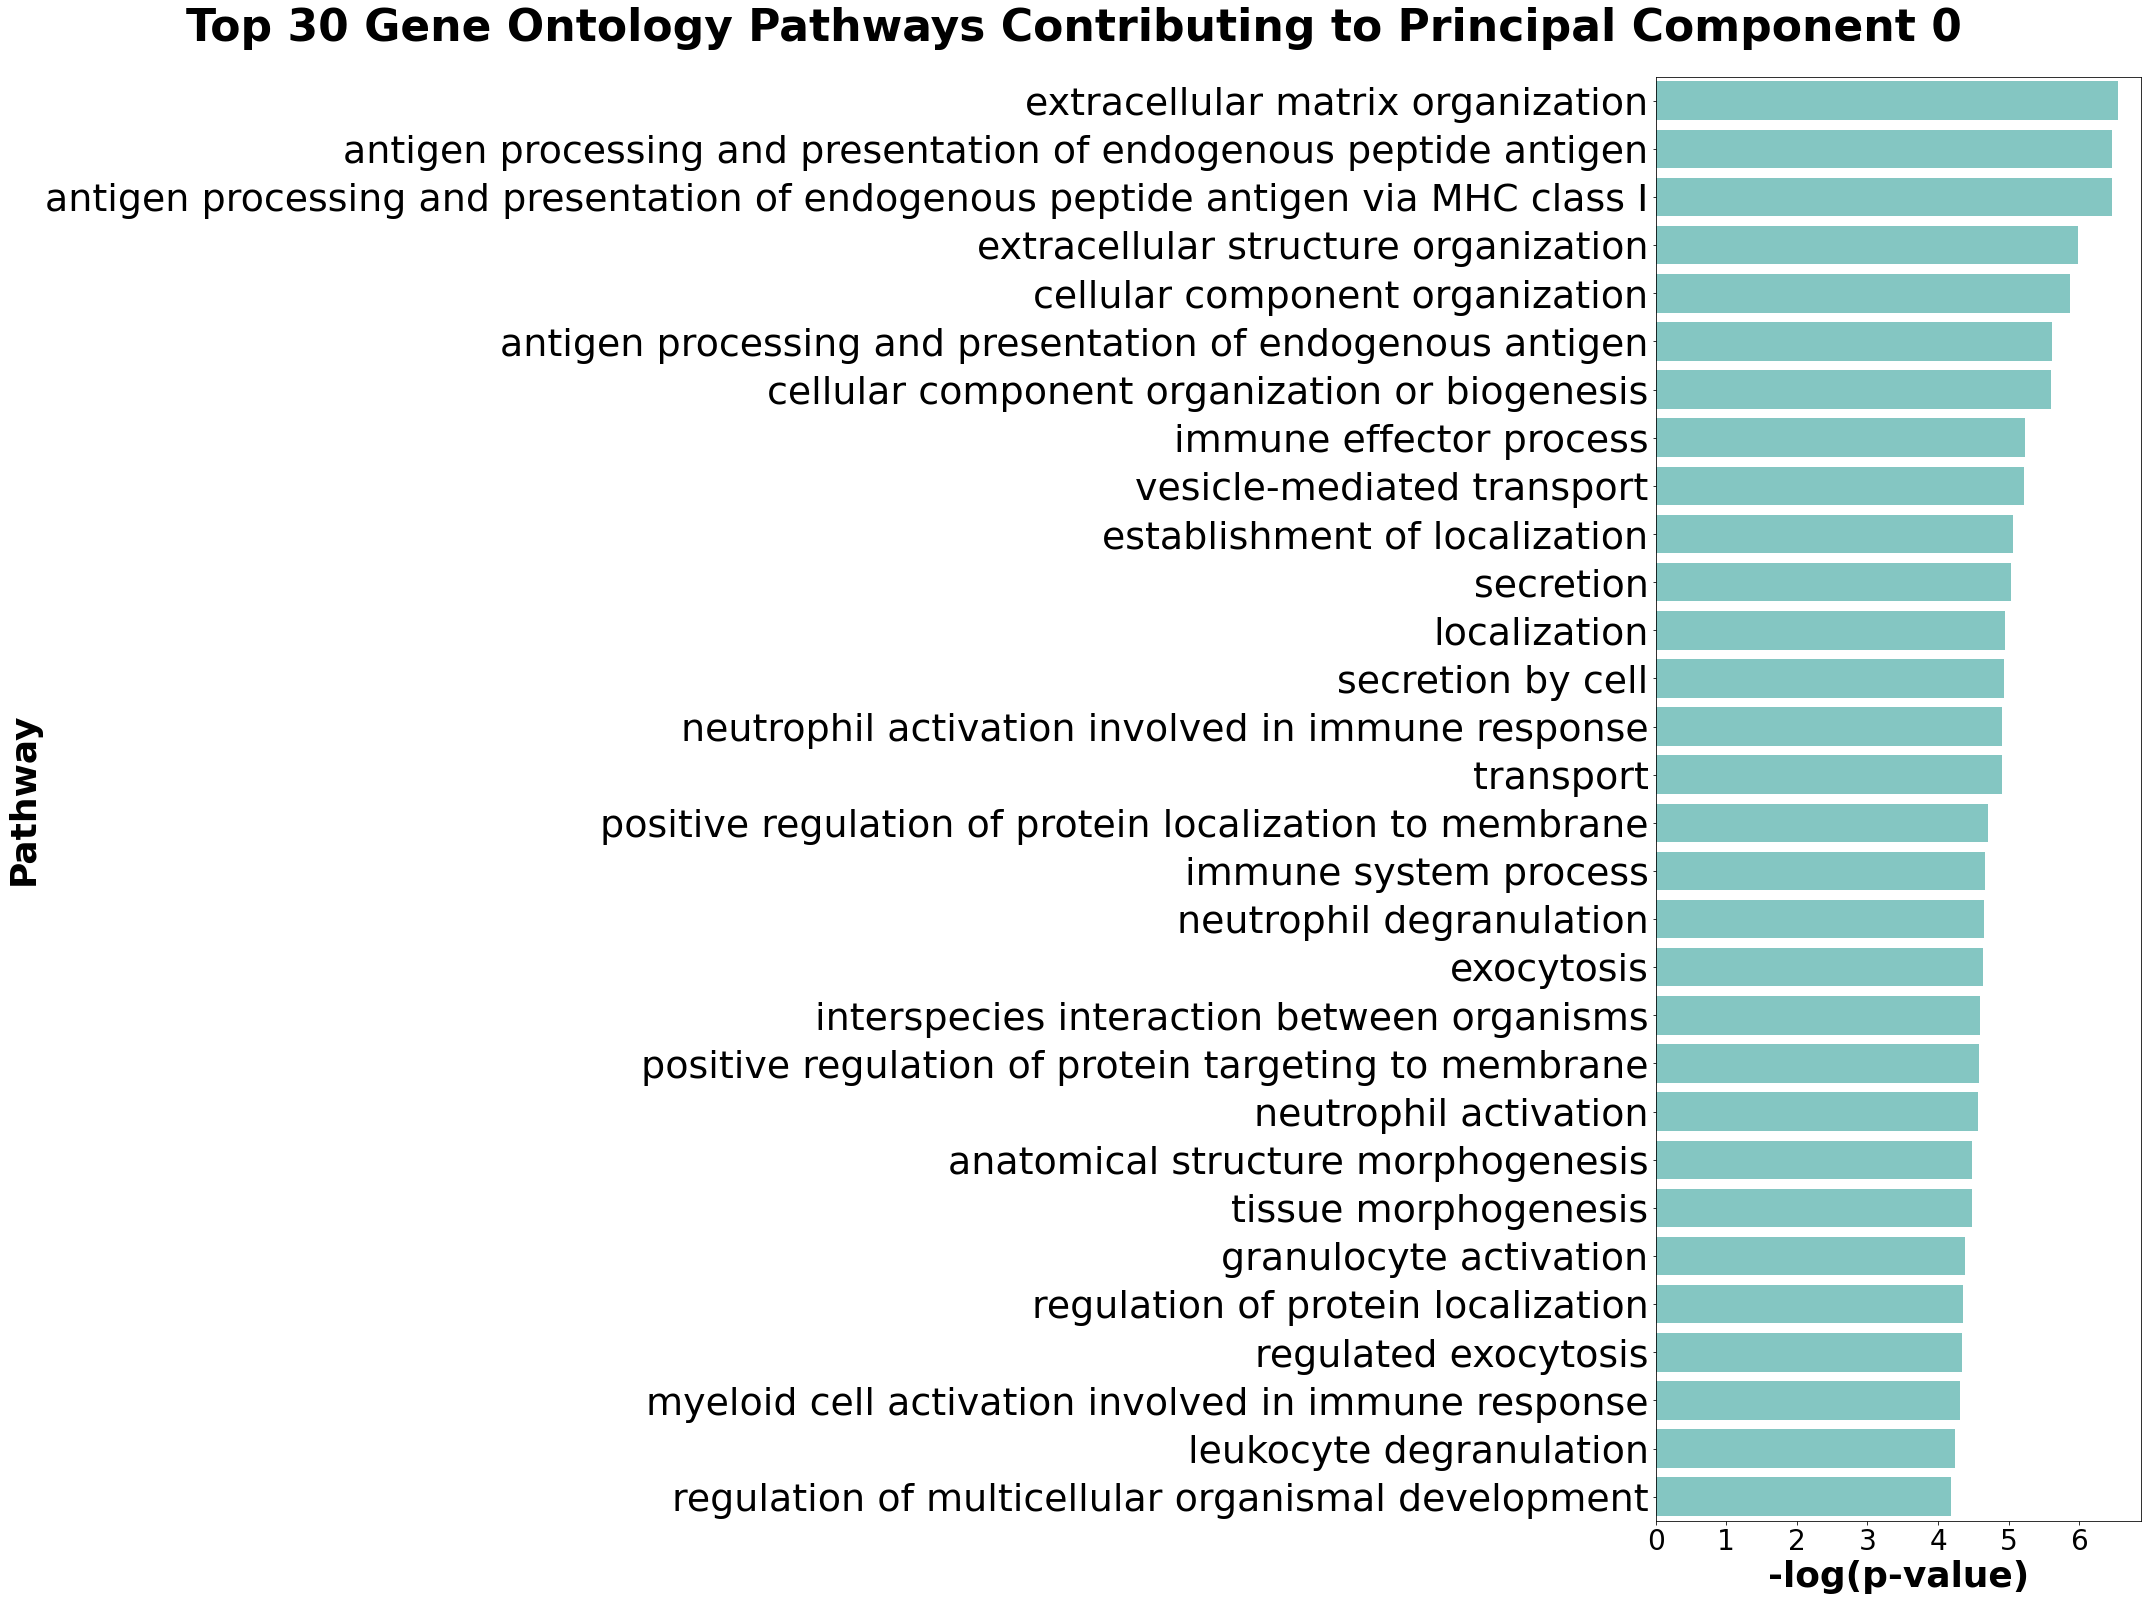

filtered: (30, 11)


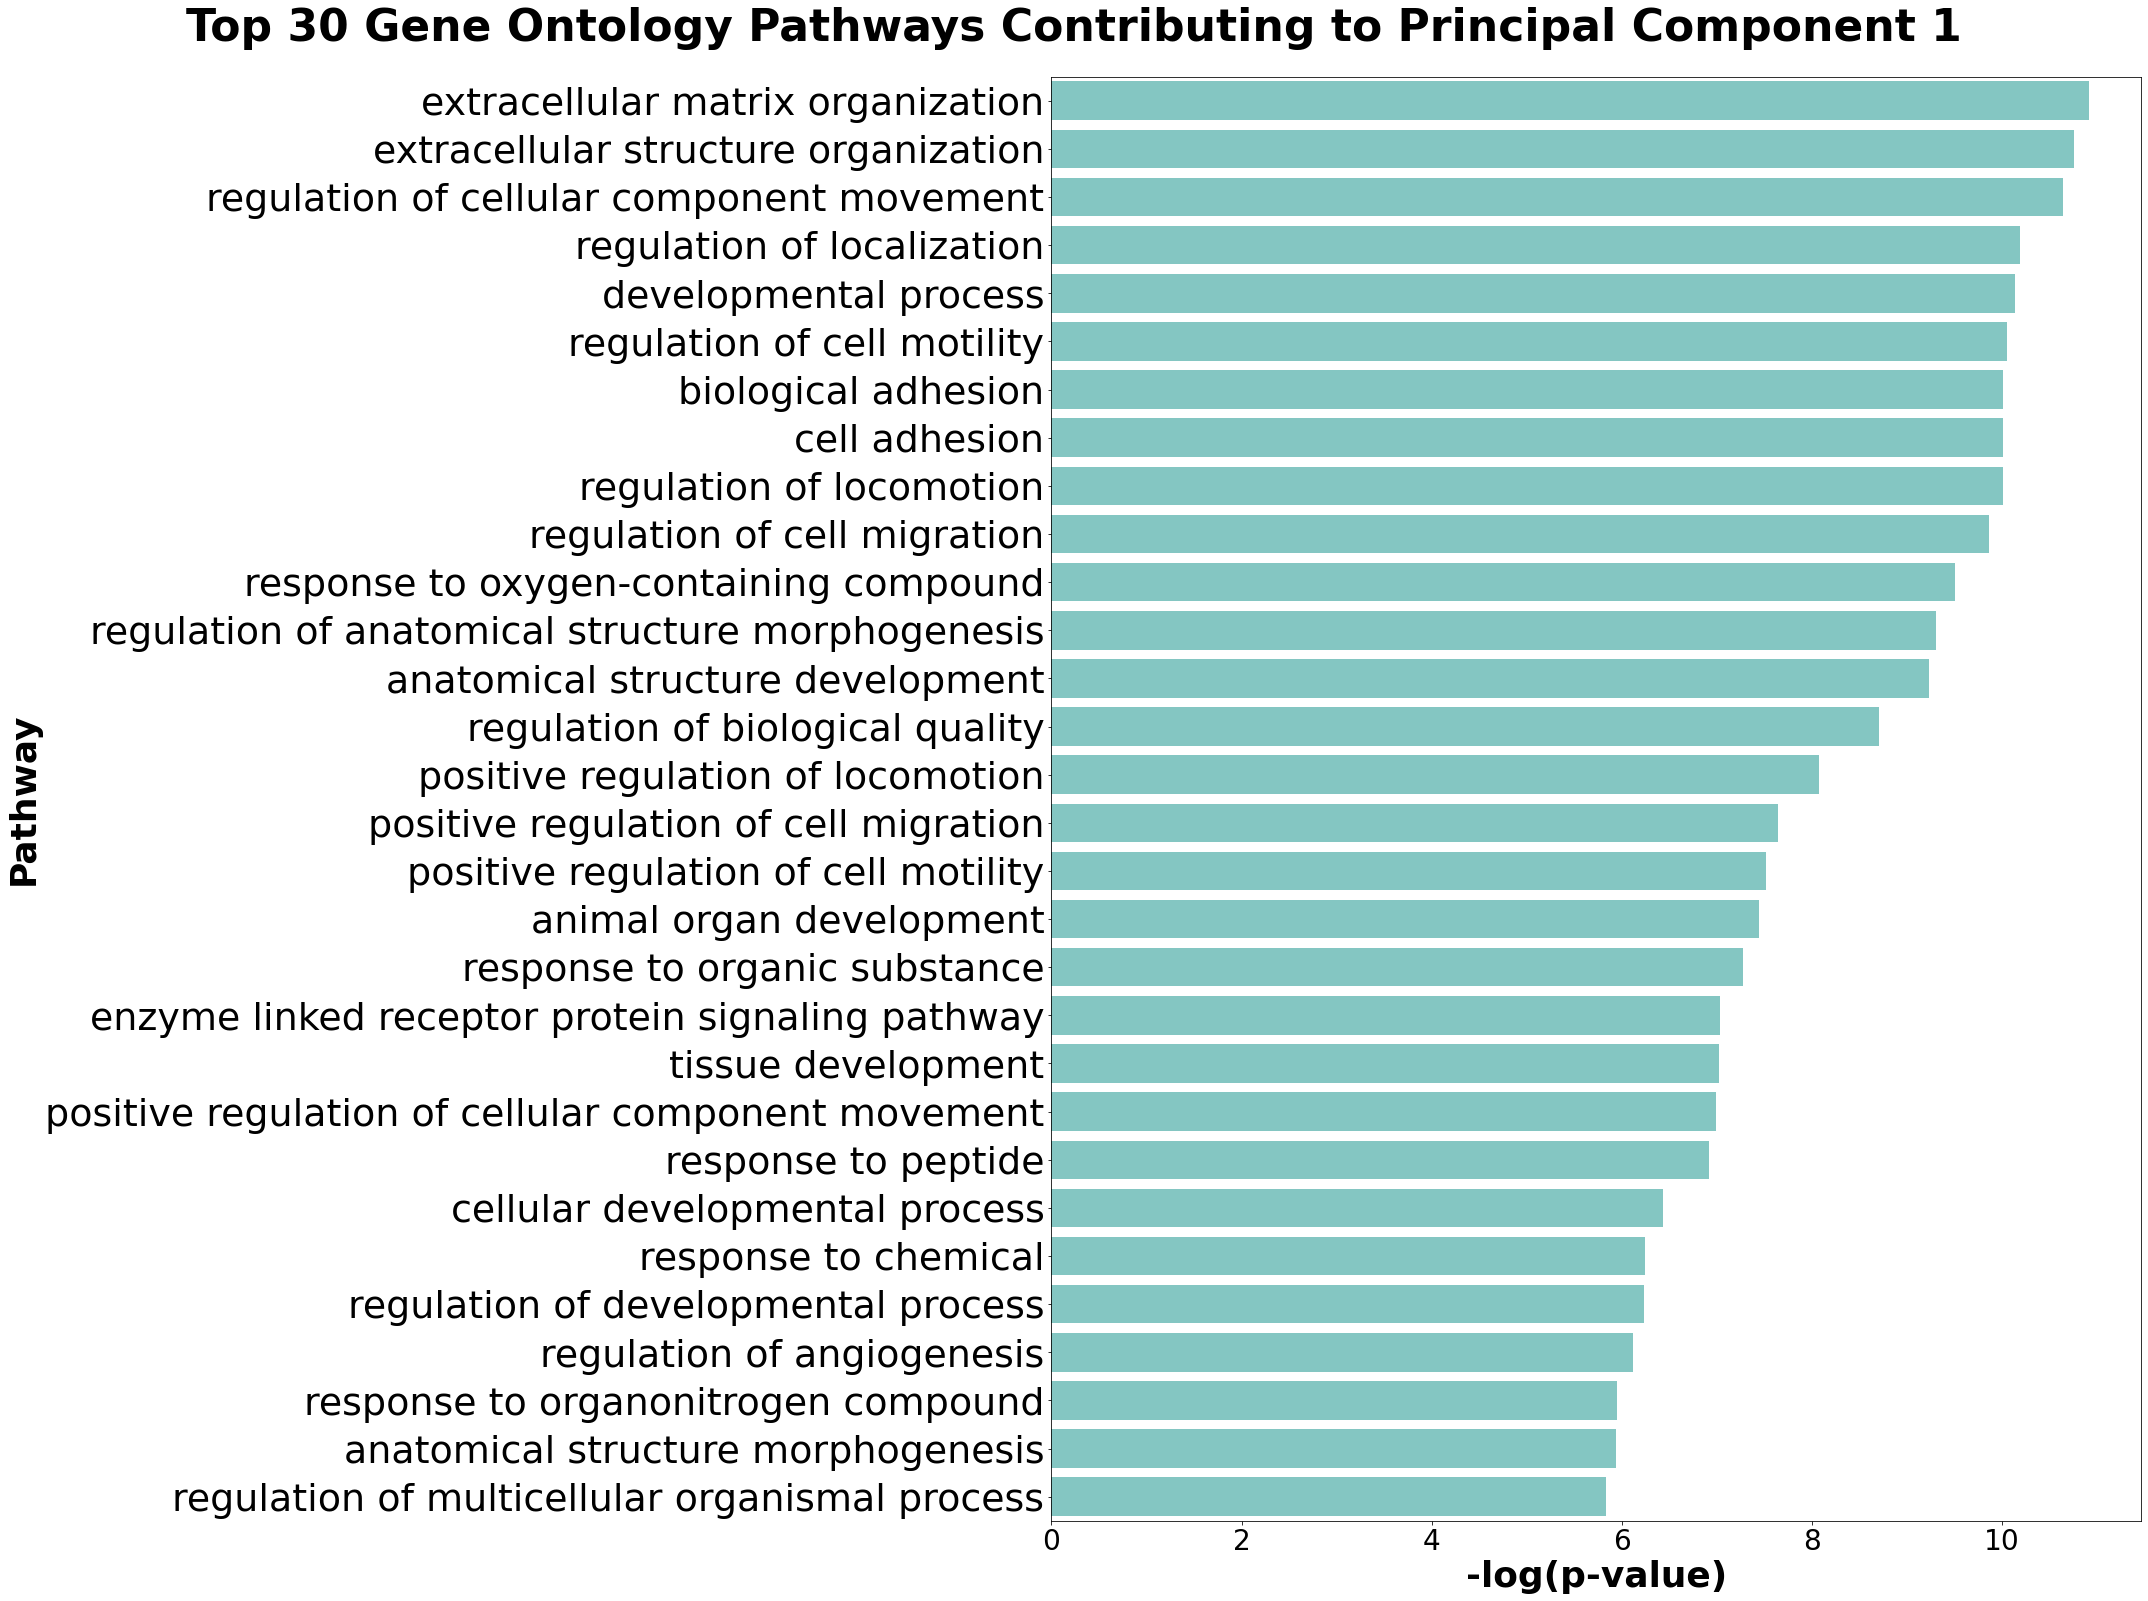

filtered: (8, 11)


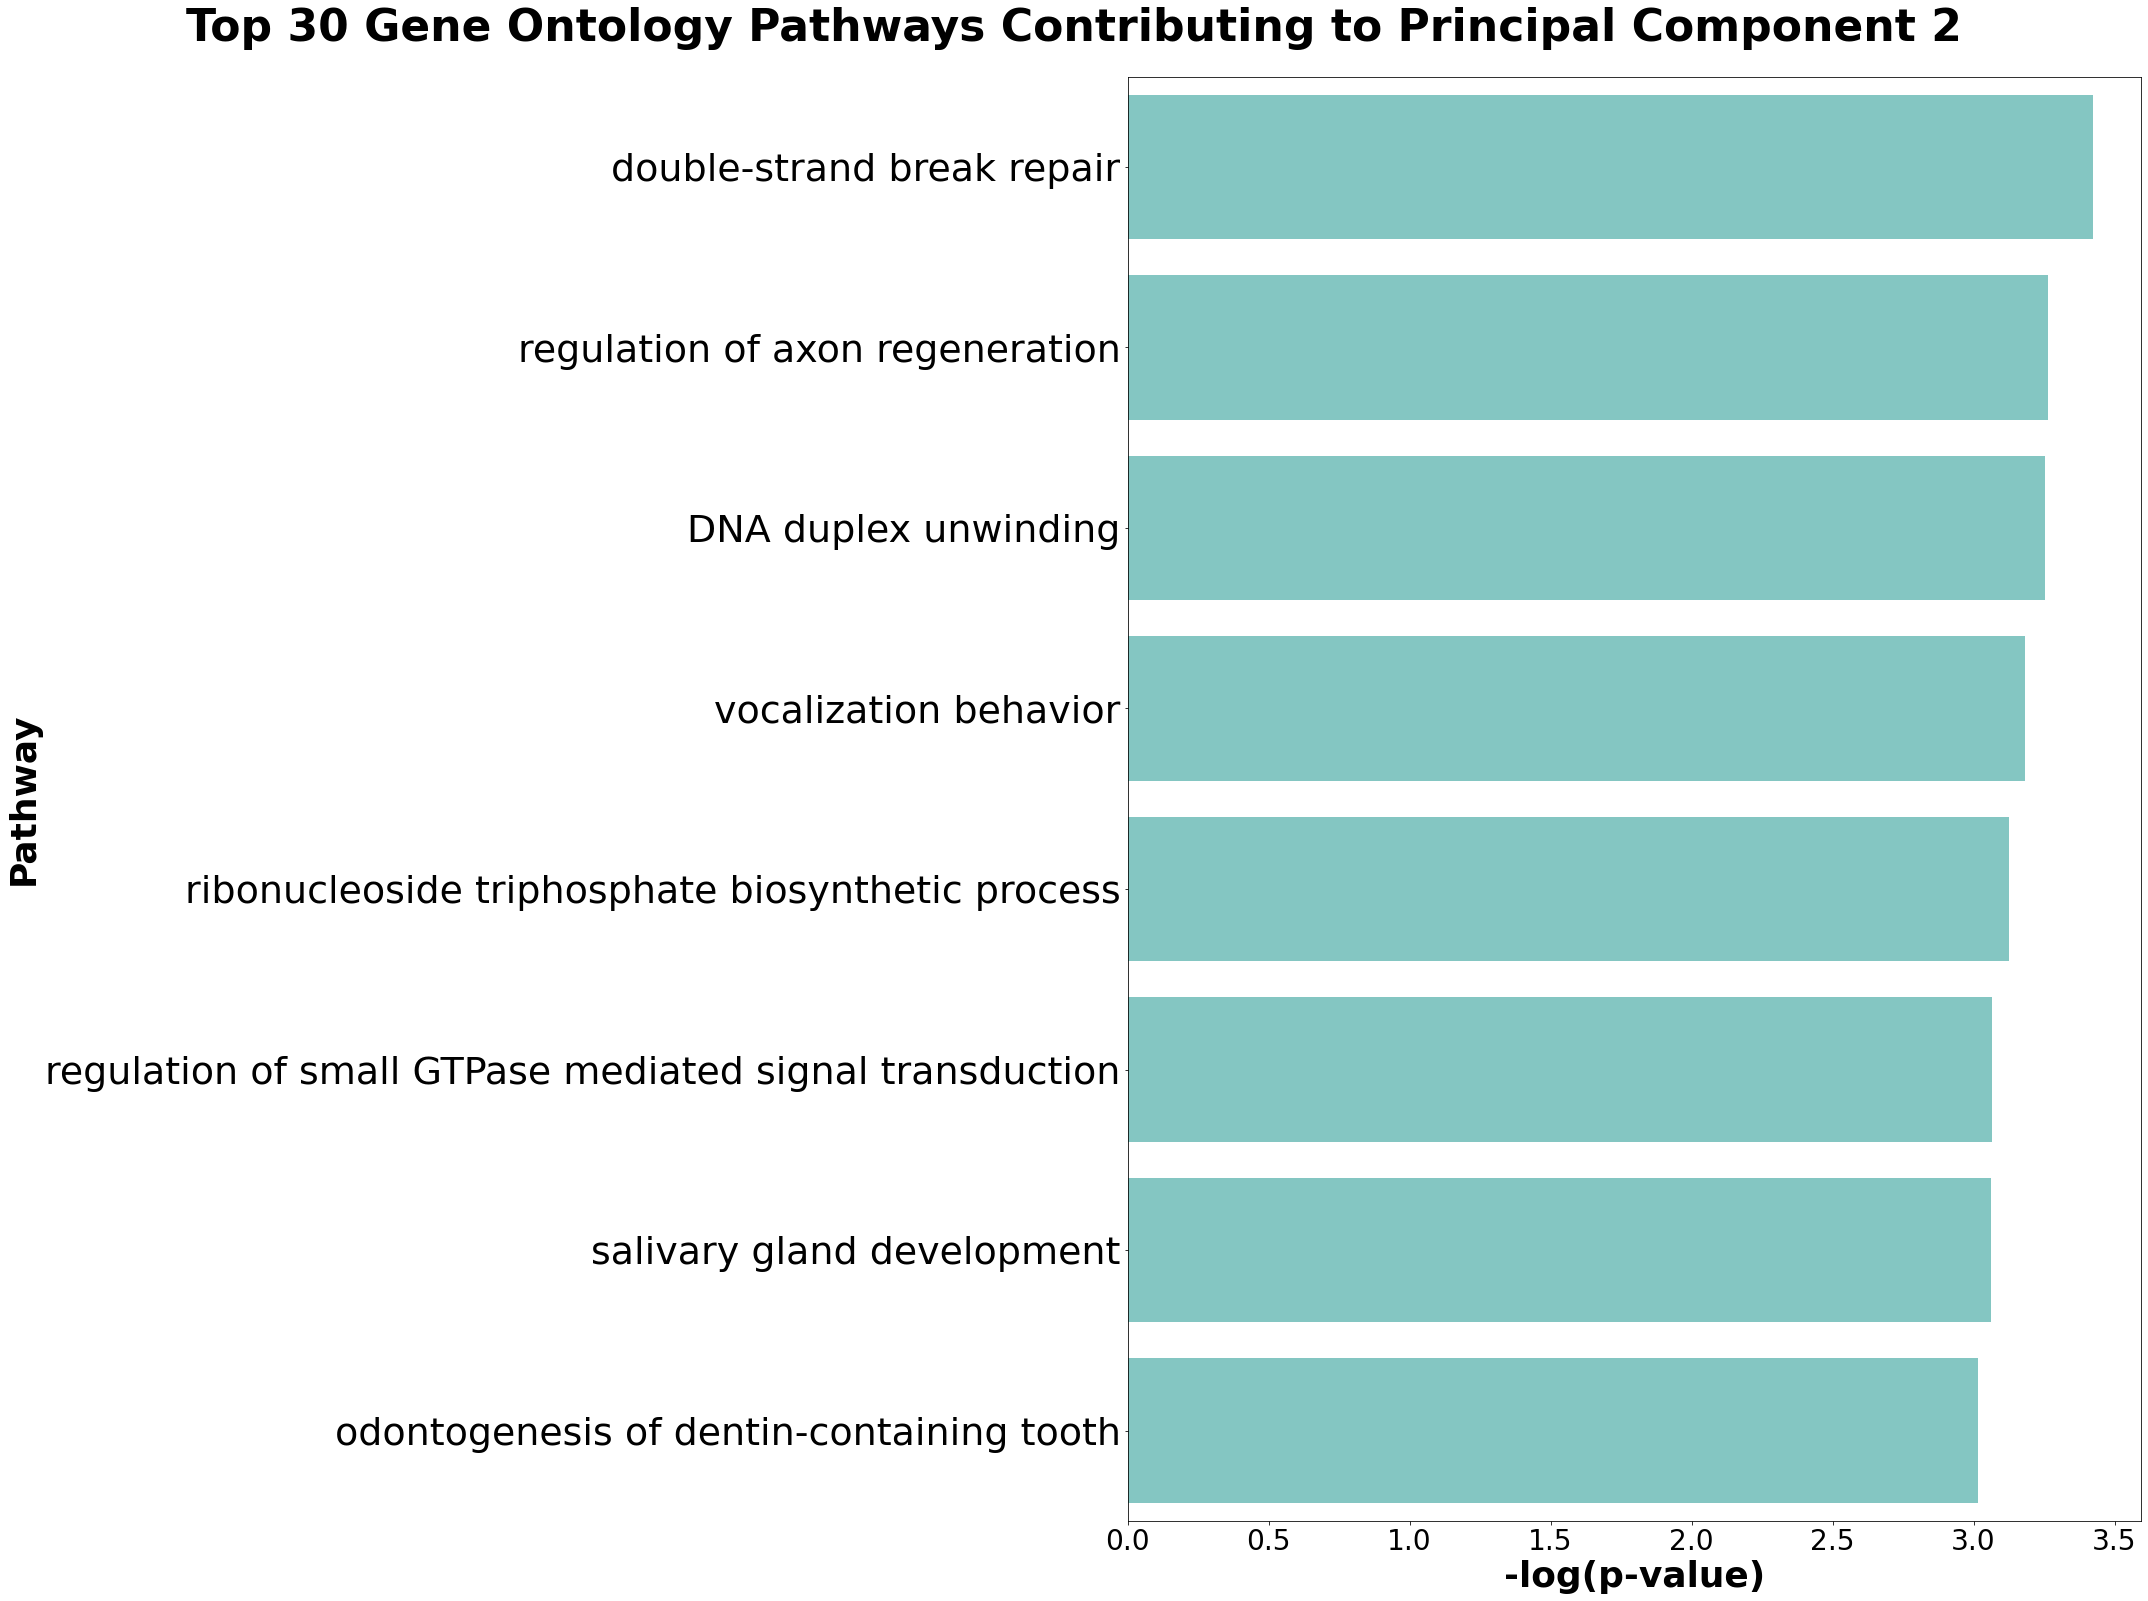

filtered: (30, 11)


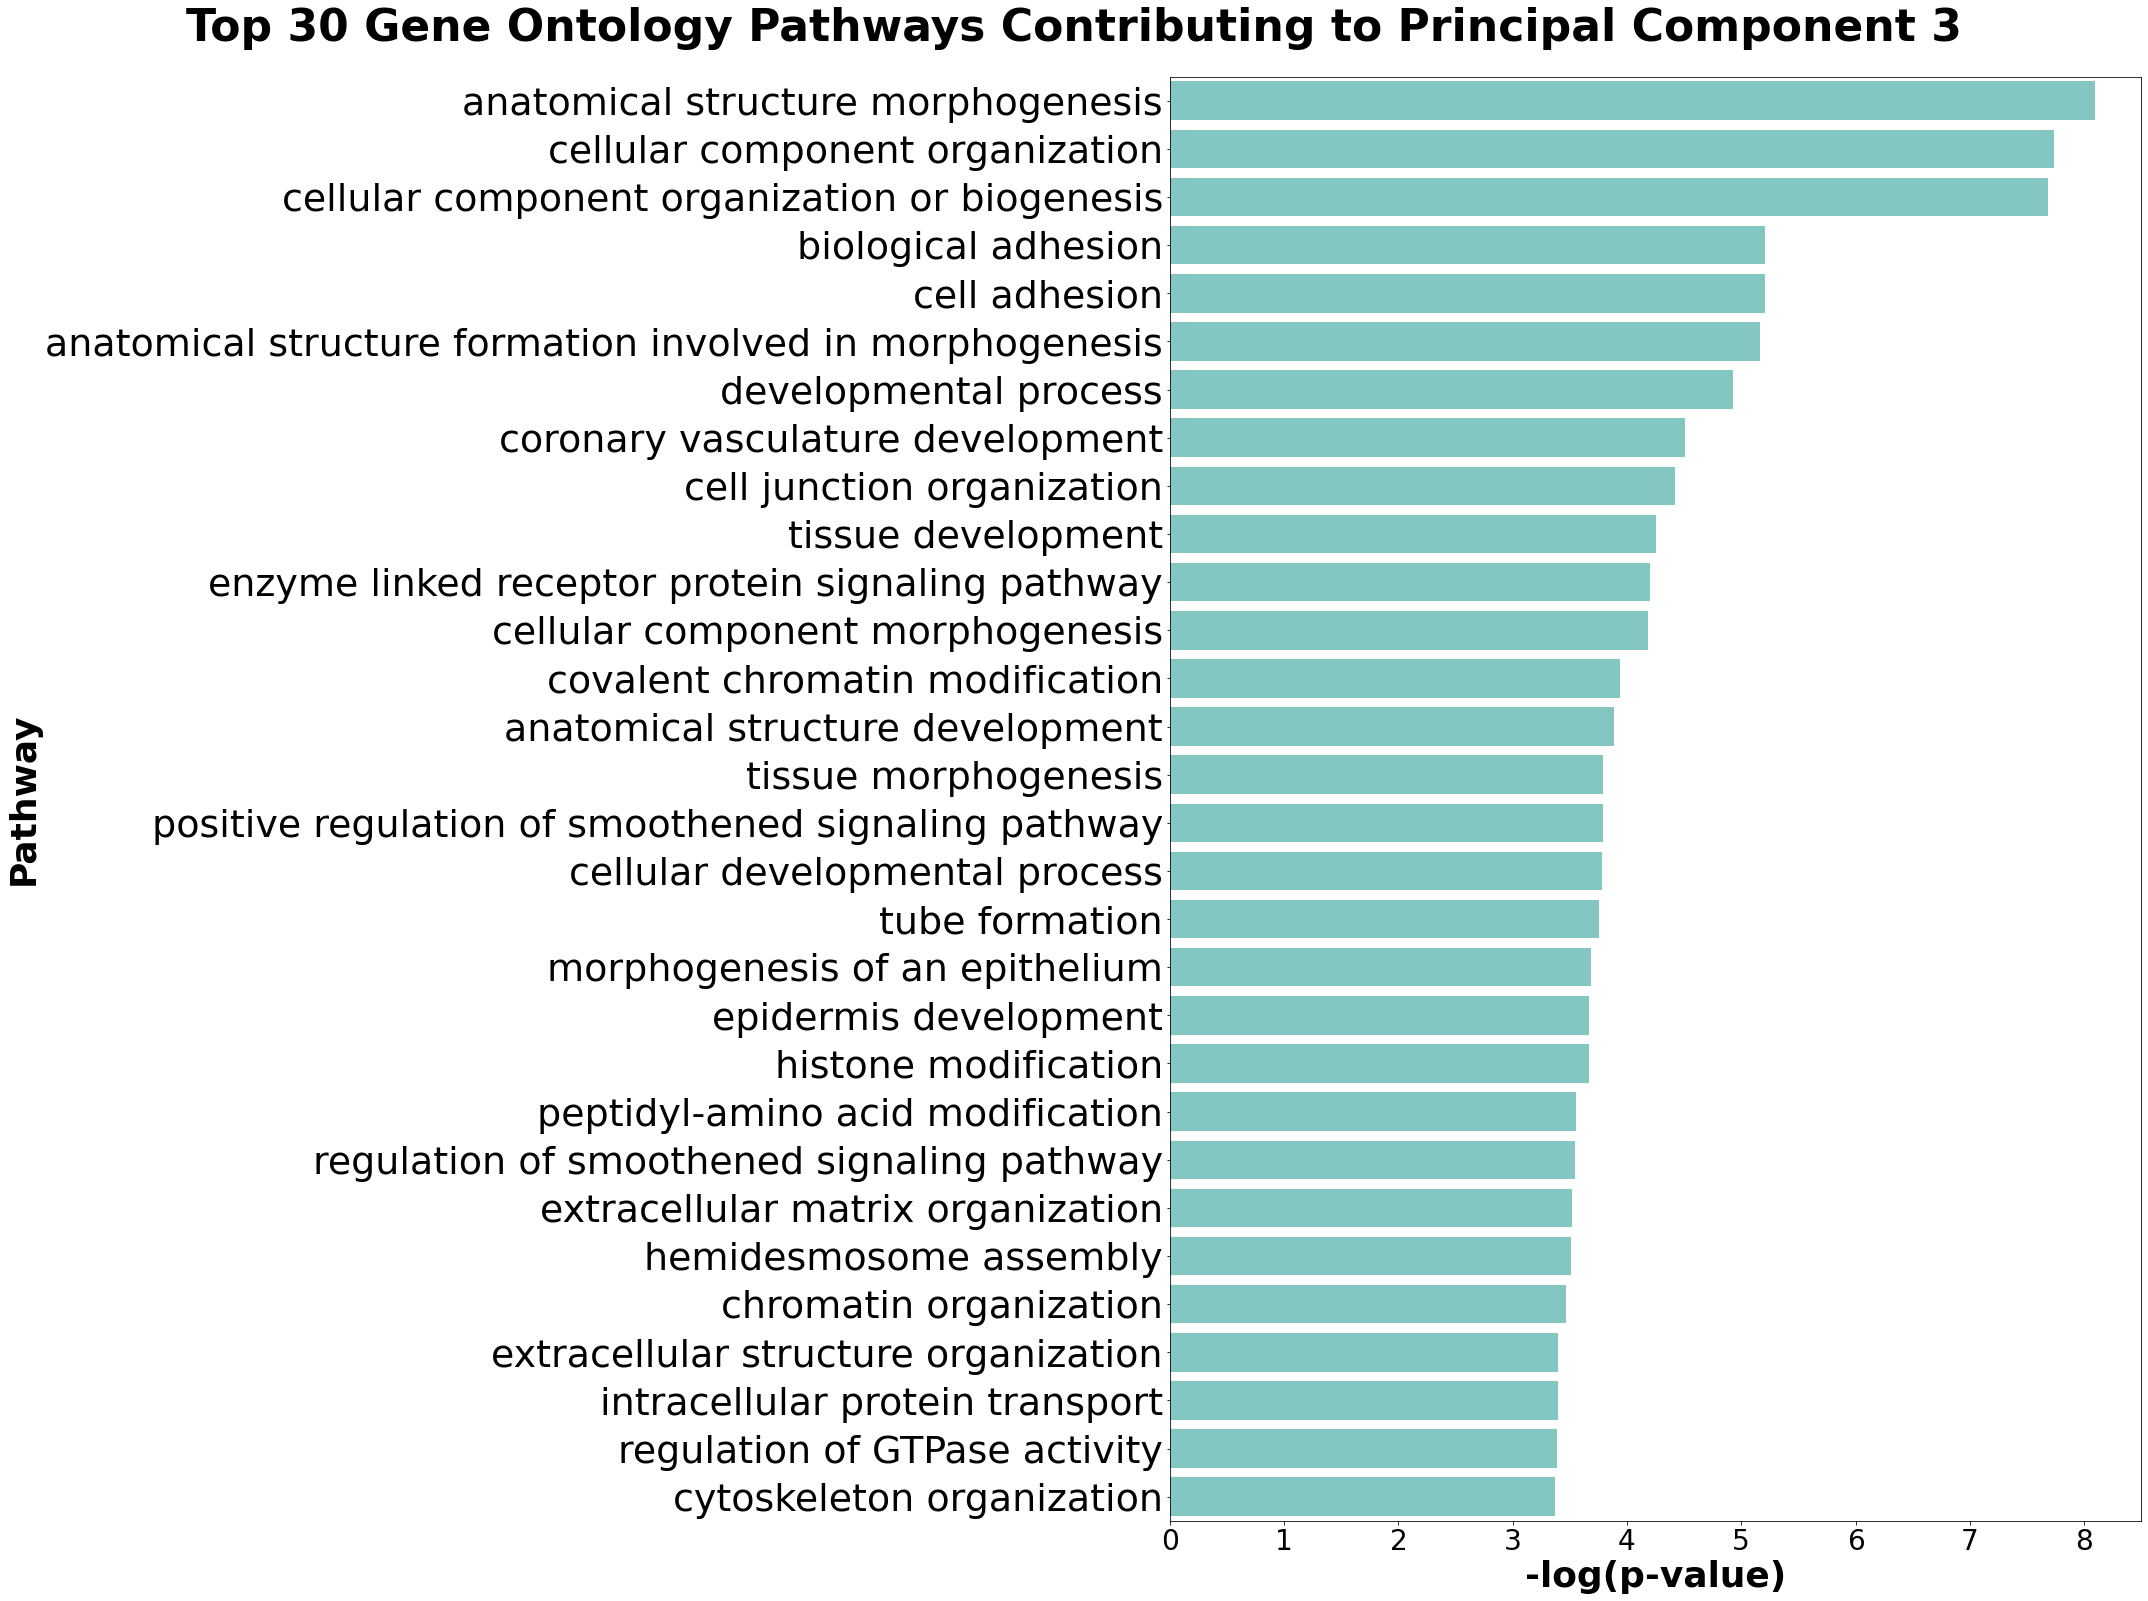

In [101]:
for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP4/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=36, fontweight='bold')
    plt.ylabel('Pathway', fontsize=36, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Principal Component {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=44,  y=1.0005)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(38)
    plt.tight_layout()
    plt.xticks(fontsize=28)
    plt.show()